# Advanced Linear Regression
## Surprise Housing Case Study

#### Problem Statement:

- A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price,

- Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


## Resusable functions


In [762]:
def calculate_metrics(train,pred):
  """ Calculates important metrics for a given train and predictions"""
  metrics=[]
  r2 = r2_score(train, pred)
  metrics.append(r2)
  print("R2 Score is:", r2)
  rss = np.sum(np.square(train - pred))
  metrics.append(rss)
  print("RSS is ", rss)
  mse = mean_squared_error(train, pred)
  metrics.append(mse)
  print("MSE is: ", mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  metrics.append(rmse)
  print("RMSE is: ", rmse)
  return metrics

def run_cross_validation():
  """ Runs Cross validation for Ridge"""
  params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                      2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

  ridge = Ridge()
  # cross validation
  ridgeCV = GridSearchCV(estimator = ridge, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error',  
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1, n_jobs=-1)            
  ridgeCV.fit(X_train, y_train) 

  print(ridgeCV.best_params_)
  return ridgeCV

def do_residual_analysis(y_train, y_train_pred):
  """Does residual analysis and plots residuals"""
  y_res = y_train - y_train_pred
  #y_res
  data = pd.DataFrame({"res":y_res})
  plt.scatter( y_train_pred , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel("Predictions")
  plt.ylabel("Residual")
  plt.show()

# Distribution of errors
  p = sns.distplot(y_res,kde=True)

  p = plt.title('Normality of error terms/residuals')
  plt.xlabel("Residuals")
  plt.show()

def print_metrics(ridge_metrics, lasso_metrics, col1, col2):
  """Print metrics in comparable tabular format"""
  ## Setting float display options
  pd.options.display.float_format = "{:,.2f}".format
  # Creating a table which contain all the metrics
  lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                        'MSE (Train)', 'RMSE (Train)', 'R2 Score (Test)','RSS (Test)',
                        'MSE (Test)', 'RMSE (Test)'],
              col1 : ridge_metrics,
              col2 : lasso_metrics }

  final_metric = pd.DataFrame(lr_table, columns = ['Metric', col1,col2] )
  final_metric.set_index('Metric')
  print(final_metric)

# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [763]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [764]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data

In [765]:
housing = pd.read_csv("train.csv")

In [766]:
# Check the head of the dataset
housing.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.00     8450   Pave   NaN      Reg   
1   2          20       RL        80.00     9600   Pave   NaN      Reg   
2   3          60       RL        68.00    11250   Pave   NaN      IR1   
3   4          70       RL        60.00     9550   Pave   NaN      IR1   
4   5          60       RL        84.00    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Inspect the various aspects of the dataframe

In [767]:
housing.shape
# Inference - 1460 Rows, 81 Columns

(1460, 81)

In [768]:
housing.info()
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Check for duplicates

In [769]:
# check for duplicate rows based on id
any_duplicates=housing.duplicated(['Id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [770]:
# remove empty columns
housing = housing.dropna(axis = 1, how = 'all')
housing.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Drop rows with NA

In [771]:
#drop all the rows with only nan values
housing = housing.dropna(axis = 0, how = 'all')
housing.info()
# no of rows remains 1460

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Drop columns that high percentage of Nan

In [772]:
#drop columns that have high percentage of nan
print(housing.shape)
# keep columns where null percentage is less than 60%
housing = housing.loc[:, housing.isnull().mean() < .6]
# four columns with high percentage of nulls dropped
print(housing.shape)

(1460, 81)
(1460, 77)


Drop rows with high percentage of Nan

In [773]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*housing.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
housing = housing.dropna( axis=0, 
                    thresh=min_count)
housing.shape
# no rows to drop , remains 1460

31


(1460, 77)

Data Manipulation

In [774]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Print all columns with missing values

In [775]:
def print_cols_with_missing_values():
  cols_with_missing_values = housing.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  
print_cols_with_missing_values()

Number of Missing Values
FireplaceQu                        690
LotFrontage                        259
GarageType                          81
GarageYrBlt                         81
GarageFinish                        81
GarageQual                          81
GarageCond                          81
BsmtExposure                        38
BsmtFinType2                        38
BsmtQual                            37
BsmtCond                            37
BsmtFinType1                        37
MasVnrArea                           8
MasVnrType                           8
Electrical                           1

In [776]:
# data cleaning
# check every column which has nulls
# fix nulls
# derive columns from timestamps
# impute data where required

In [777]:
# columns GarageType has nulls -> impute
cat_columns=['FireplaceQu','GarageType','GarageCond','GarageFinish','GarageQual','BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtCond','BsmtQual','MasVnrType']
# FireplaceQU: data description of the variables states that NA represents "no fireplace"
# GarageType: data description of the variables states that NA represents "no garage"
# GarageCond: data description of the variables states that NA represents "no garage"
# GarageFinish: data description of the variables states that NA represents "no garage"
# GarageQual: data description of the variables states that NA represents "no garage"
# BsmtFinType1 : : data description of the variables states that NA represents "no basement"
# BsmtFinType2 : : data description of the variables states that NA represents "no basement"
# BsmtExposure : : data description of the variables states that NA represents "no basement"
# BsmtCond : : data description of the variables states that NA represents "no basement"
# BsmtQual : : data description of the variables states that NA represents "no basement"
# MasVnrType: data description of the variables states that NA represents "no veneer"
for col in cat_columns:
  print(col)
  print('Before Cleaning')
  print(housing[col].isnull().sum())
  print(housing[col].unique())
  housing[col].fillna('None',inplace=True)
  print('After Cleaning')
  print(housing[col].unique())
  print(housing[col].isnull().sum())

FireplaceQu
Before Cleaning
690
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
After Cleaning
['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
0
GarageType
Before Cleaning
81
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
After Cleaning
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
0
GarageCond
Before Cleaning
81
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
After Cleaning
['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
0
GarageFinish
Before Cleaning
81
['RFn' 'Unf' 'Fin' nan]
After Cleaning
['RFn' 'Unf' 'Fin' 'None']
0
GarageQual
Before Cleaning
81
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
After Cleaning
['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
0
BsmtFinType1
Before Cleaning
37
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
After Cleaning
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
0
BsmtFinType2
Before Cleaning
38
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
After Cleaning
['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
0
BsmtExposure
Before Cleaning
38
['No' 'Gd' 'Mn' 'Av' nan]
After Cleaning
['No' 'Gd' 'Mn' 'Av' 'None']
0
BsmtCond
B

In [778]:
# GarageYrBlt -> missing values mean no garage, so impute with 0
# MasVnrArea -> missing values mean no veneer, so impute with 0
num_columns = ['GarageYrBlt','MasVnrArea']
for col in num_columns:
  print(col)
  print('Before Cleaning')
  housing[col].fillna(0,inplace=True)
  print('After Cleaning')
  print(housing[col].isnull().sum())

GarageYrBlt
Before Cleaning
After Cleaning
0
MasVnrArea
Before Cleaning
After Cleaning
0


In [779]:
#Impute electrical
print(housing['Electrical'].unique())
housing['Electrical'].describe()
# SBrkr is most frequently used
# replace one null with SBrkr
housing['Electrical'].fillna('SBrkr',inplace=True)
print(housing['Electrical'].unique())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']


In [780]:
print_cols_with_missing_values()
# not sure how to impute LotFrontage
print('Before Cleaning')
print(housing['LotFrontage'].unique())
print(housing['LotFrontage'].isnull().sum())
# impute with what? - no clue - read more
# with median for now
housing['LotFrontage'].fillna(housing['LotFrontage'].median(),inplace=True)
print('After Cleaning')
print(housing['LotFrontage'].isnull().sum())

Number of Missing Values
LotFrontage                       259

Before Cleaning
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
259
After Cleaning
0


In [781]:
housing.describe()

Id  MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
count 1,460.00    1,460.00     1,460.00   1,460.00     1,460.00     1,460.00   
mean    730.50       56.90        69.86  10,516.83         6.10         5.58   
std     421.61       42.30        22.03   9,981.26         1.38         1.11   
min       1.00       20.00        21.00   1,300.00         1.00         1.00   
25%     365.75       20.00        60.00   7,553.50         5.00         5.00   
50%     730.50       50.00        69.00   9,478.50         6.00         5.00   
75%   1,095.25       70.00        79.00  11,601.50         7.00         6.00   
max   1,460.00      190.00       313.00 215,245.00        10.00         9.00   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  \
count   1,460.00      1,460.00    1,460.00    1,460.00  ...    1,460.00   
mean    1,971.27      1,984.87      103.12      443.64  ...       94.24   
std        30.20         20.65      180.73      456.10  ...      125.34   
min     1,872.00      1,950.00        0.00        0.00  ...        0.00   
25%     1,954.00      1,967.00        0.00        0.00  ...        0.00   
50%     1,973.00      1,994.00        0.00      383.50  ...        0.00   
75%     2,000.00      2,004.00      164.25      712.25  ...      168.00   
max     2,010.00      2,010.00    1,600.00    5,644.00  ...      857.00   

       OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal  \
count     1,460.00       1,460.00   1,460.00     1,460.00  1,460.00  1,460.00   
mean         46.66          21.95       3.41        15.06      2.76     43.49   
std          66.26          61.12      29.32        55.76     40.18    496.12   
min           0.00           0.00       0.00         0.00      0.00      0.00   
25%           0.00           0.00       0.00         0.00      0.00      0.00   
50%          25.00           0.00       0.00         0.00      0.00      0.00   
75%          68.00           0.00       0.00         0.00      0.00      0.00   
max         547.00         552.00     508.00       480.00    738.00 15,500.00   

        MoSold   YrSold  SalePrice  
count 1,460.00 1,460.00   1,460.00  
mean      6.32 2,007.82 180,921.20  
std       2.70     1.33  79,442.50  
min       1.00 2,006.00  34,900.00  
25%       5.00 2,007.00 129,975.00  
50%       6.00 2,008.00 163,000.00  
75%       8.00 2,009.00 214,000.00  
max      12.00 2,010.00 755,000.00  

[8 rows x 38 columns]

# Step 2: Visualising the Data
Let's now spend some time doing what is arguably the most important step - understanding the data.

If there is some obvious multicollinearity going on, this is the first place to catch it
Here's where you'll also identify if some predictors directly have a strong association with the outcome variable
We'll visualise our data using matplotlib and seaborn.

### Visualize numerical columns


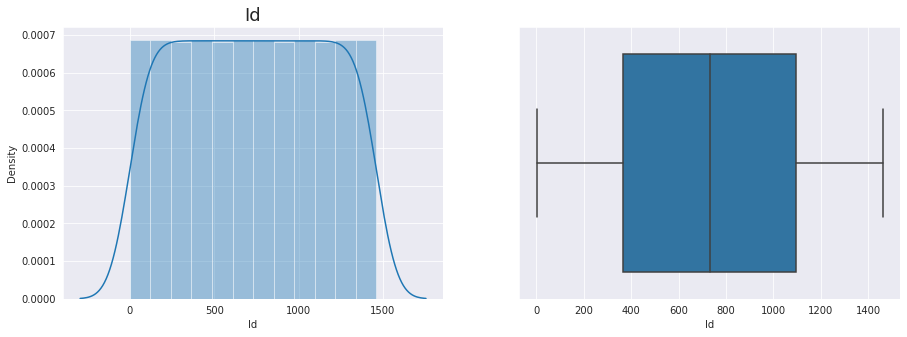

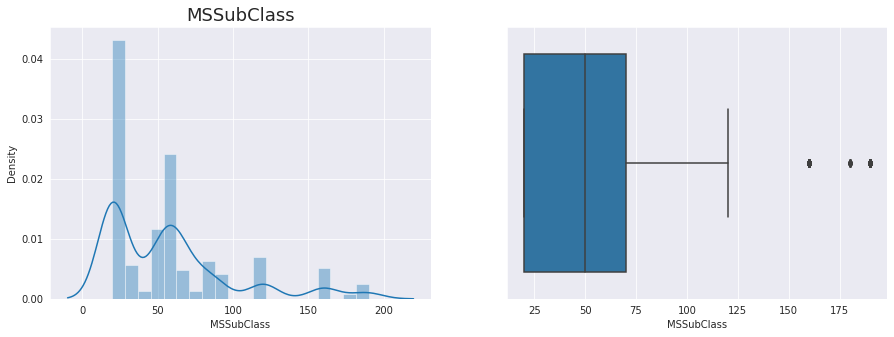

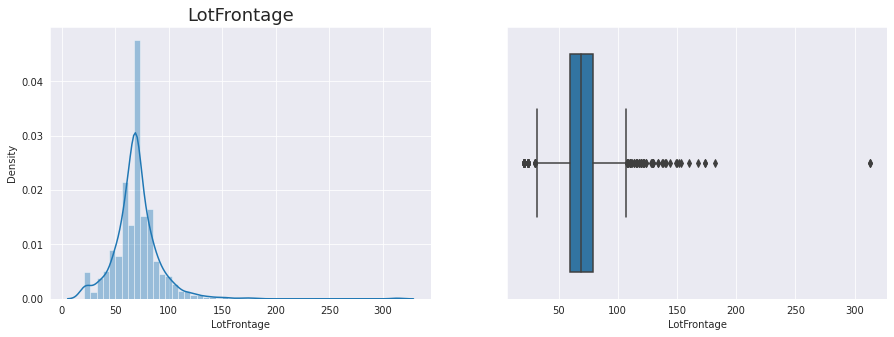

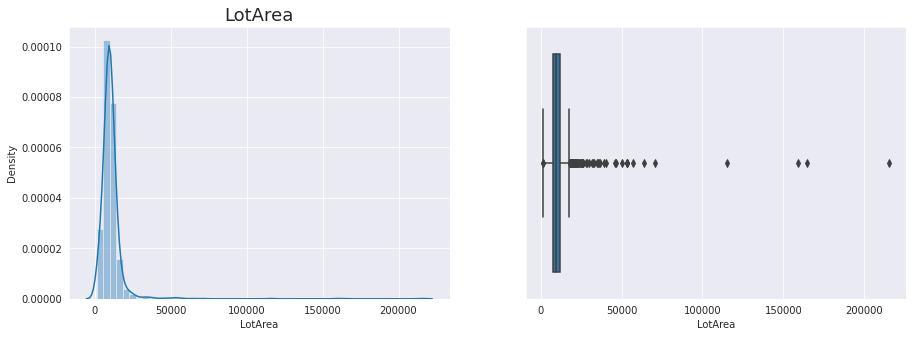

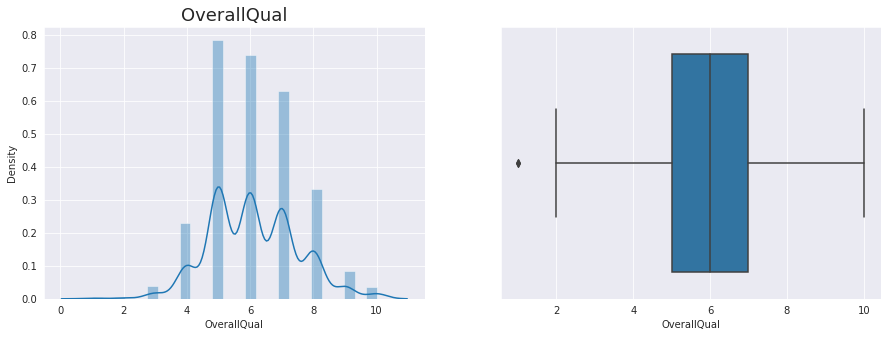

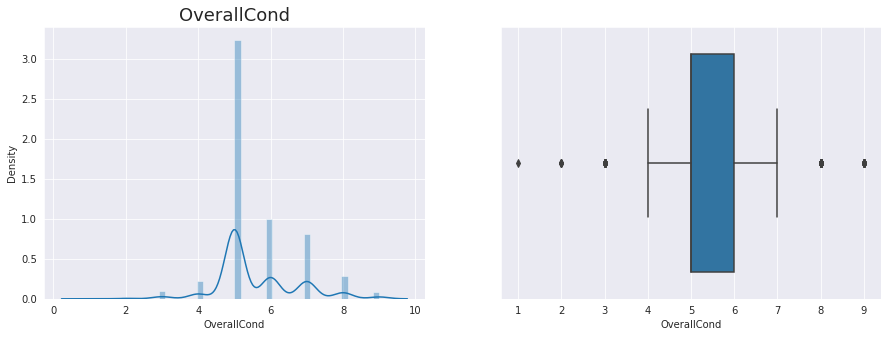

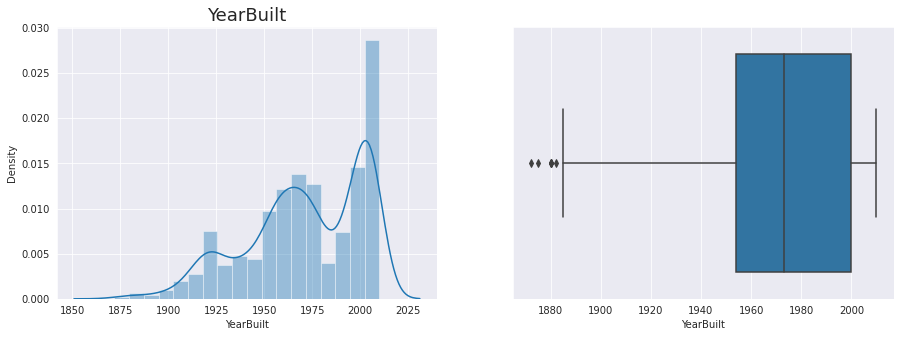

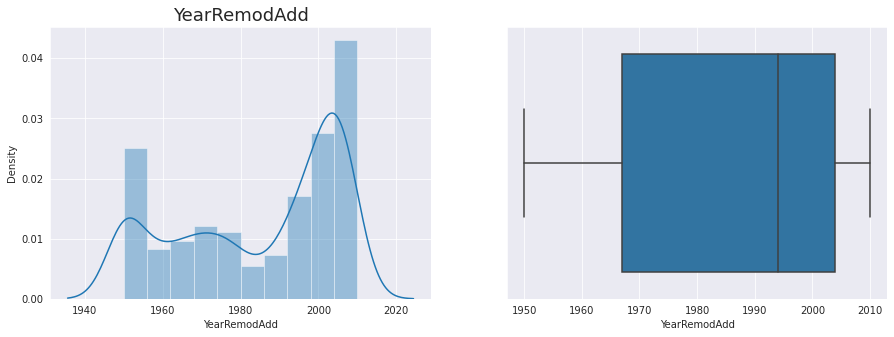

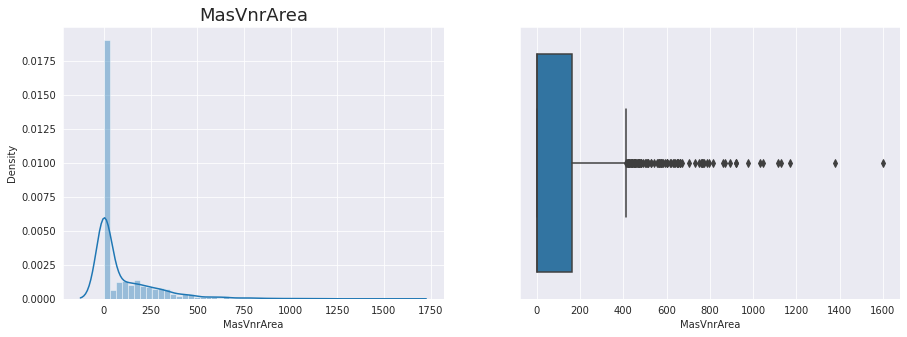

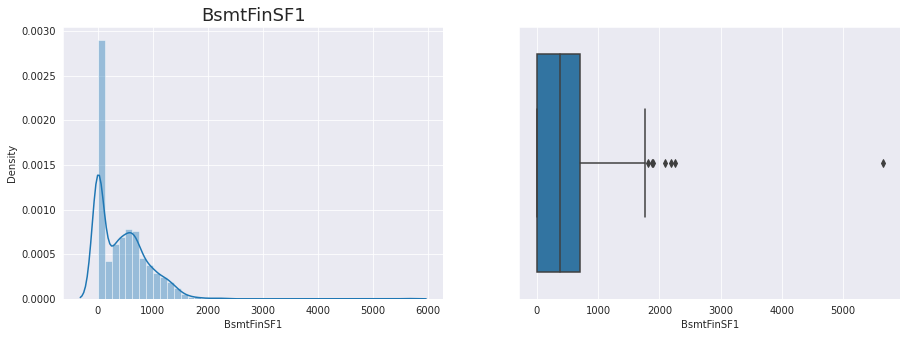

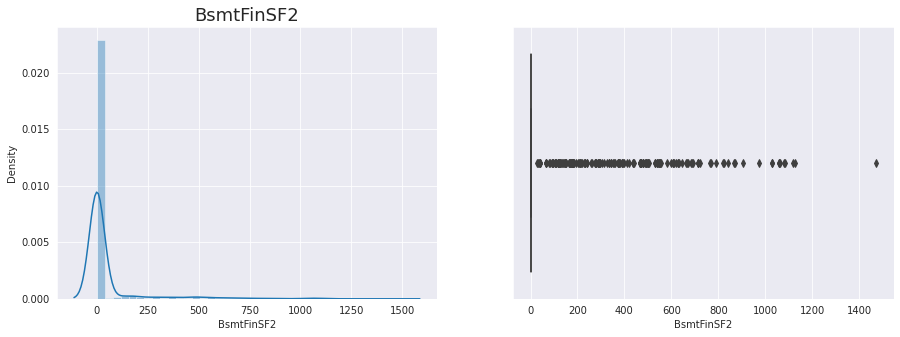

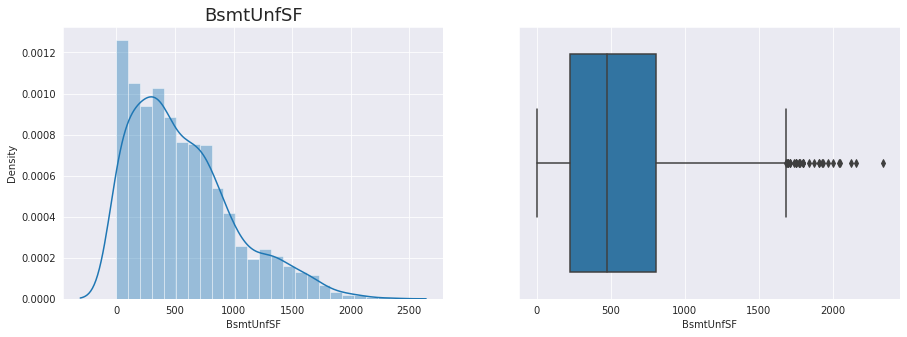

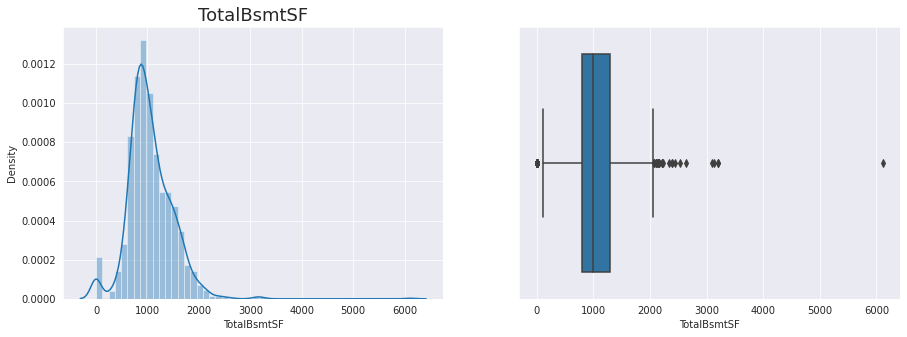

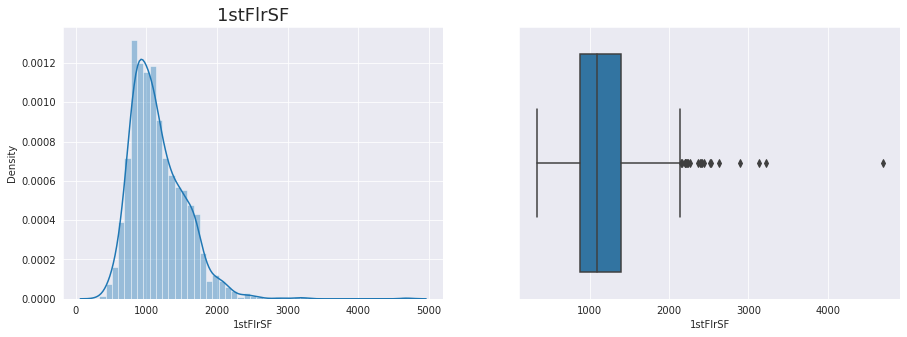

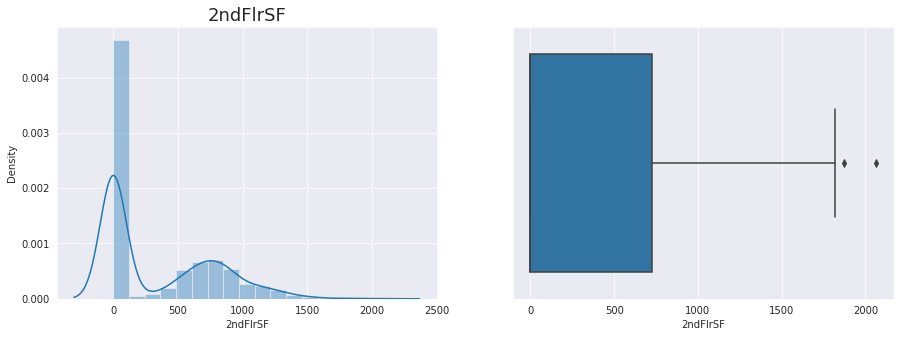

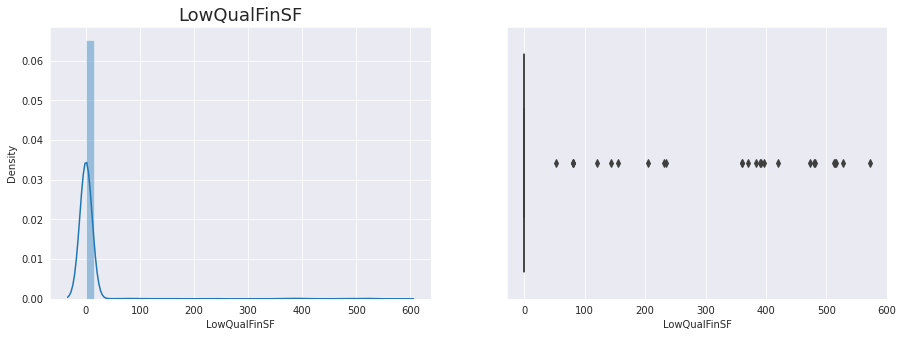

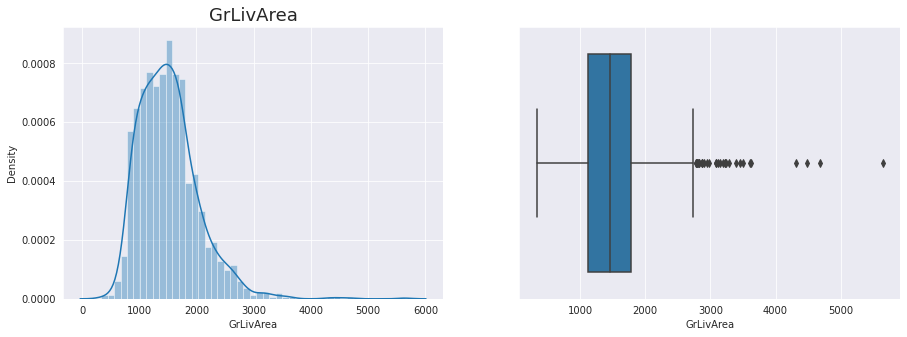

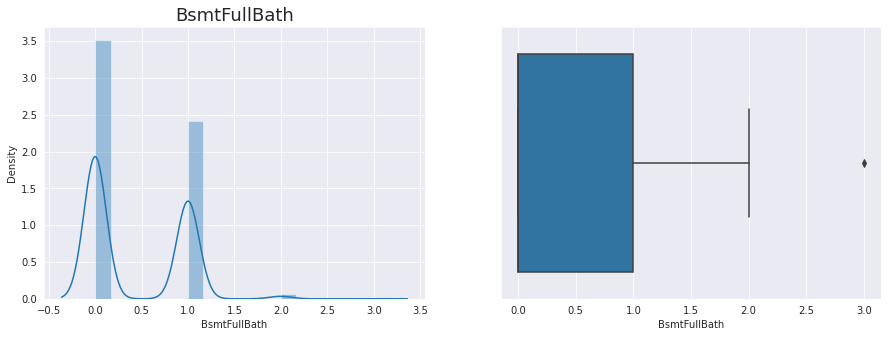

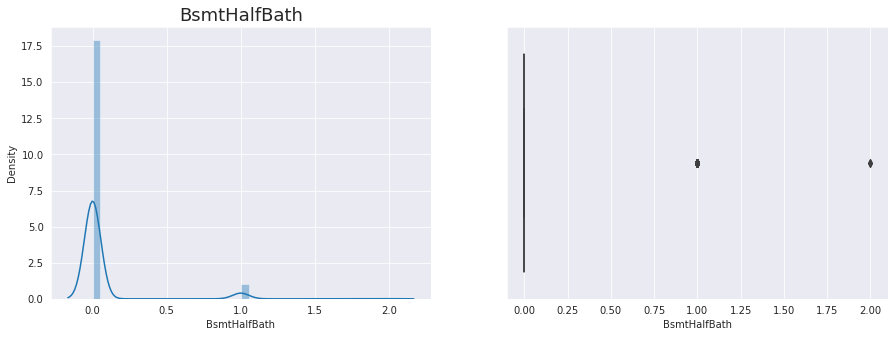

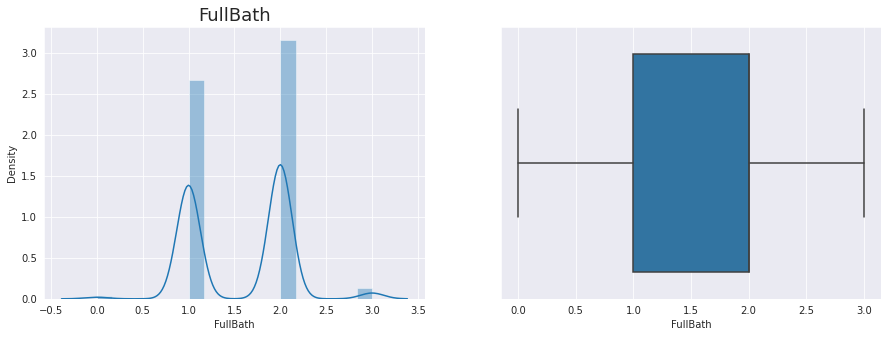

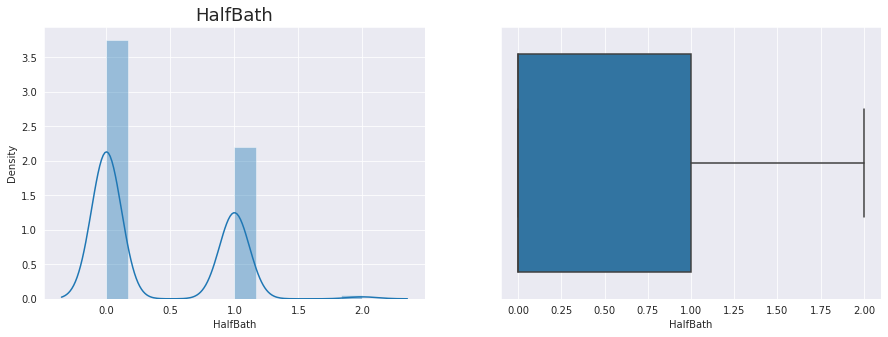

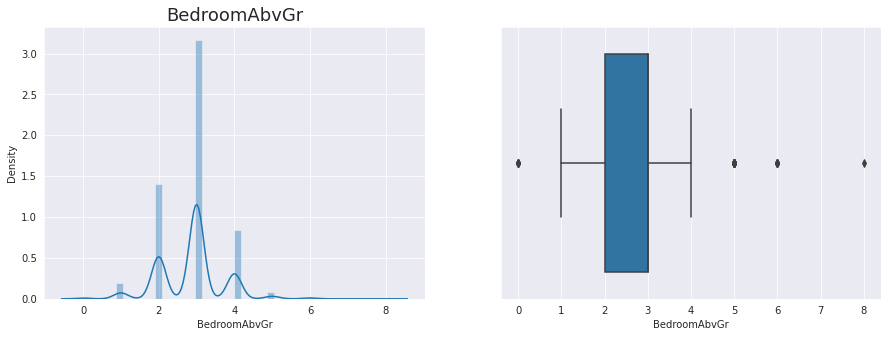

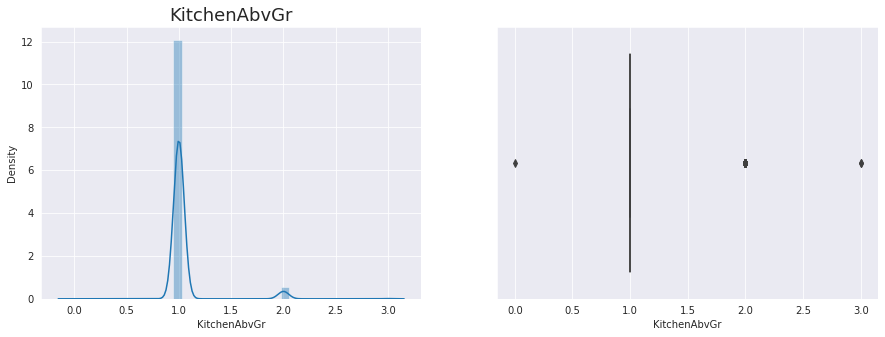

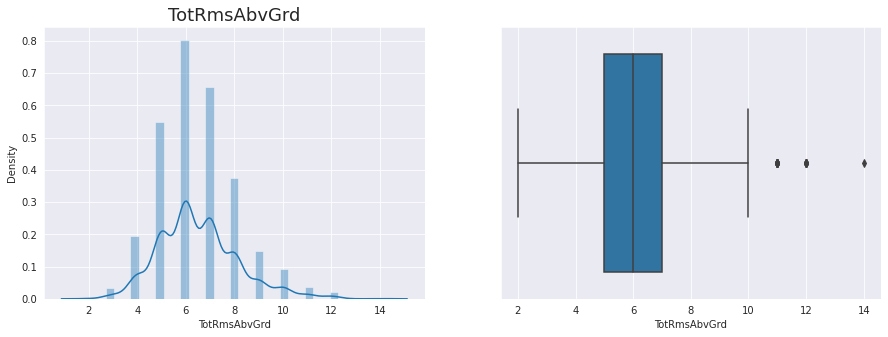

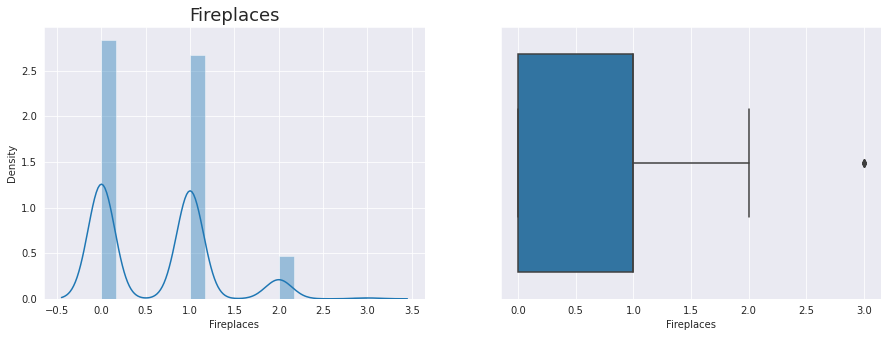

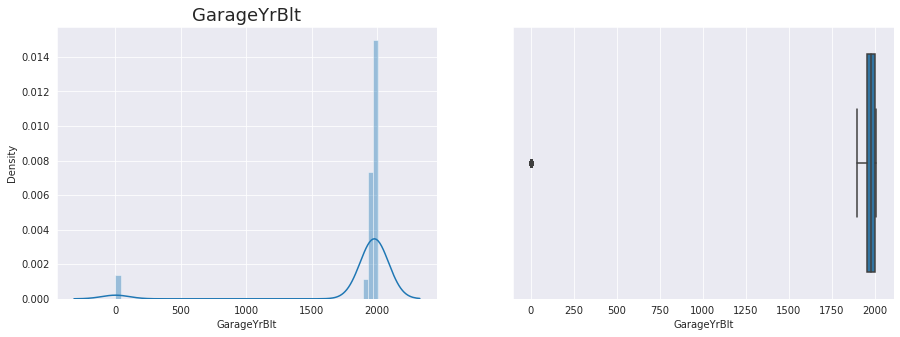

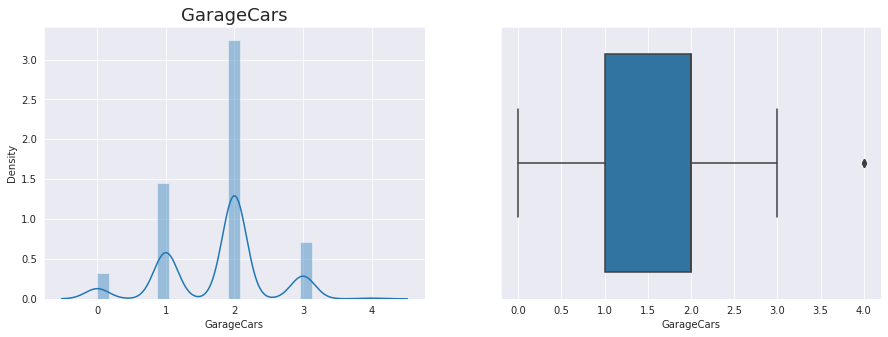

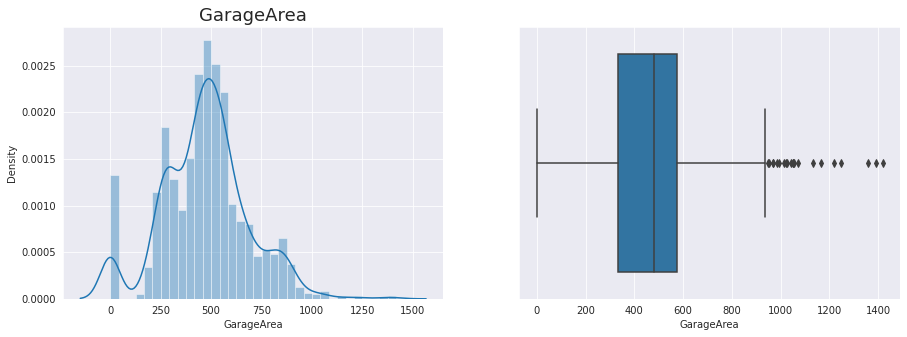

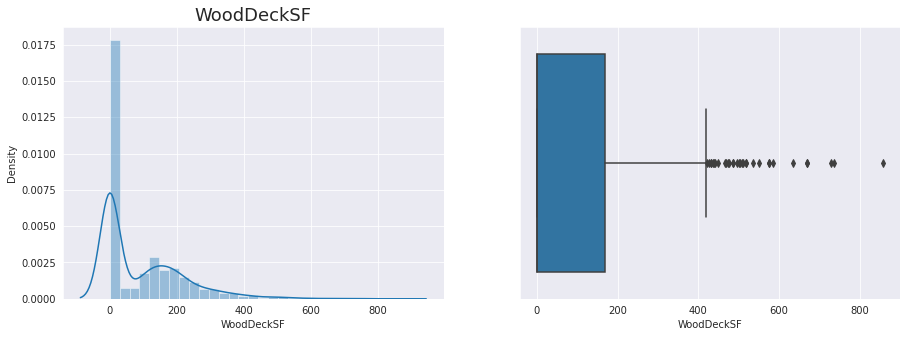

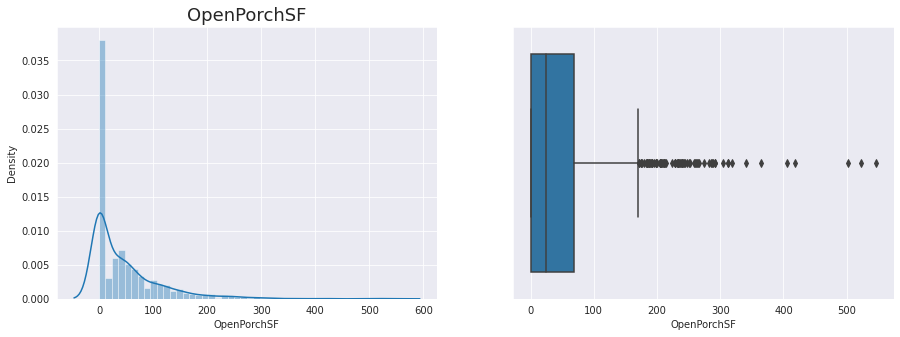

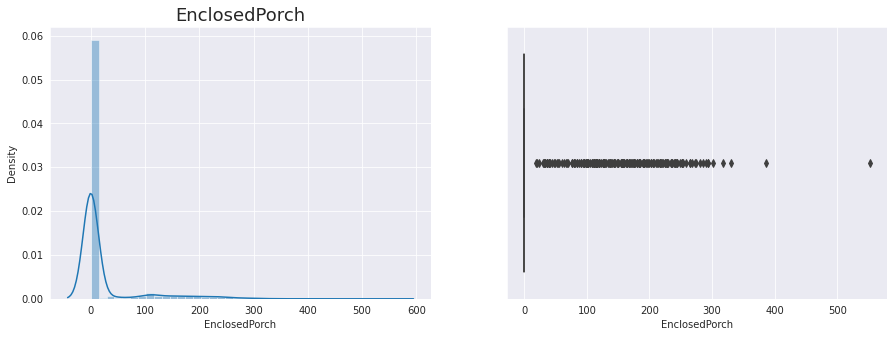

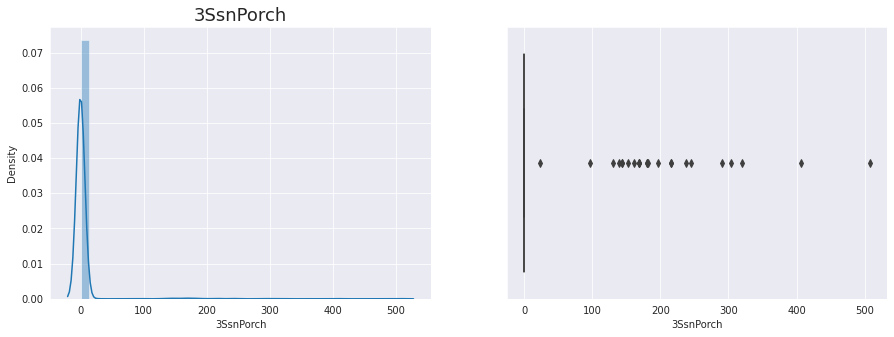

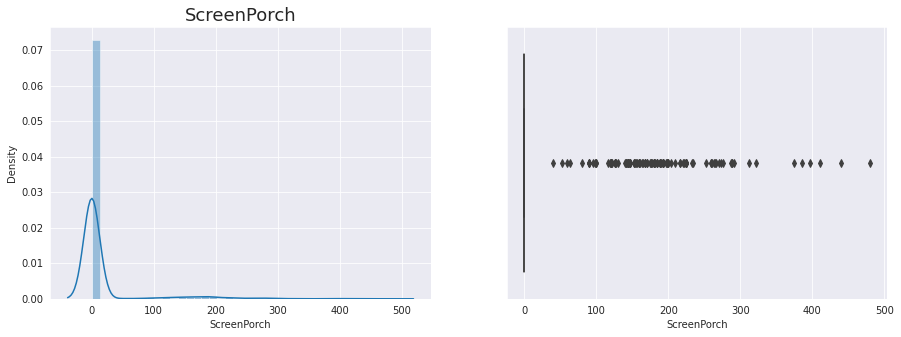

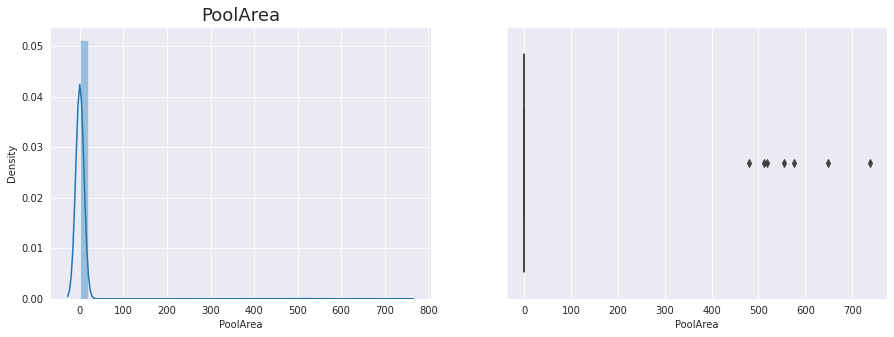

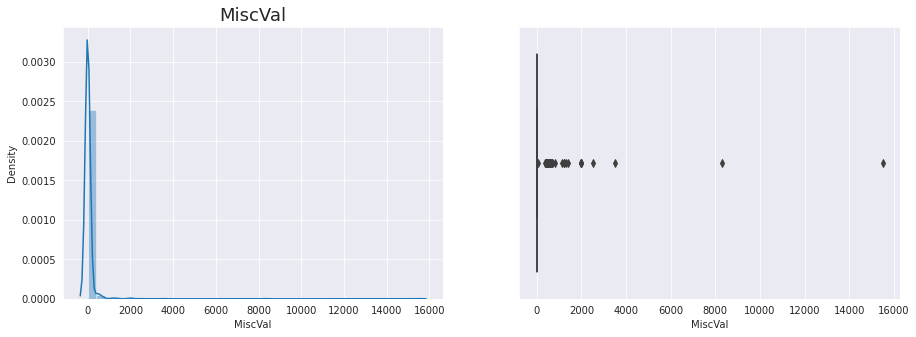

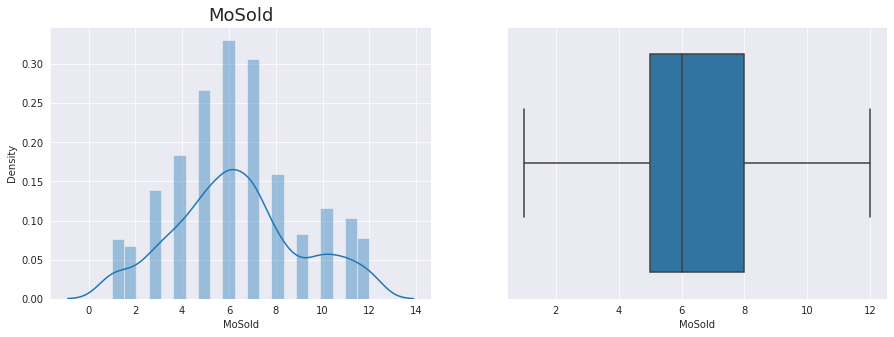

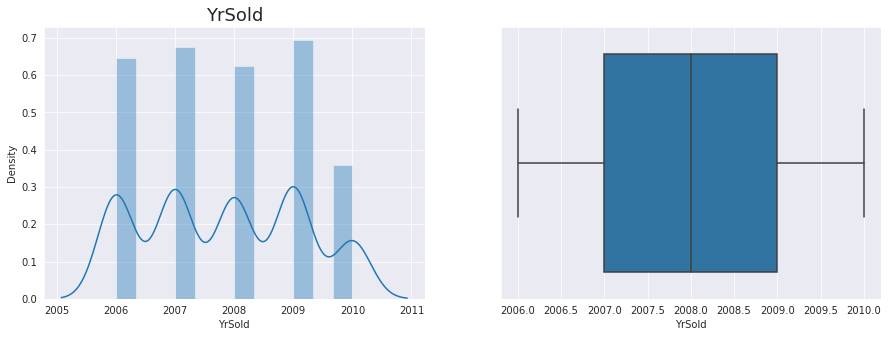

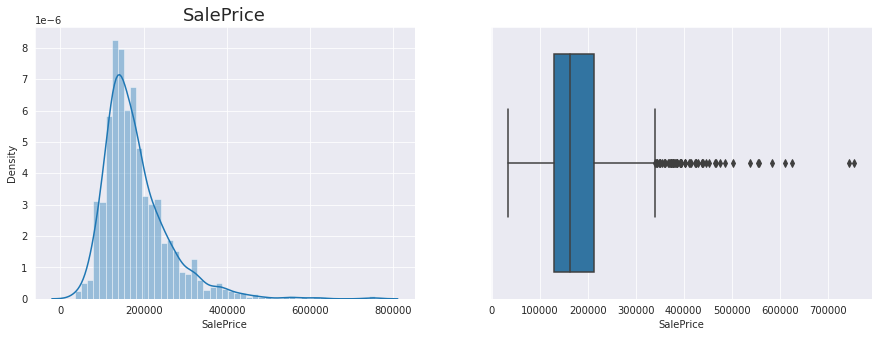

In [782]:
numerical_columns = housing.select_dtypes(include=['number']).columns

for col in numerical_columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(housing[col])
    plt.subplot(1,2,2)
    sns.boxplot(housing[col])
    plt.show() 

Most numerical columns have outliers.

### Visualise categorical columns

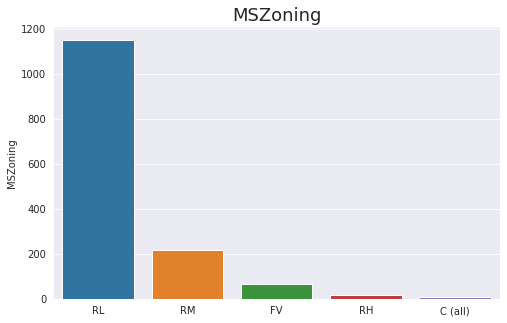

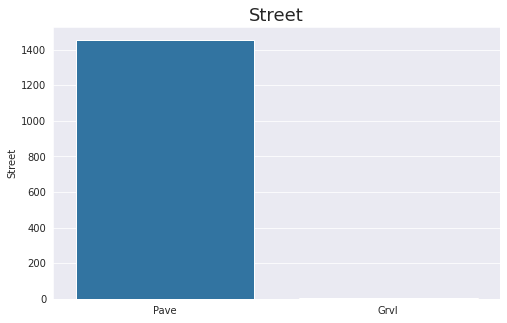

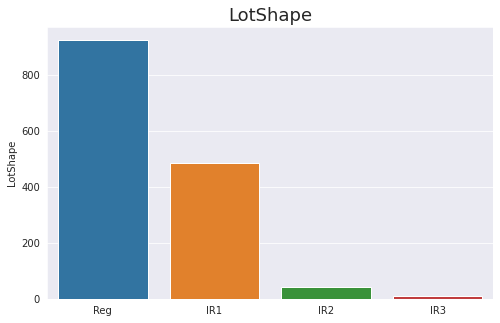

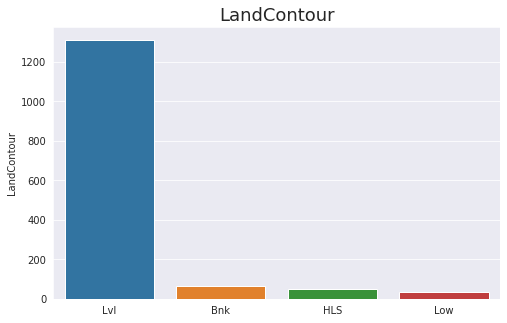

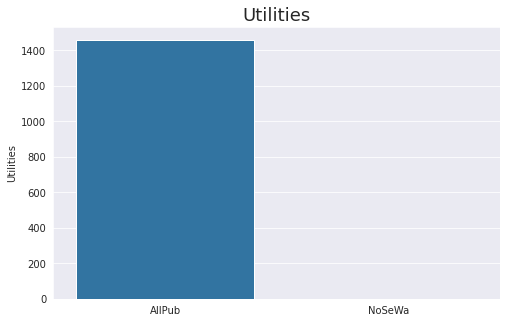

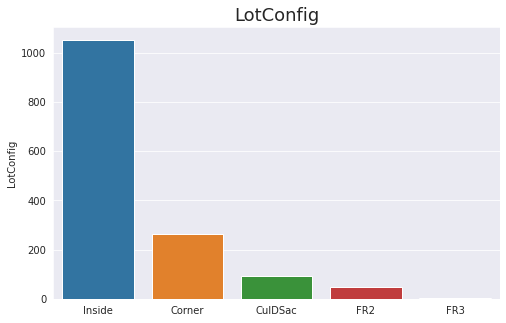

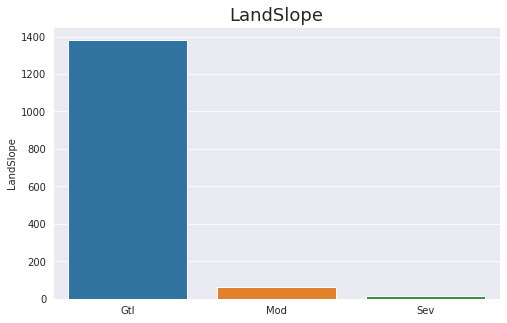

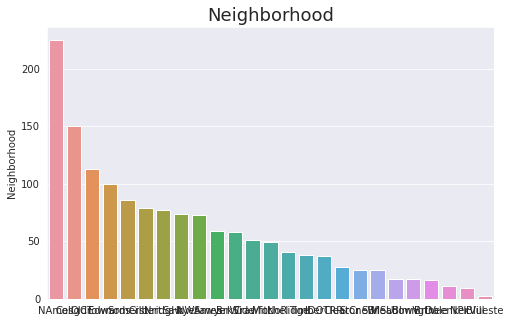

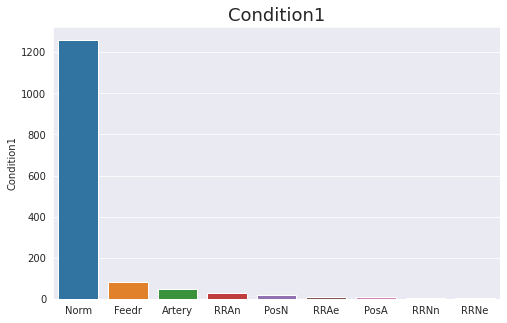

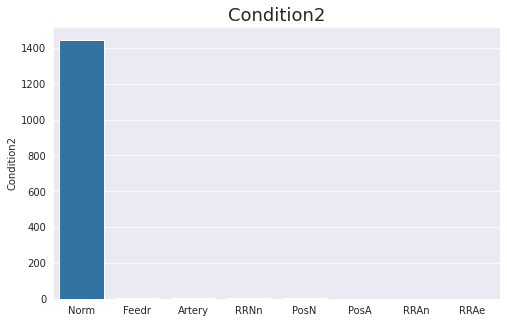

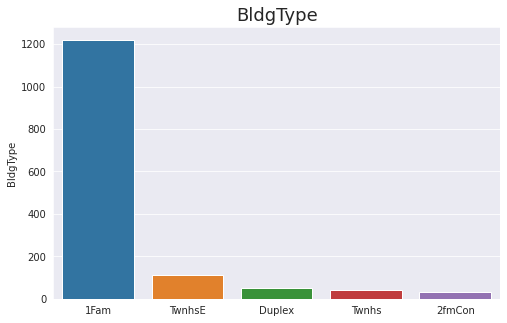

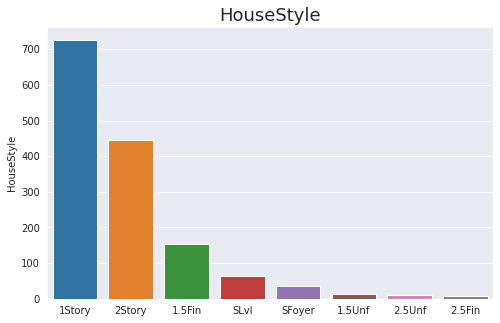

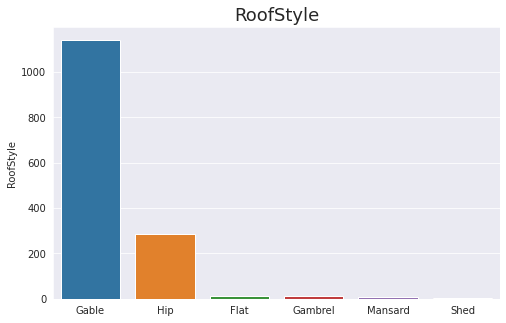

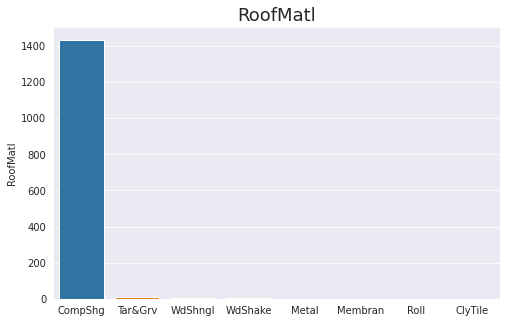

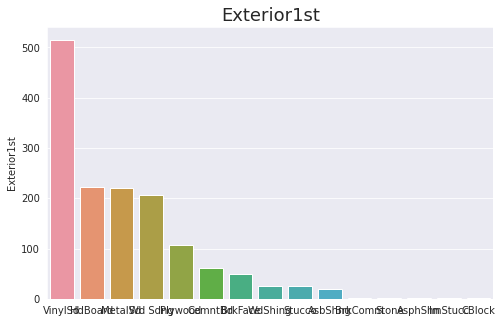

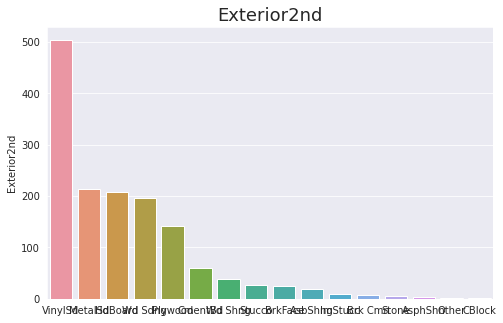

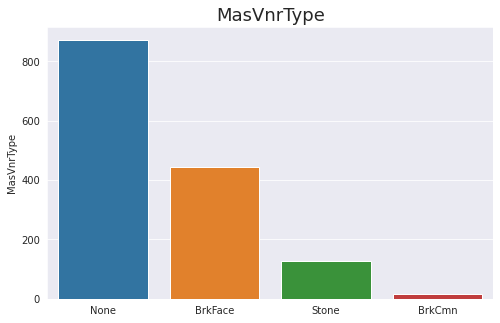

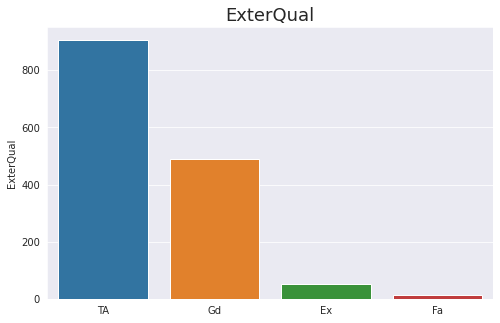

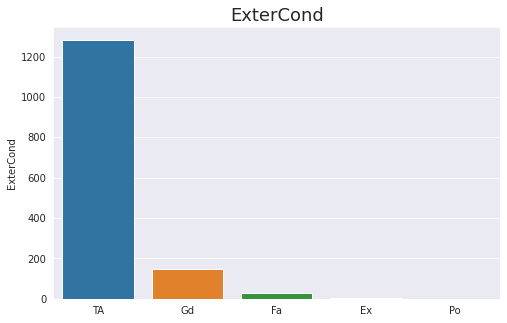

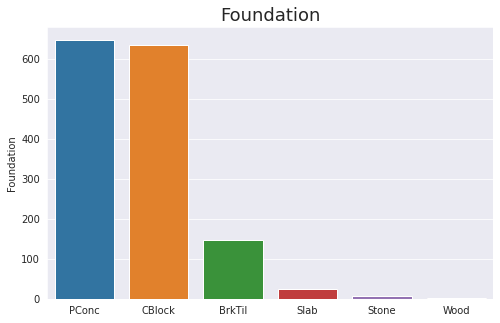

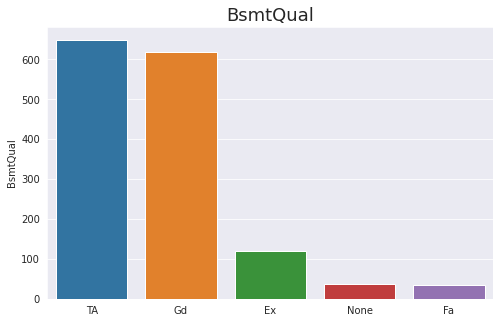

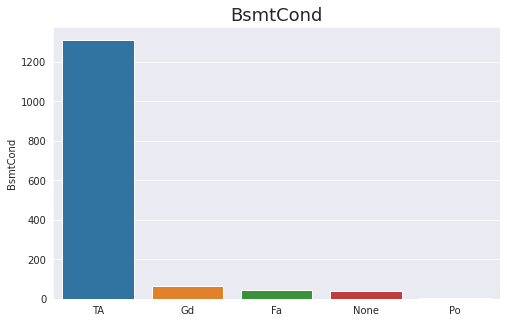

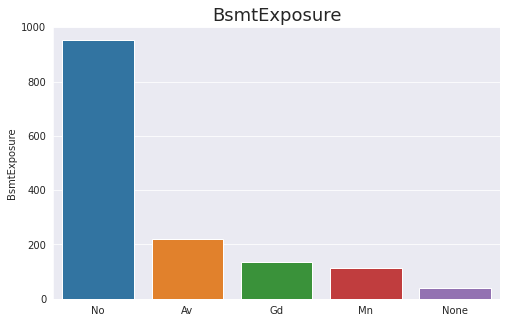

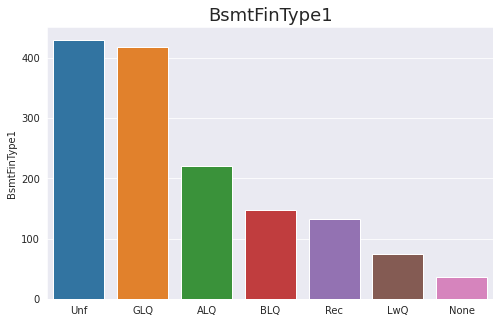

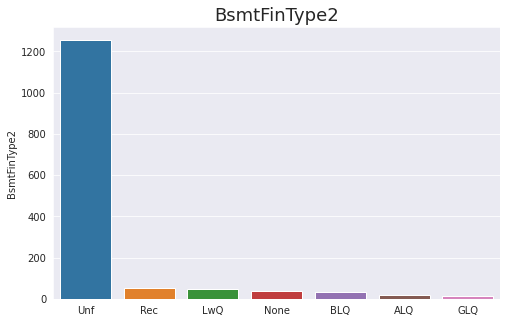

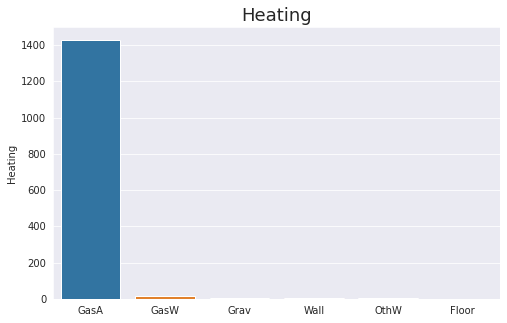

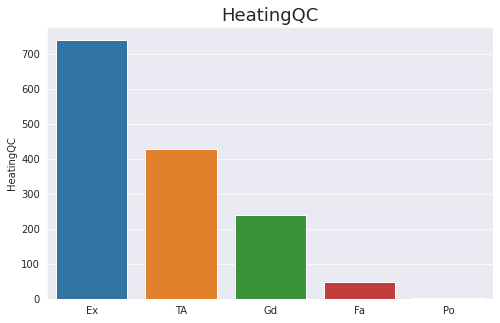

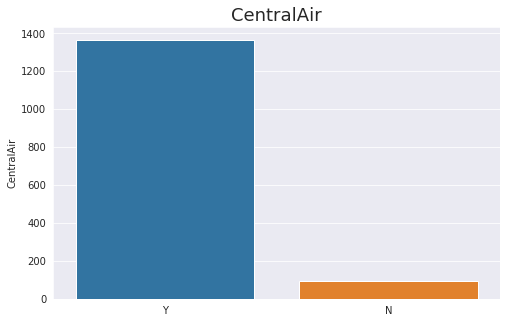

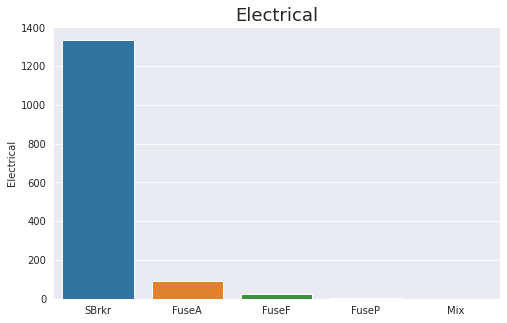

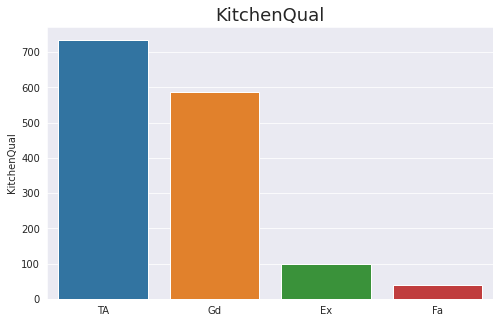

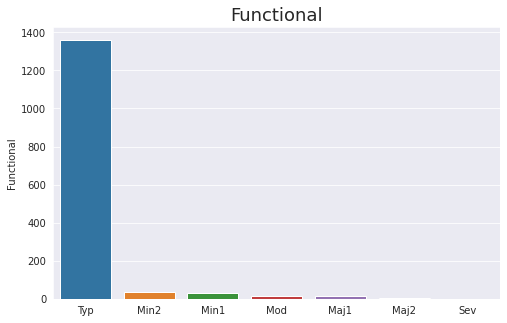

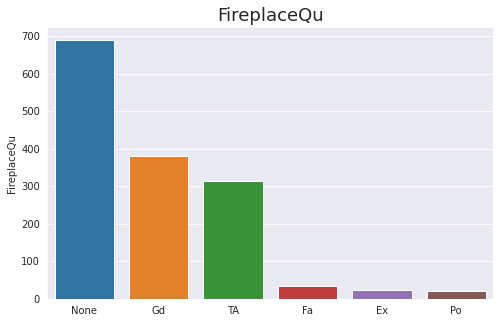

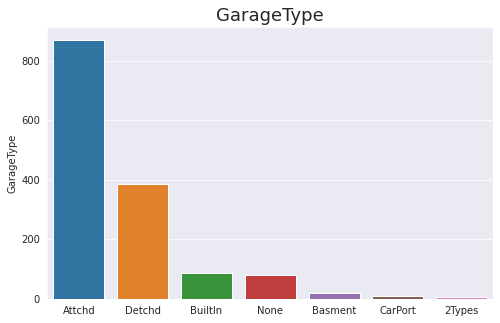

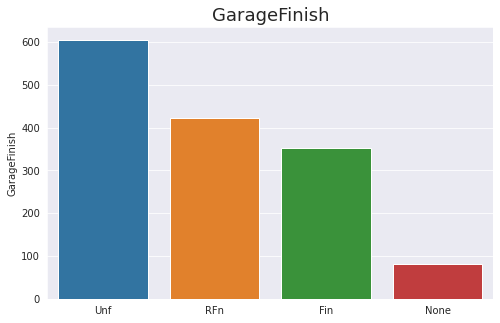

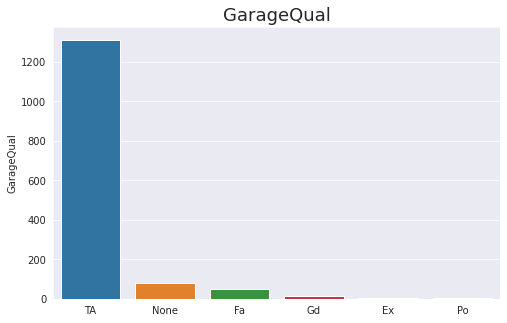

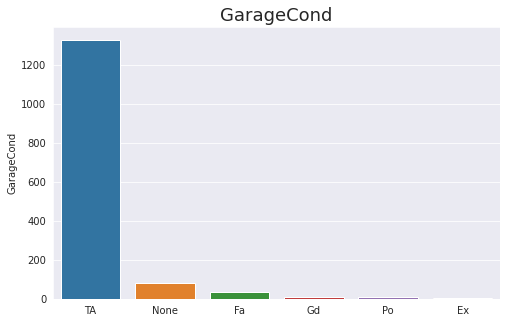

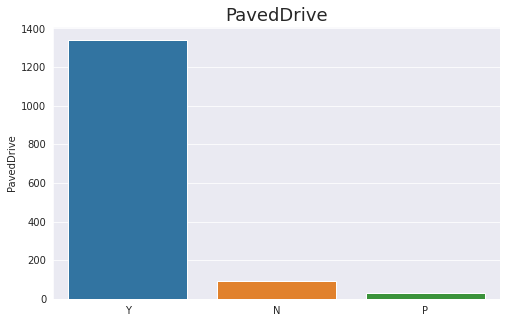

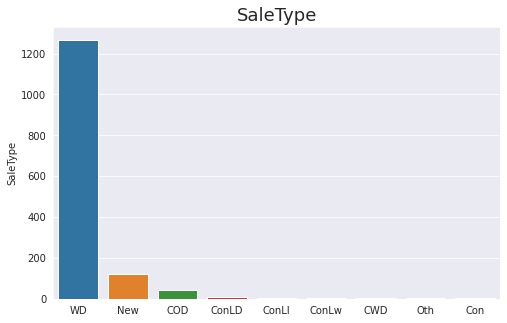

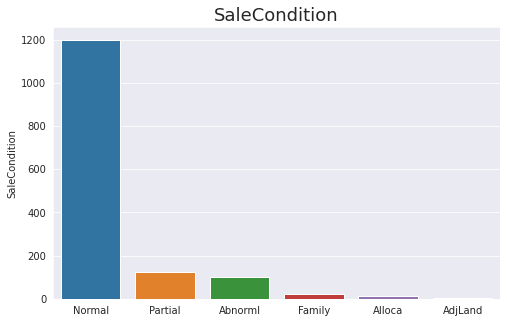

In [783]:
cat_columns = housing.select_dtypes(include=['object']).columns
for col in cat_columns:
    plt.figure(figsize=(8,5))
    plt.title(col, fontdict={'fontsize': 18})
    sns.barplot(housing[col].value_counts().index, housing[col].value_counts())
    plt.show()

Inference - Values of categorical columns are distributed across multiple categories. Cannot remove any columns.

In [784]:
housing['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

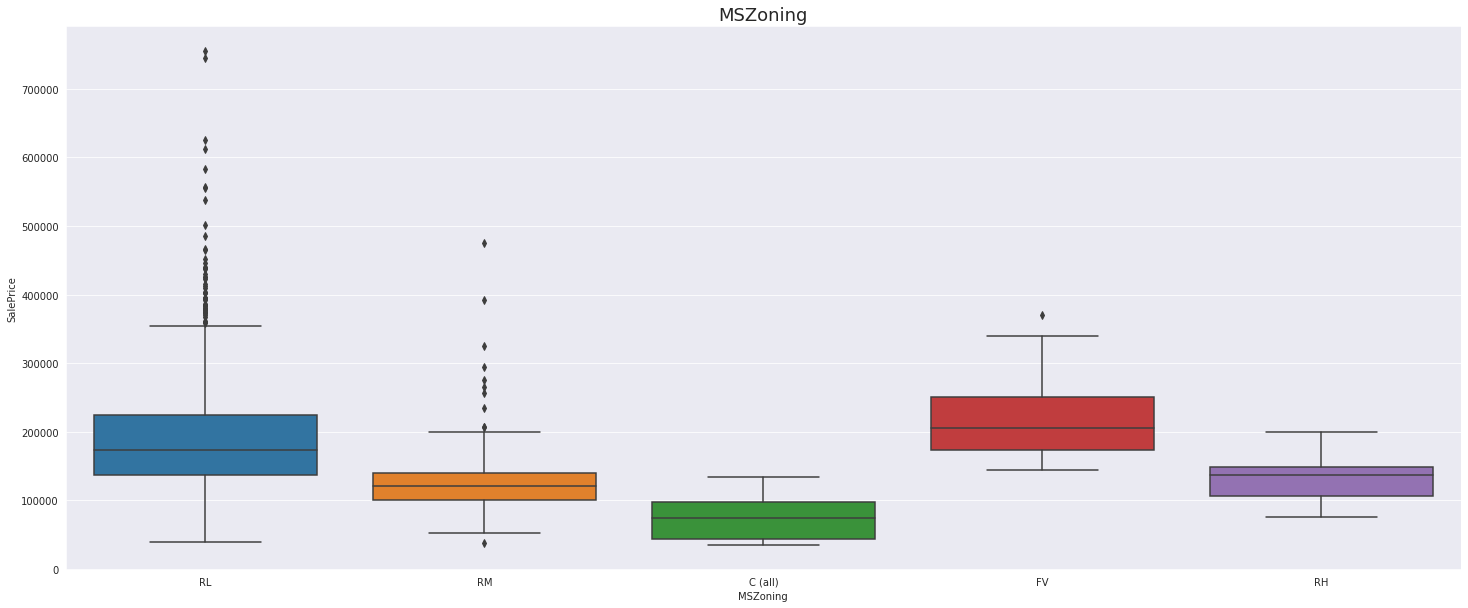

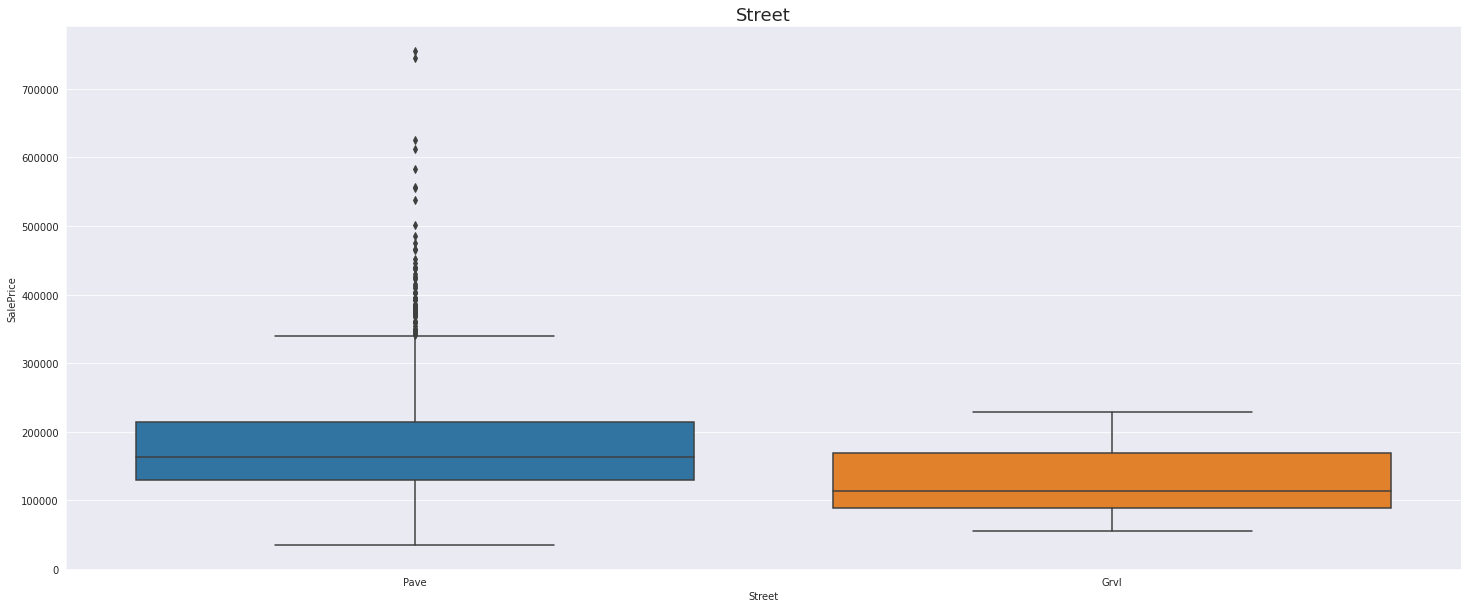

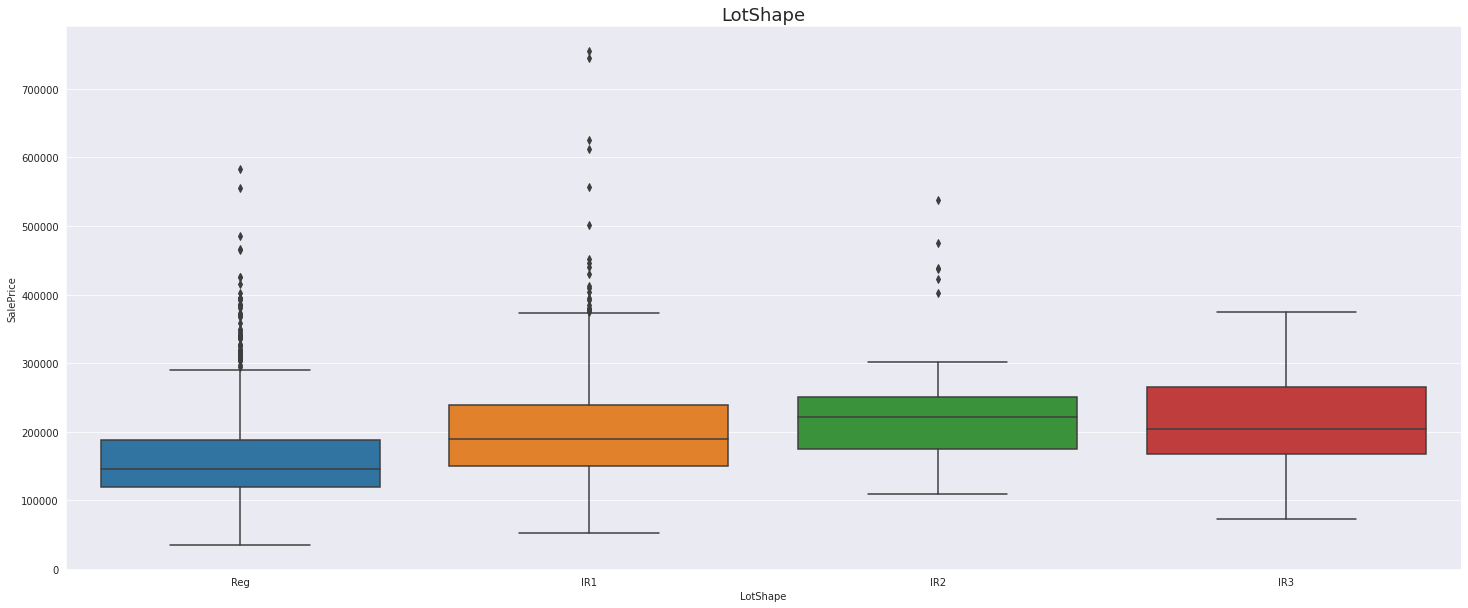

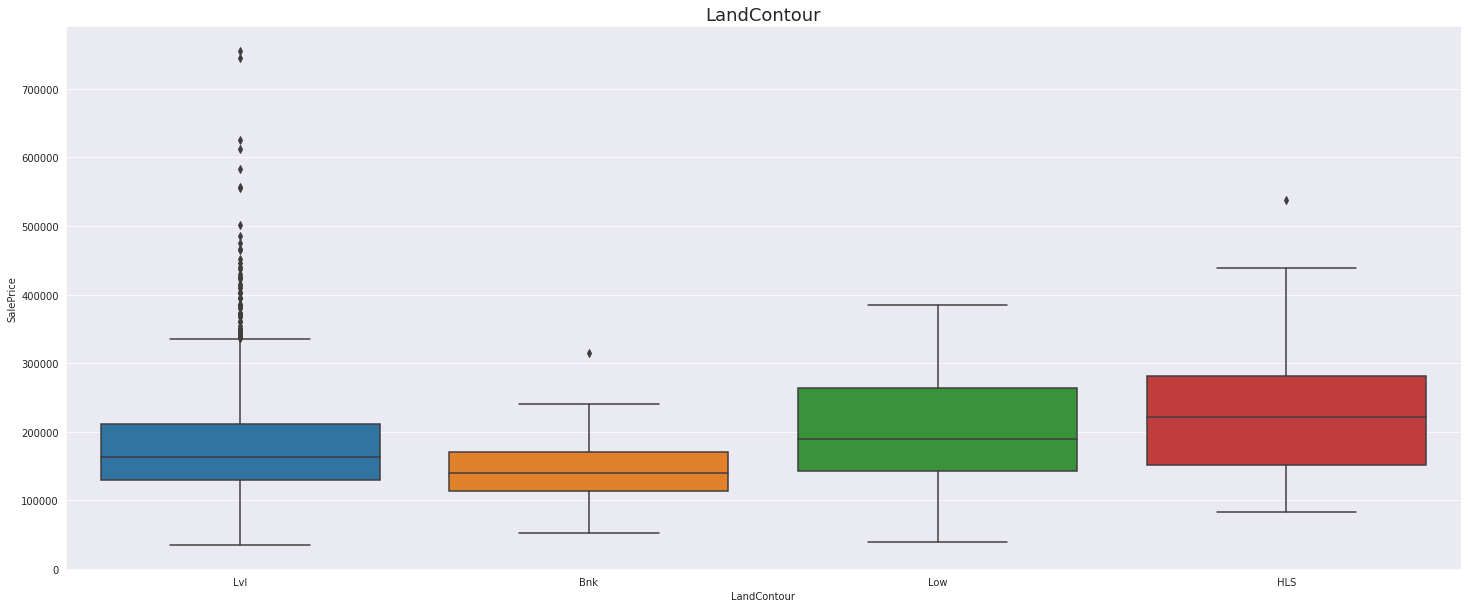

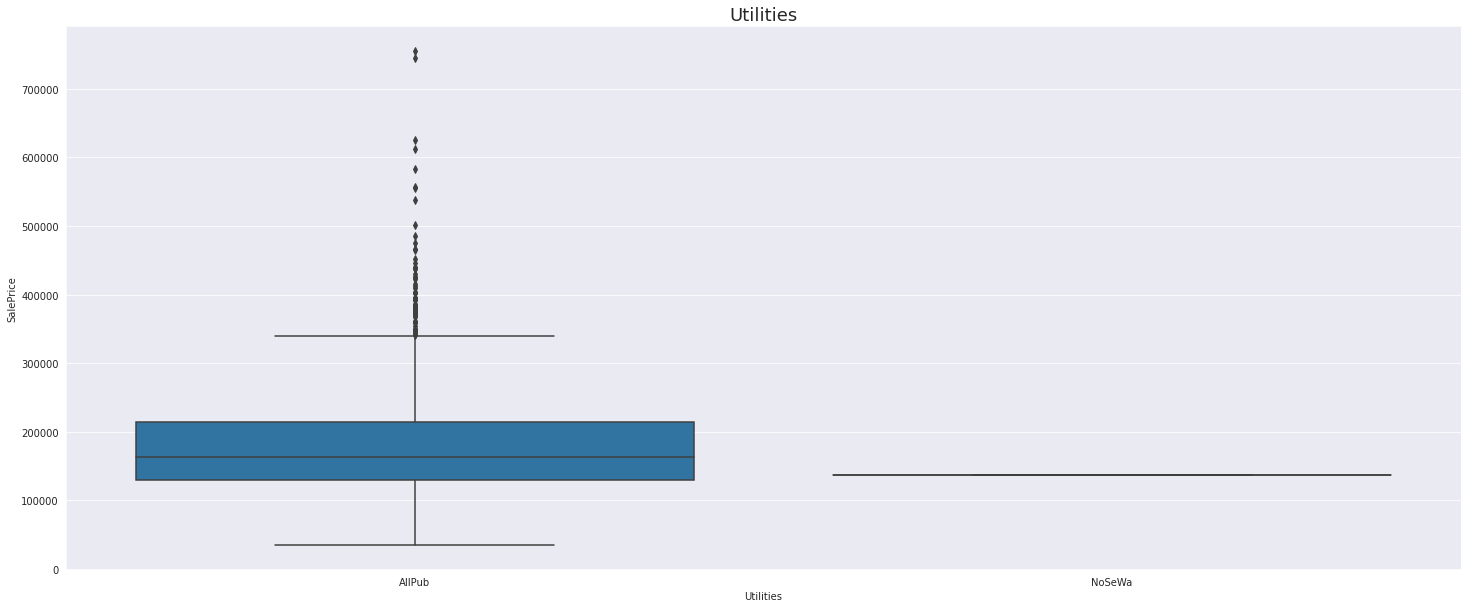

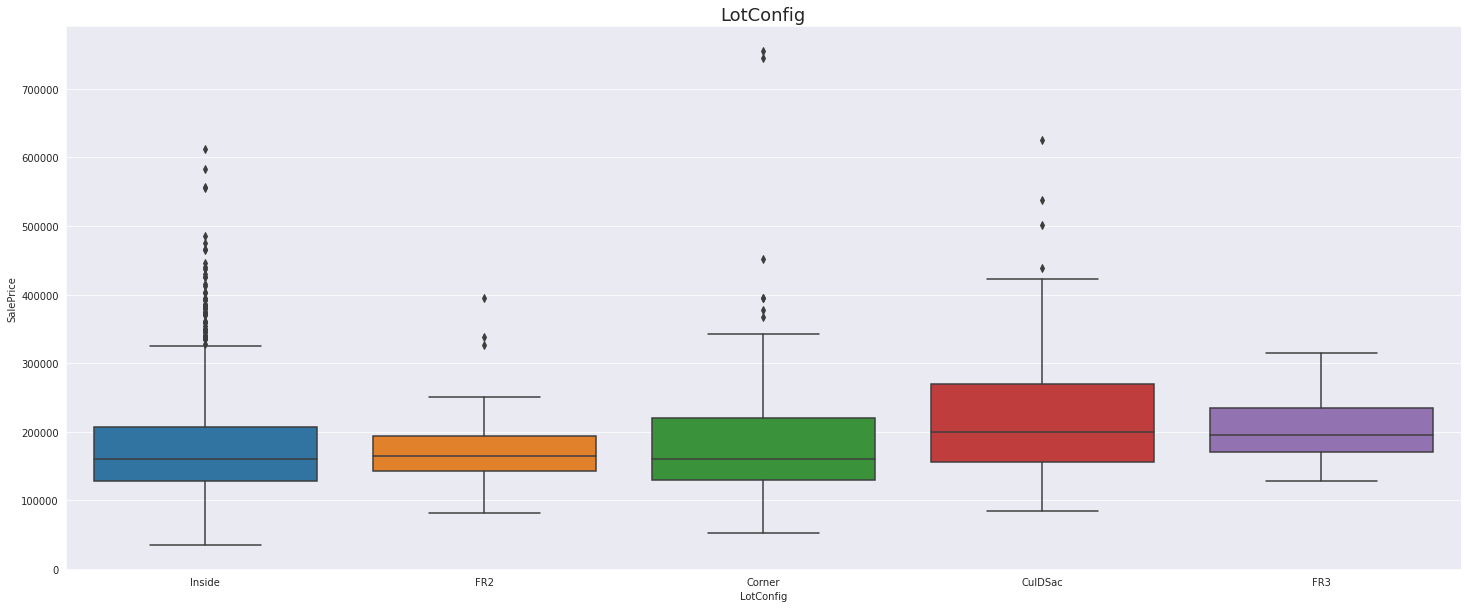

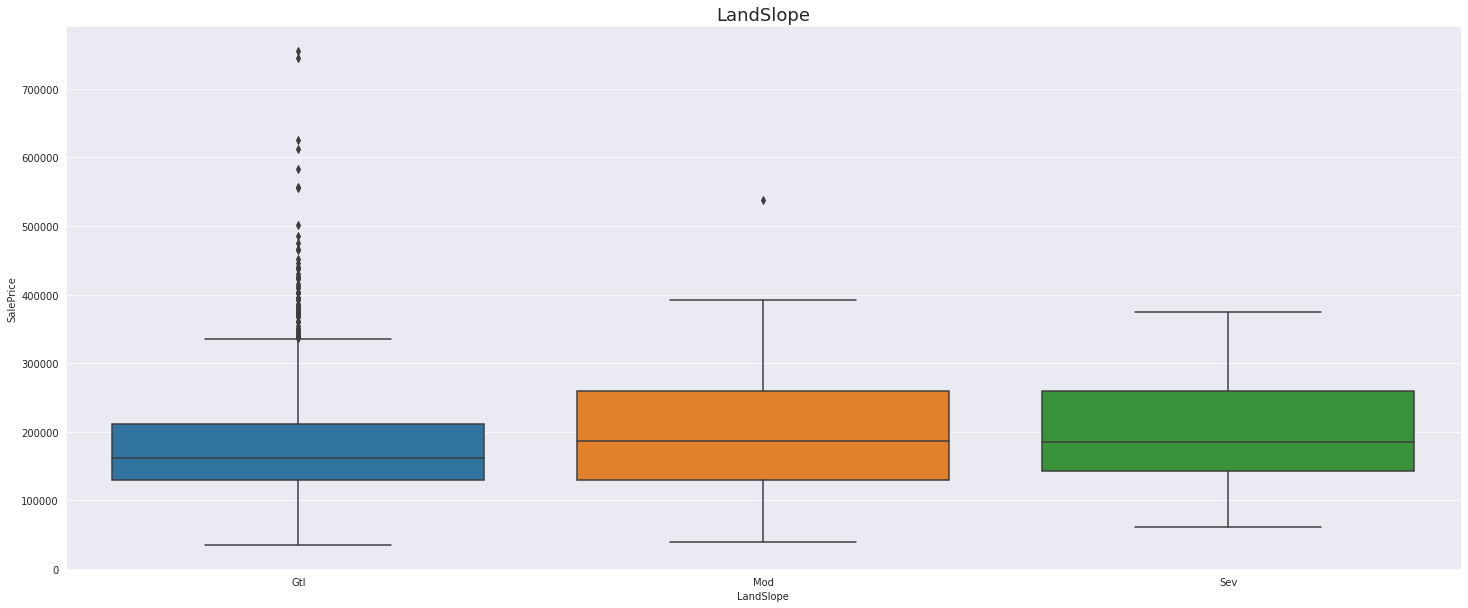

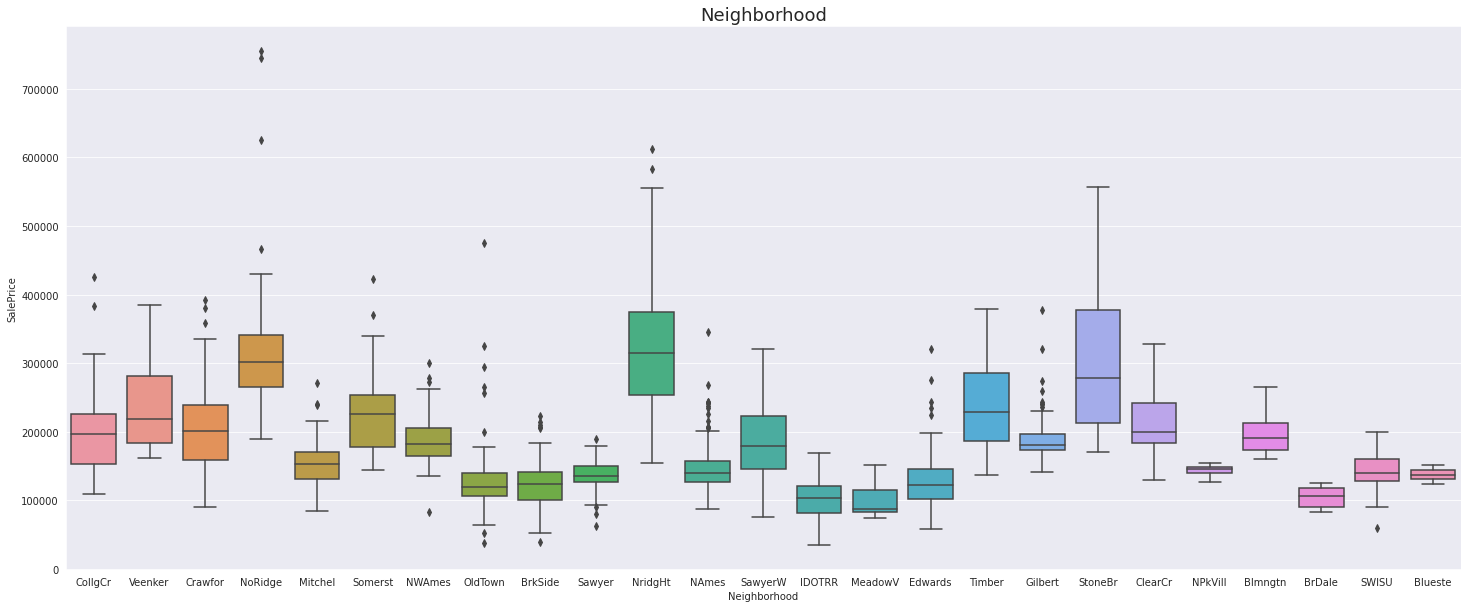

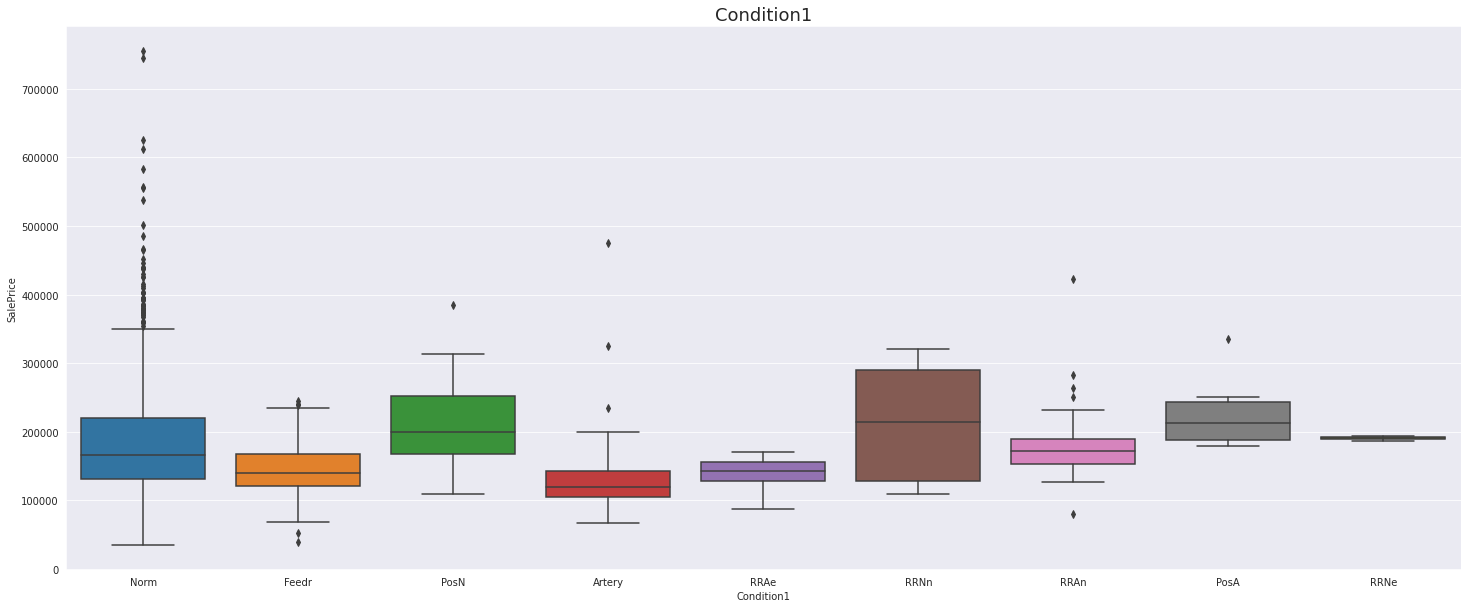

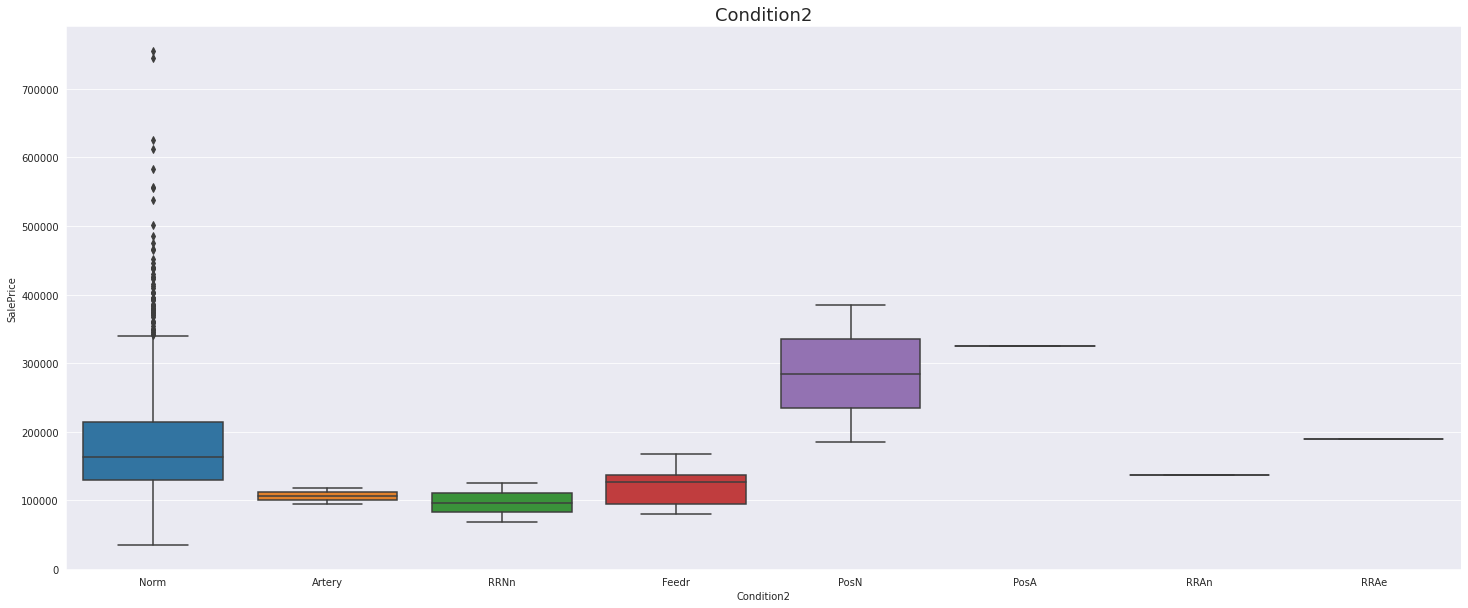

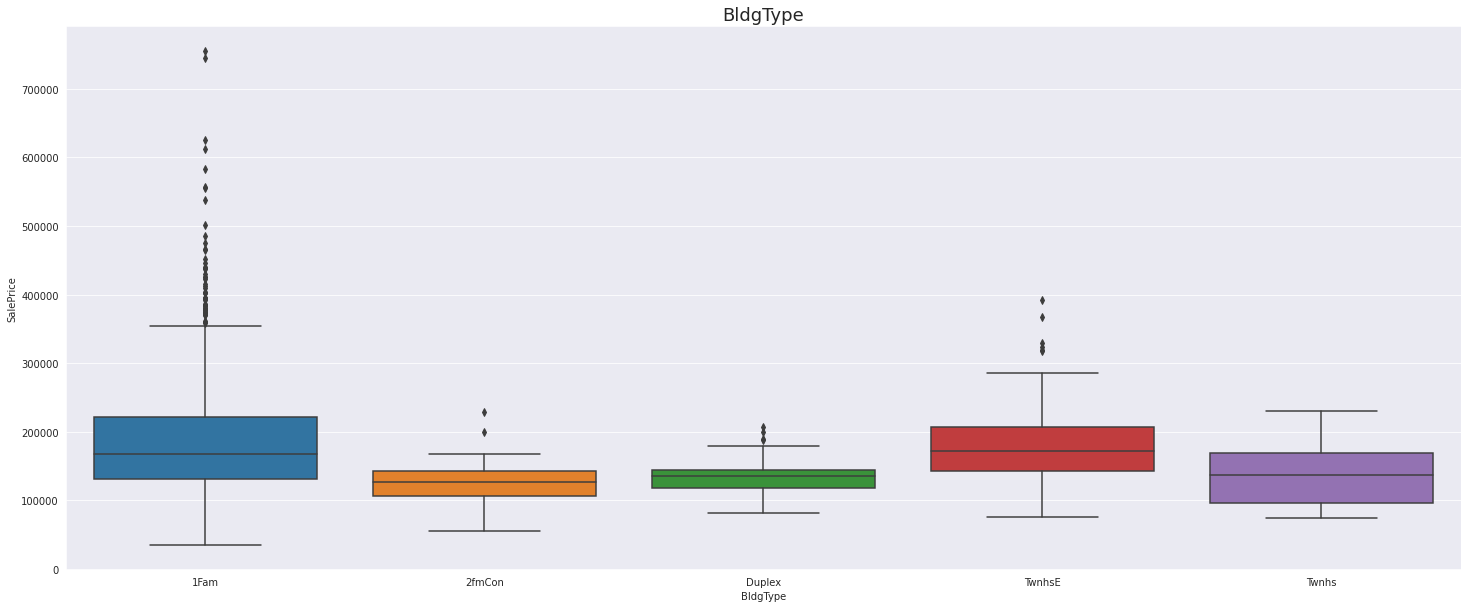

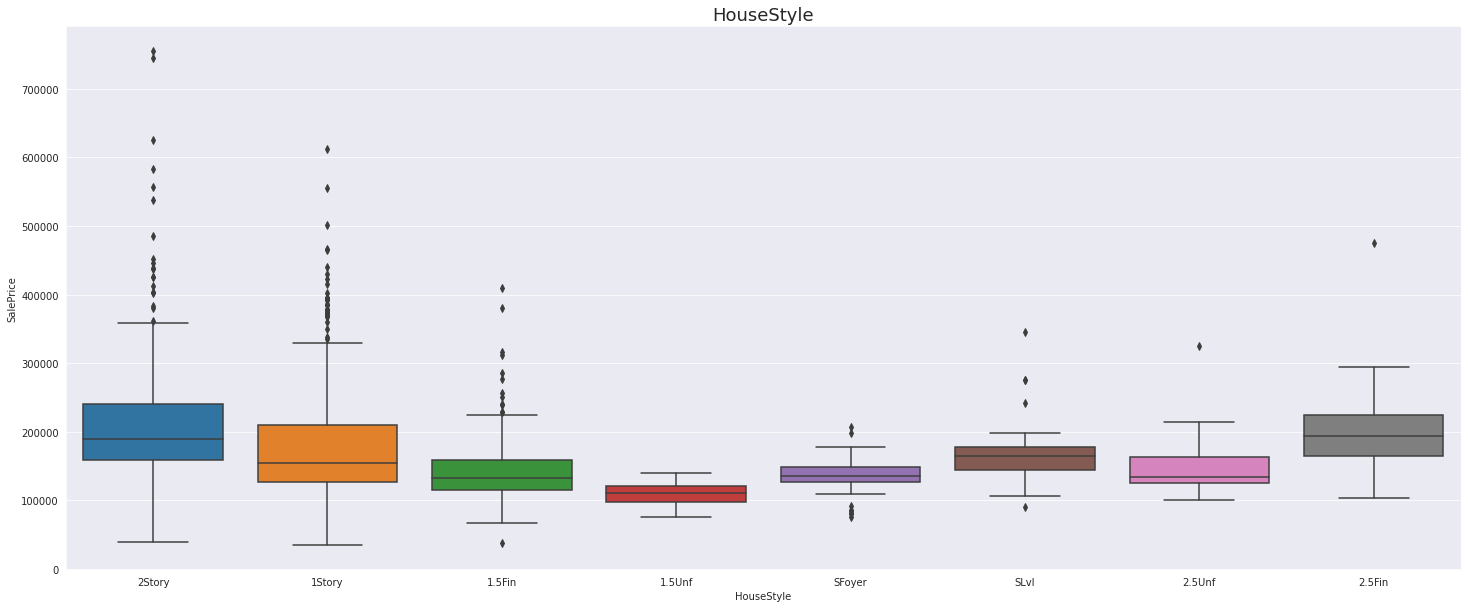

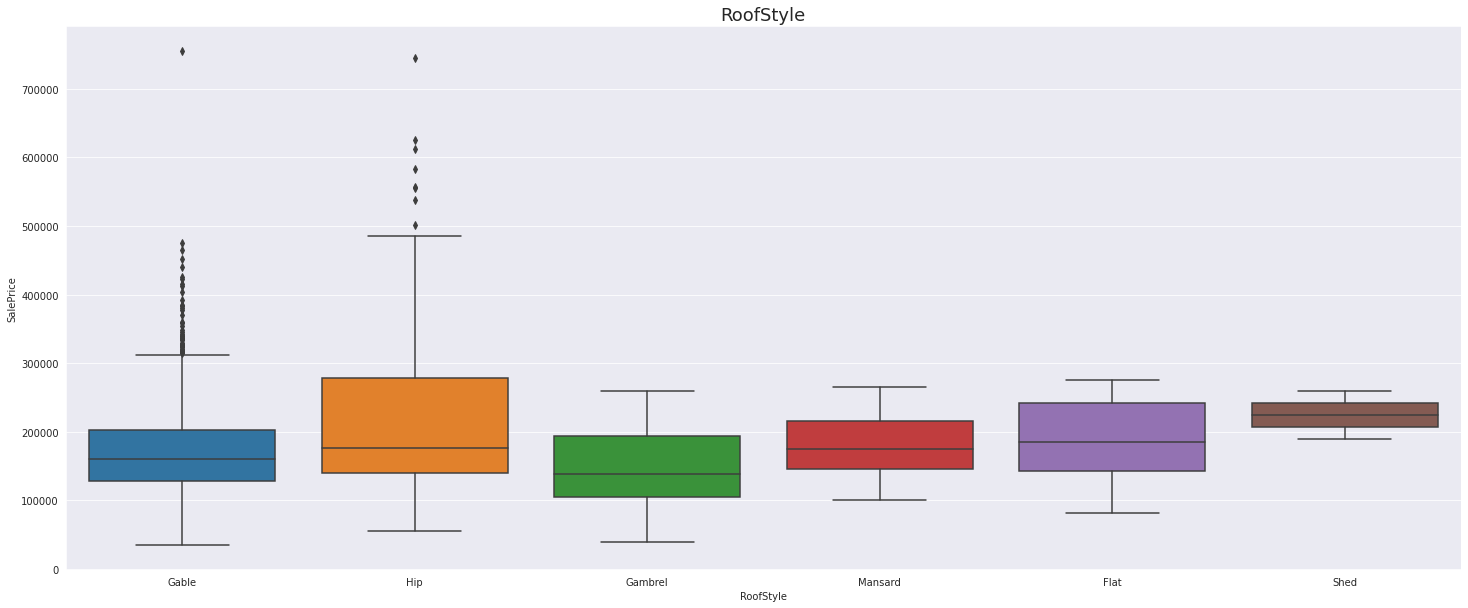

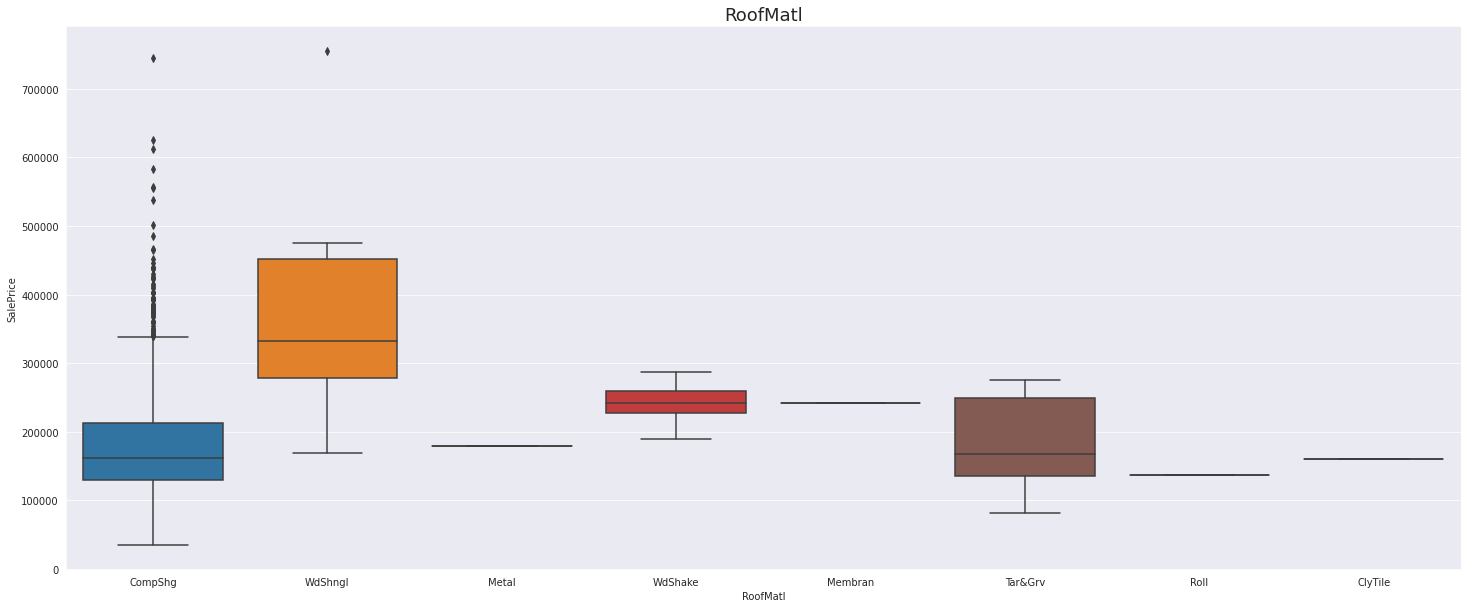

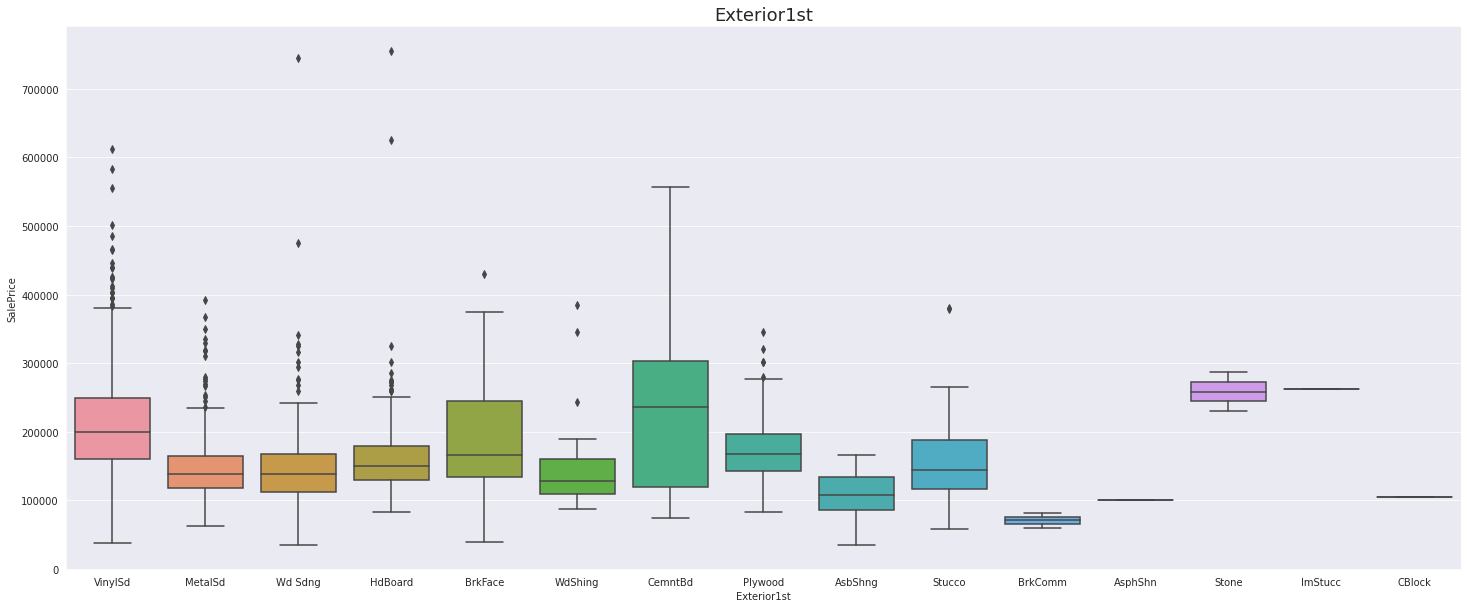

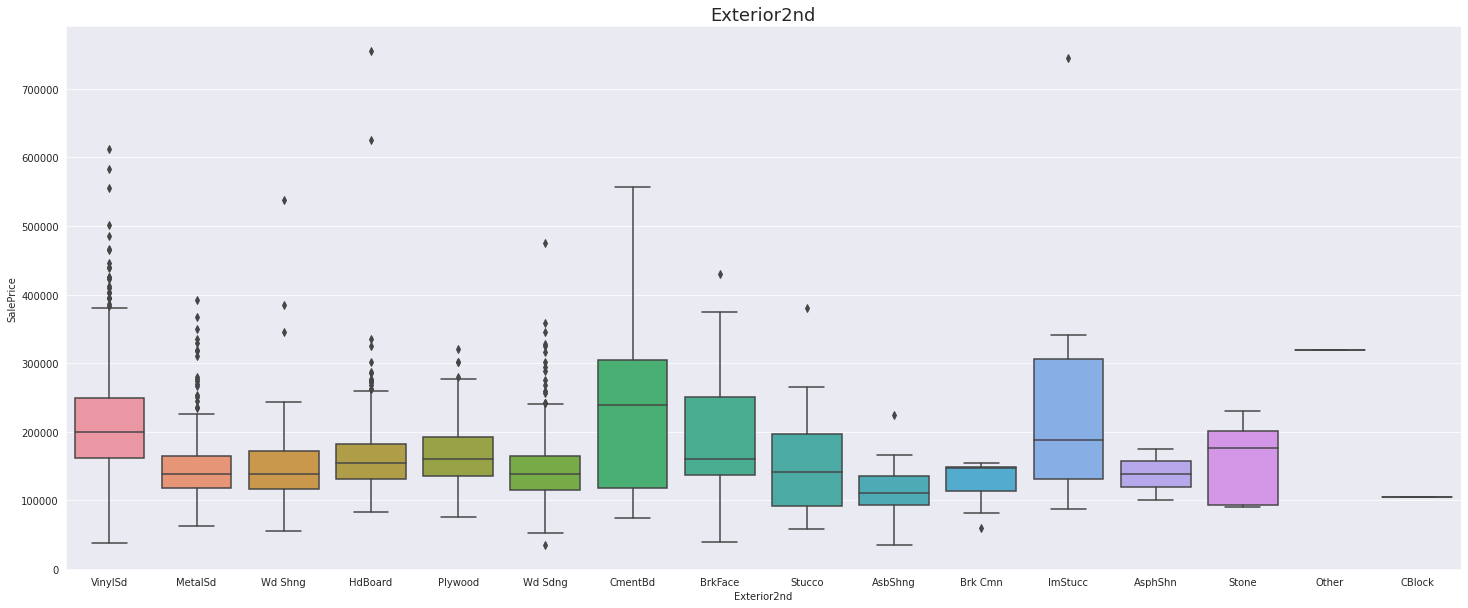

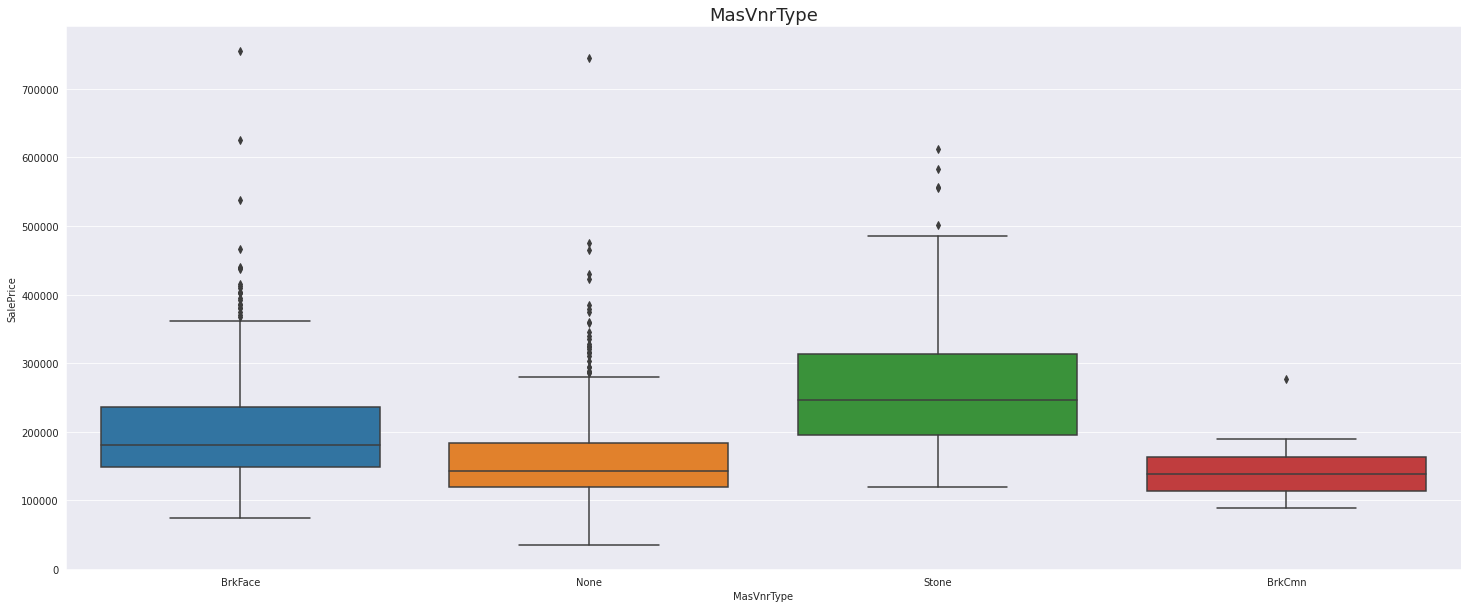

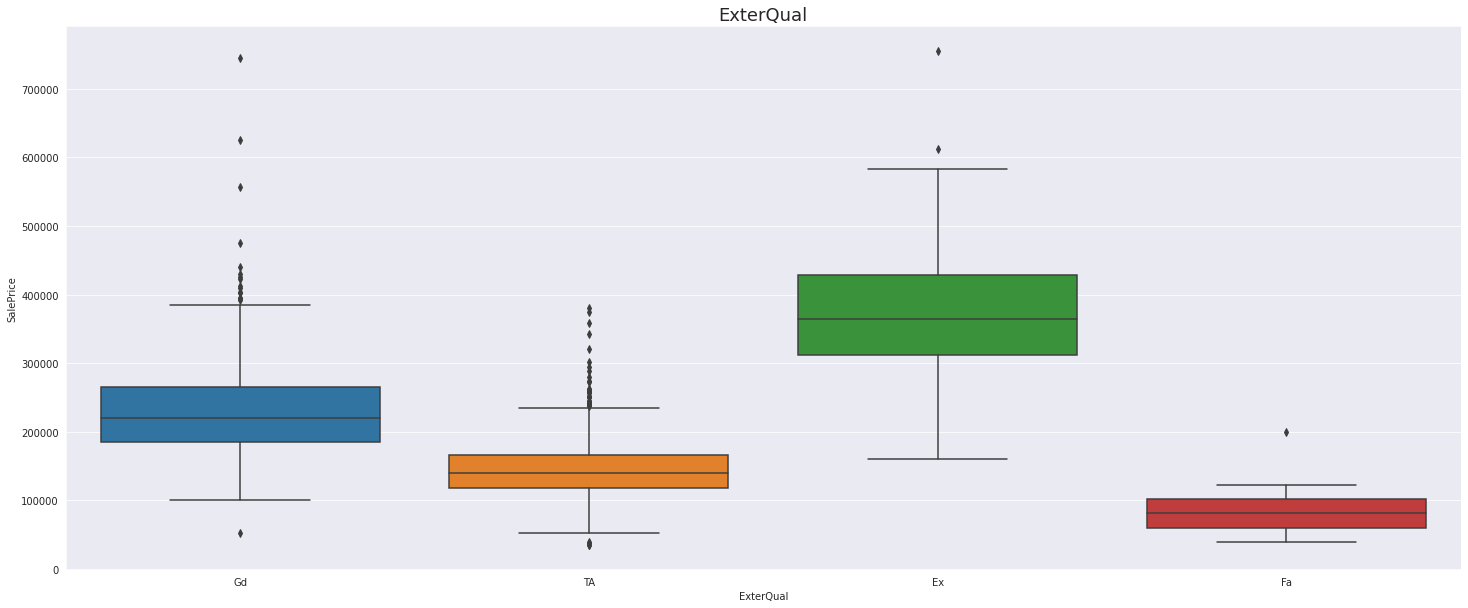

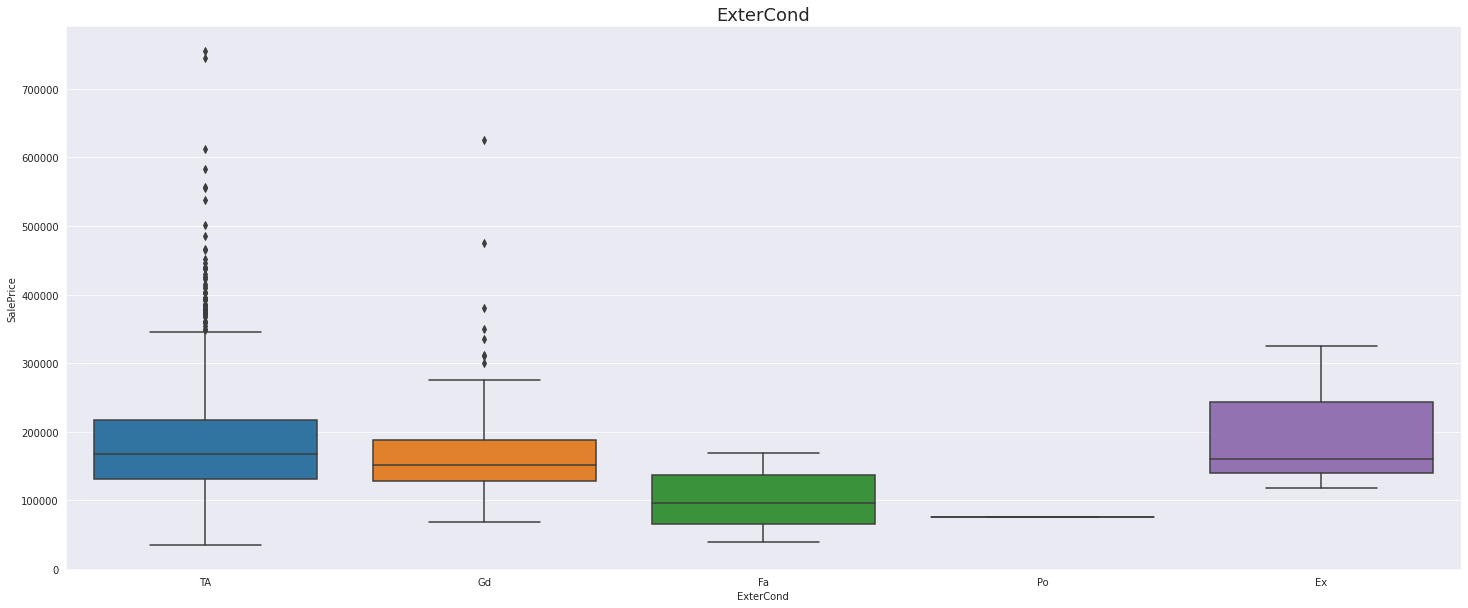

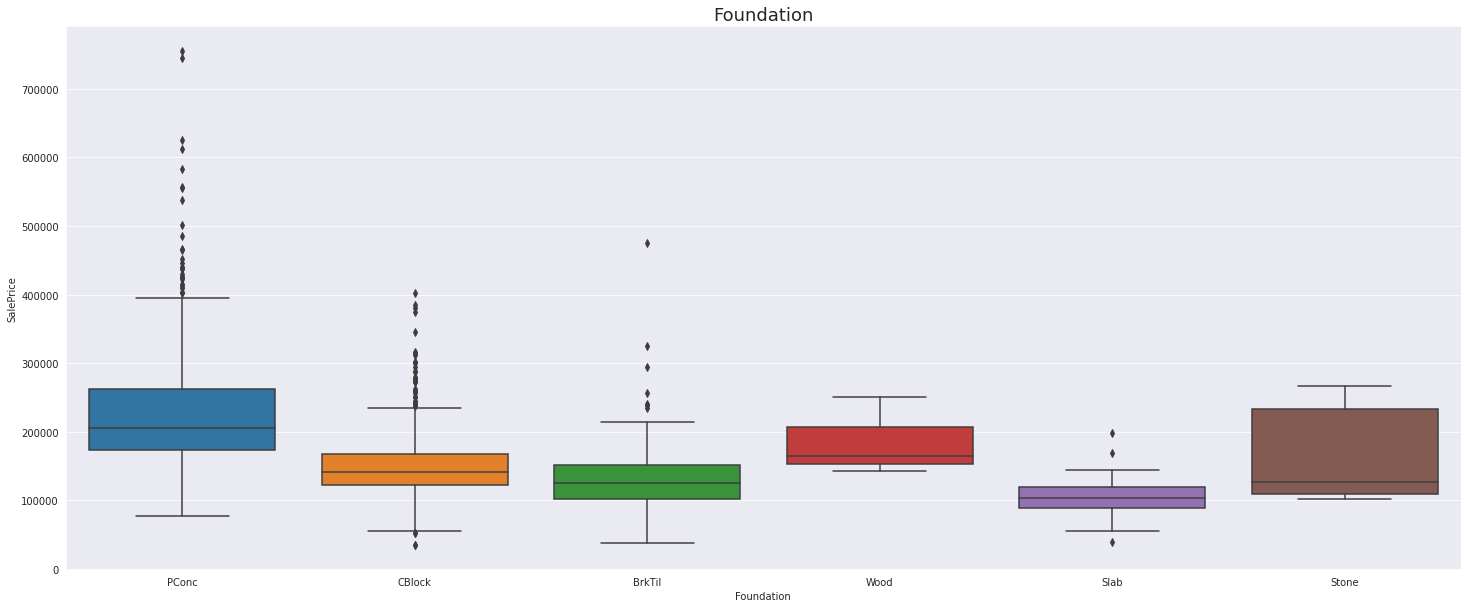

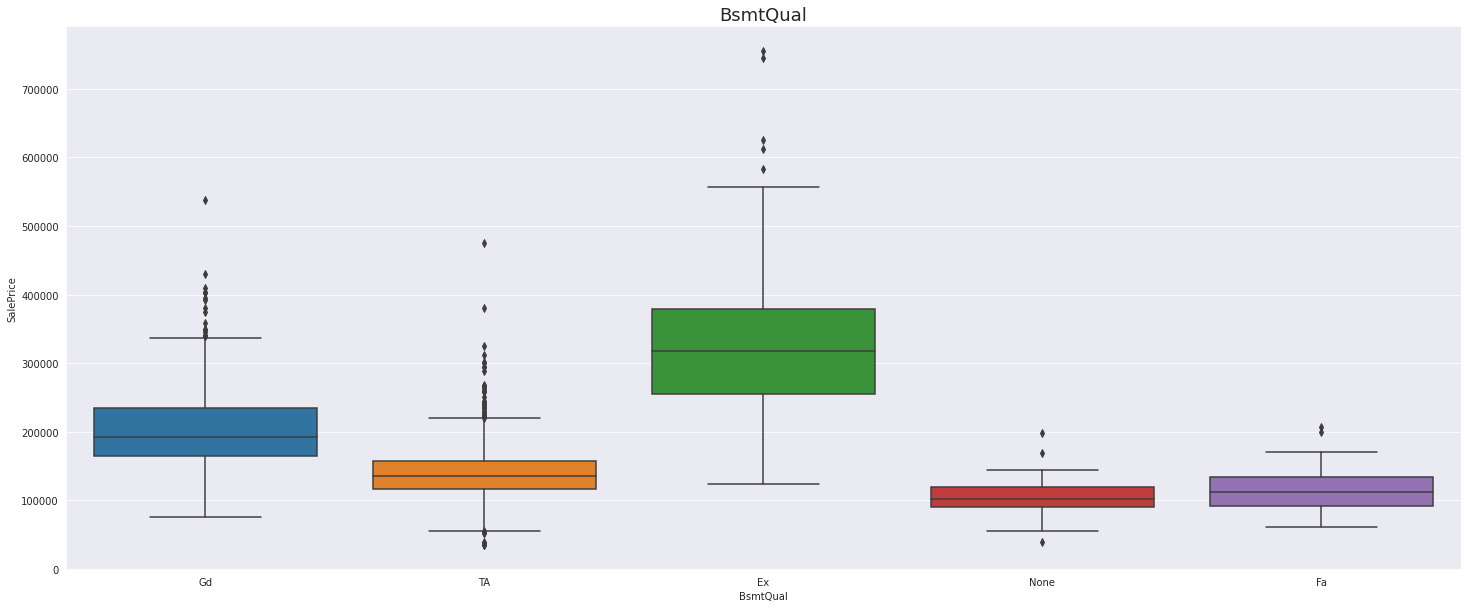

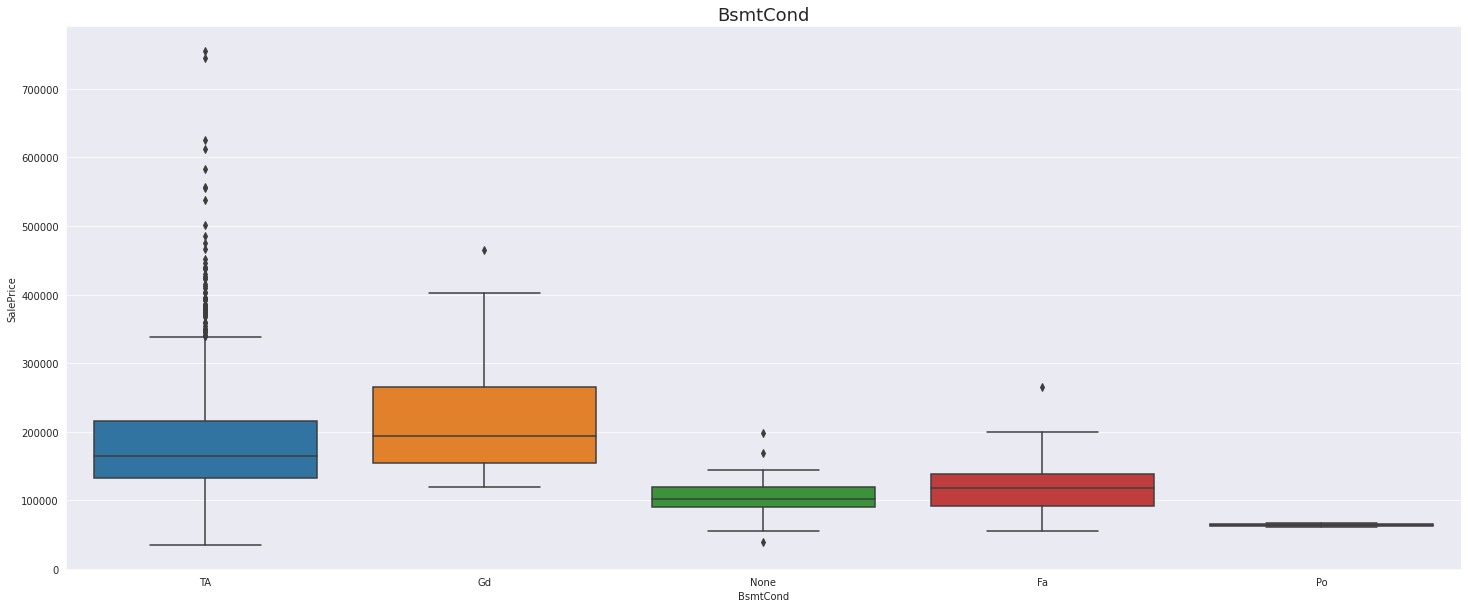

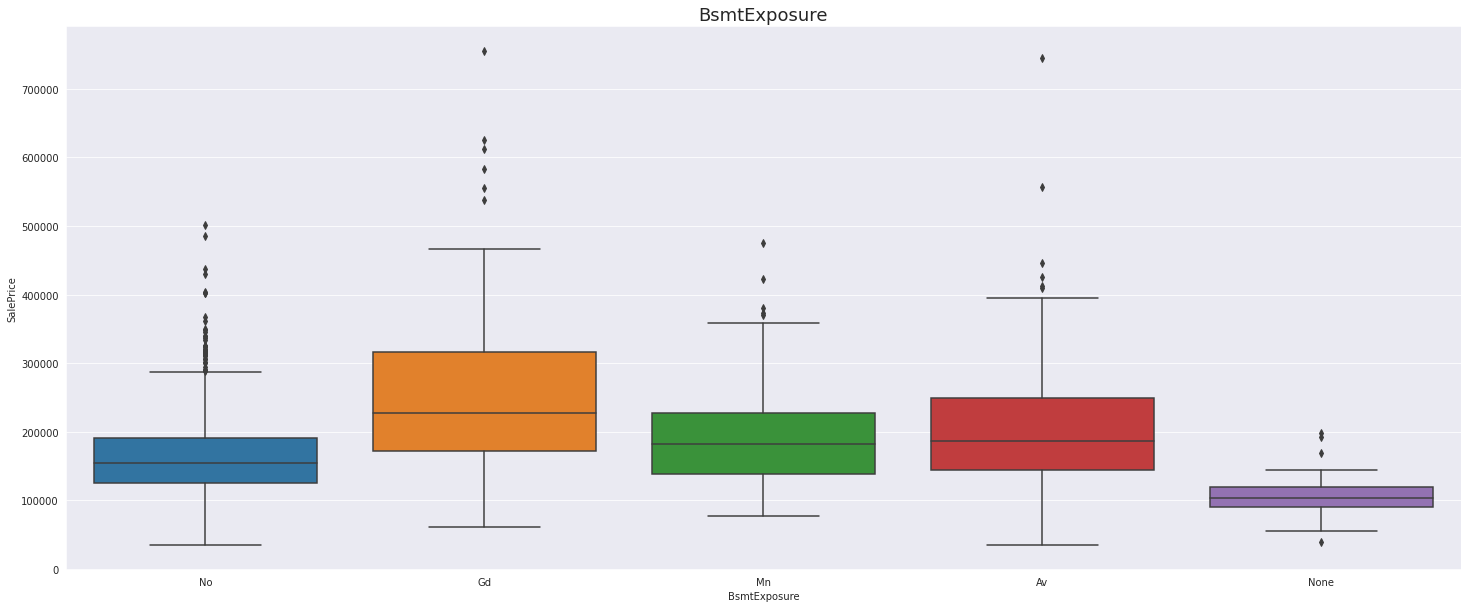

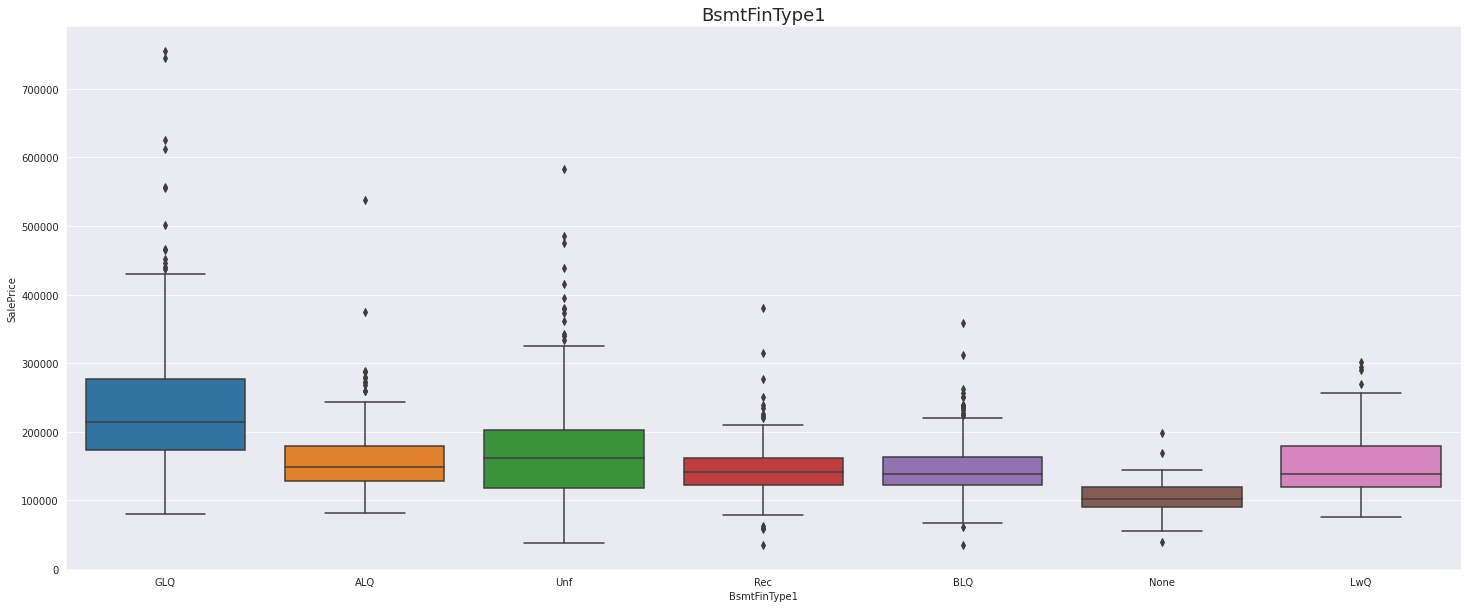

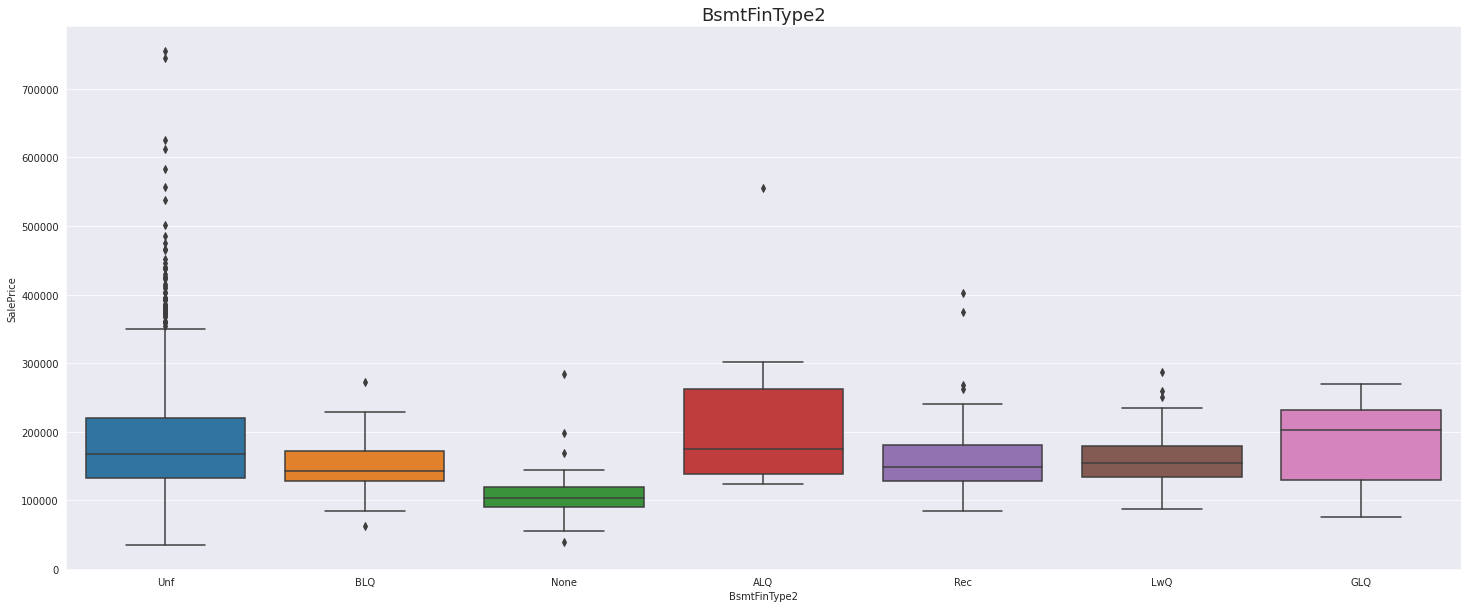

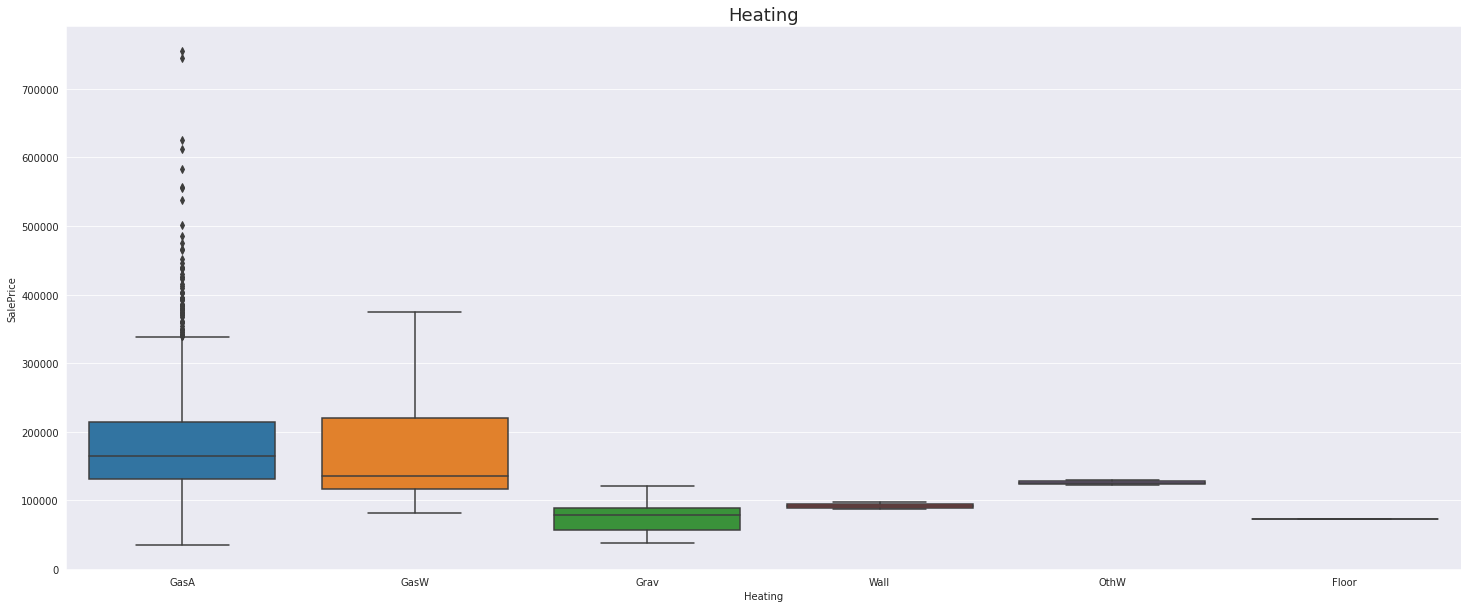

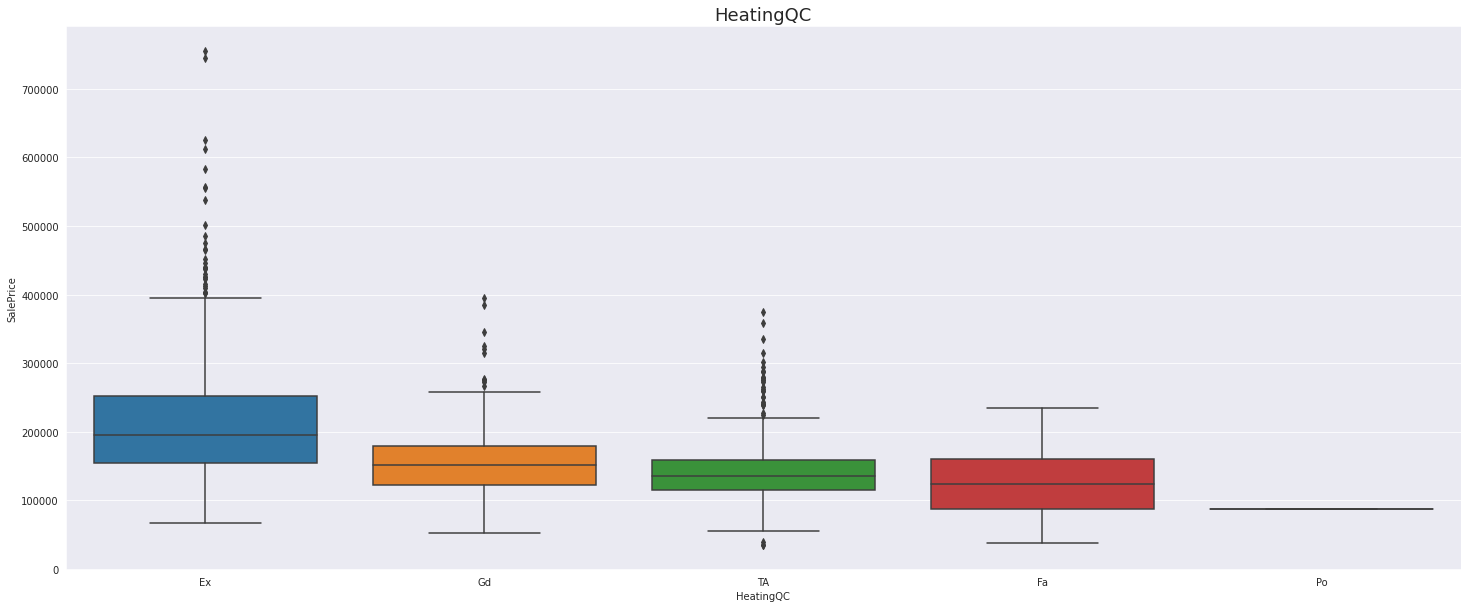

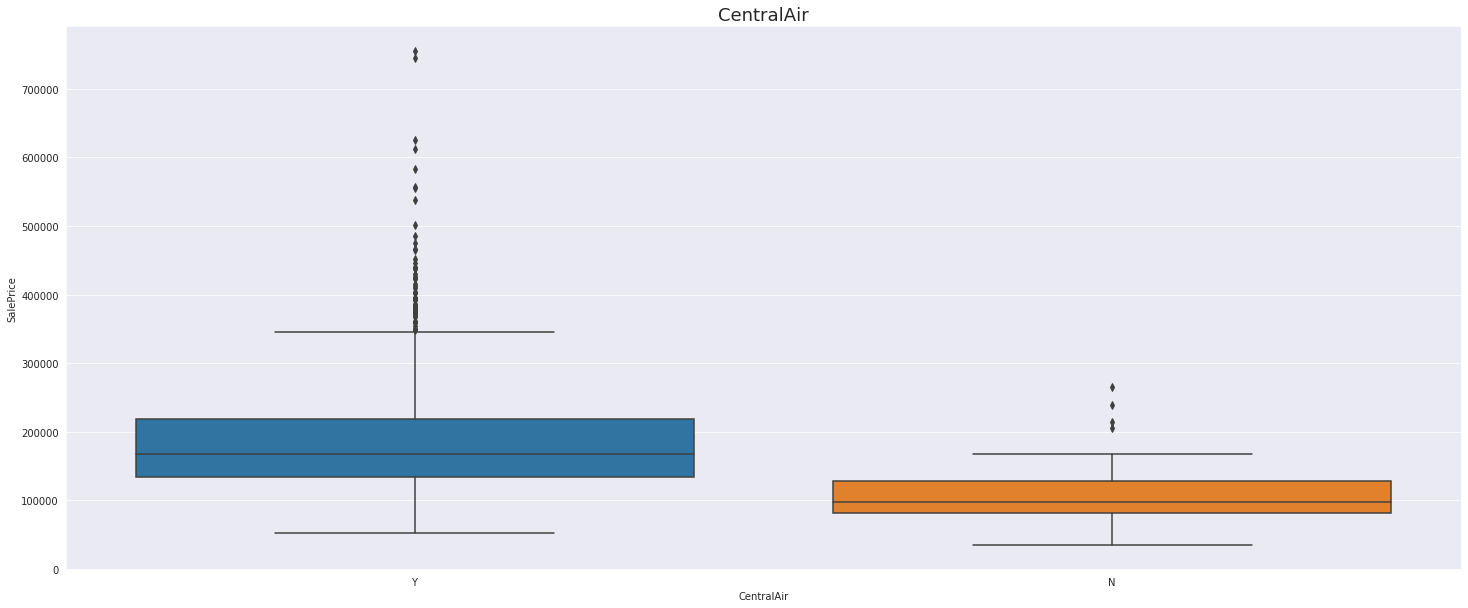

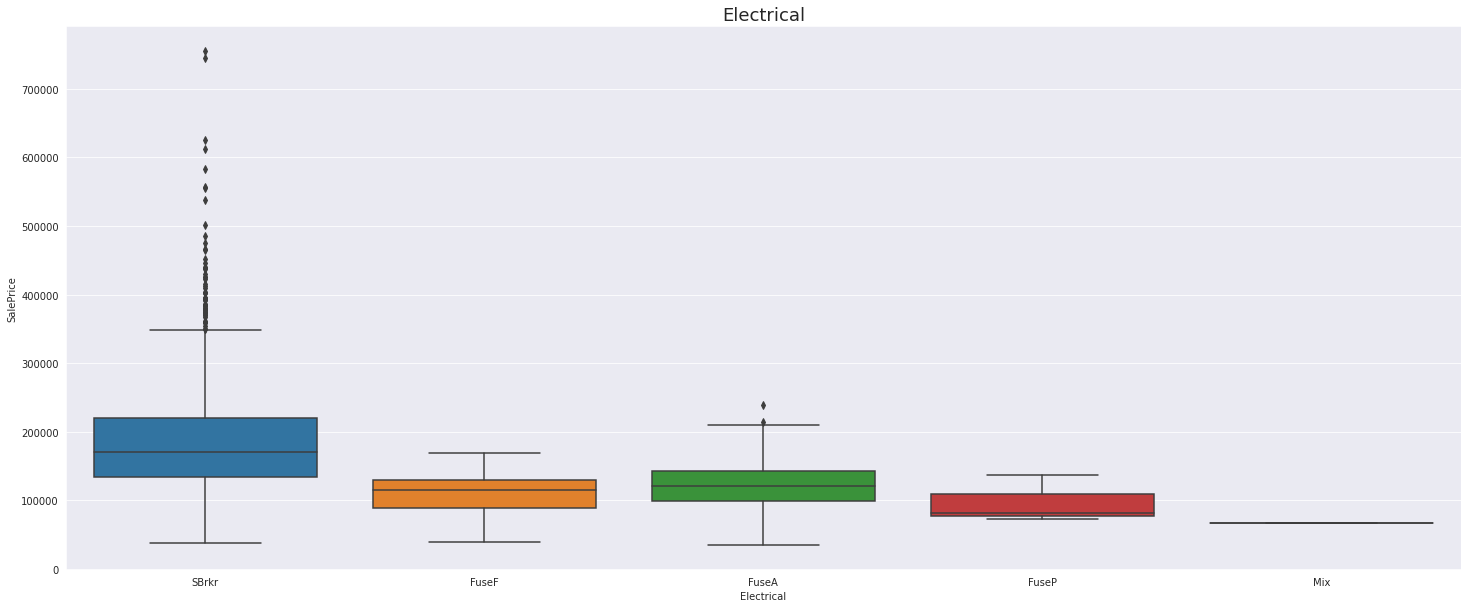

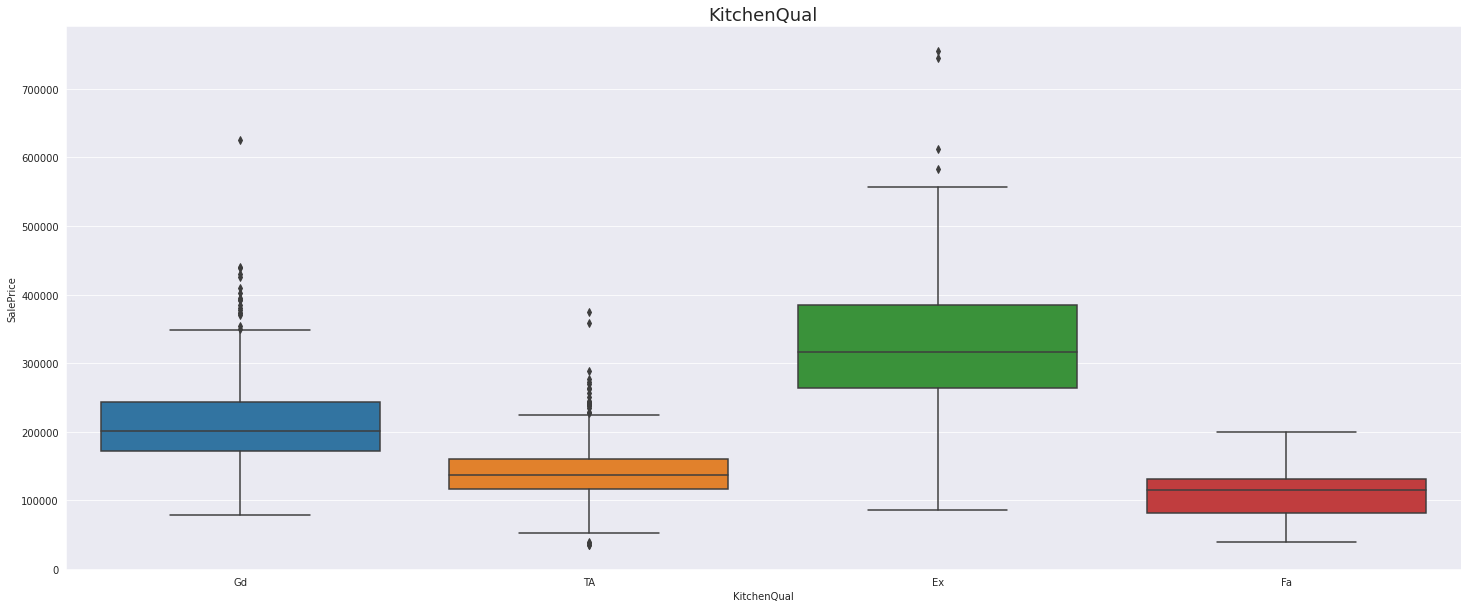

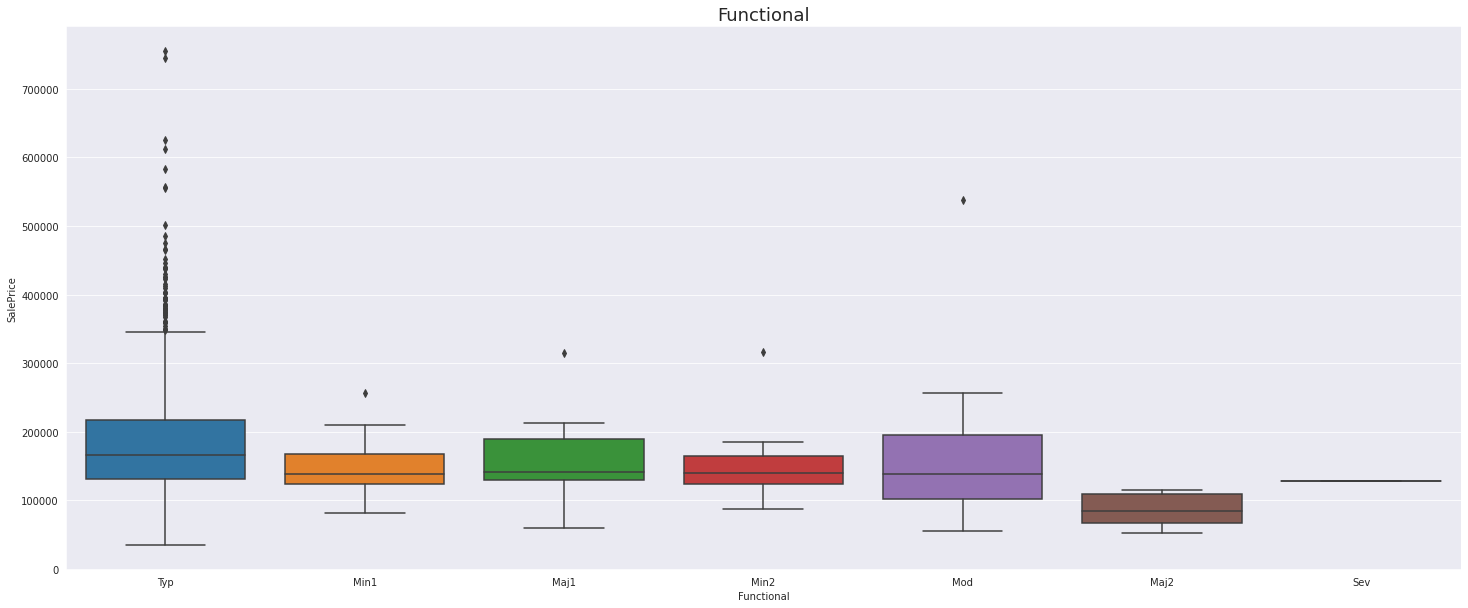

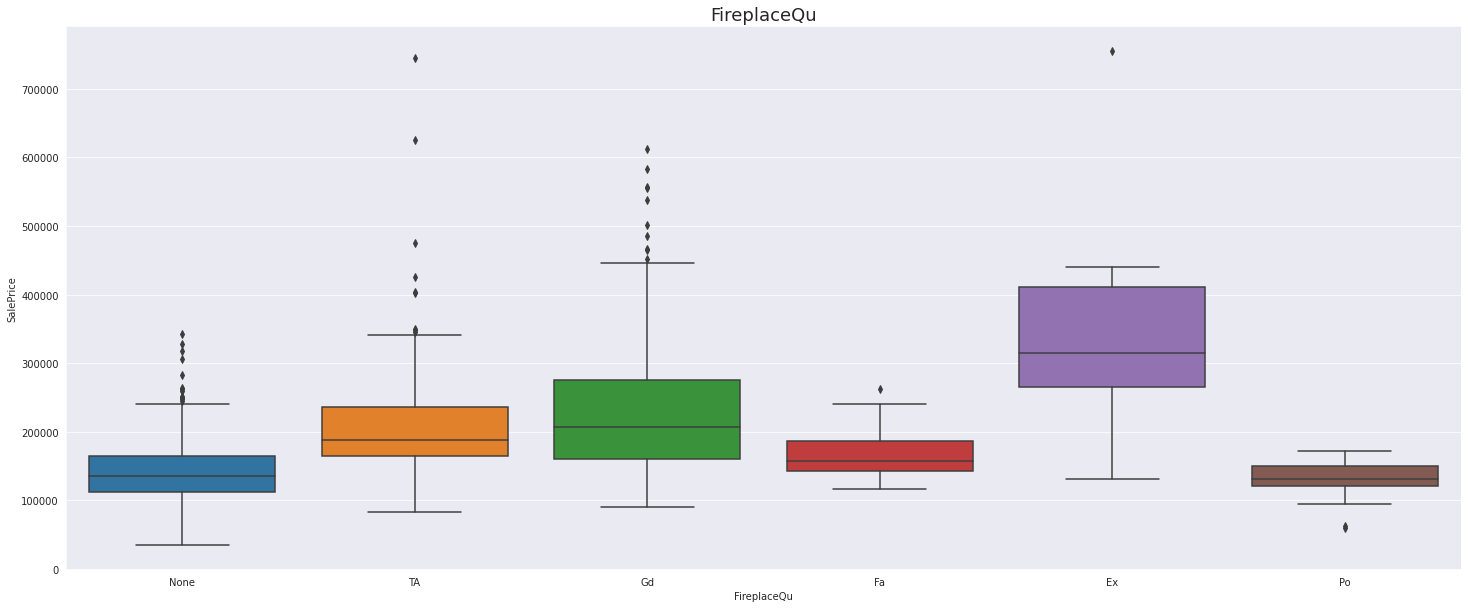

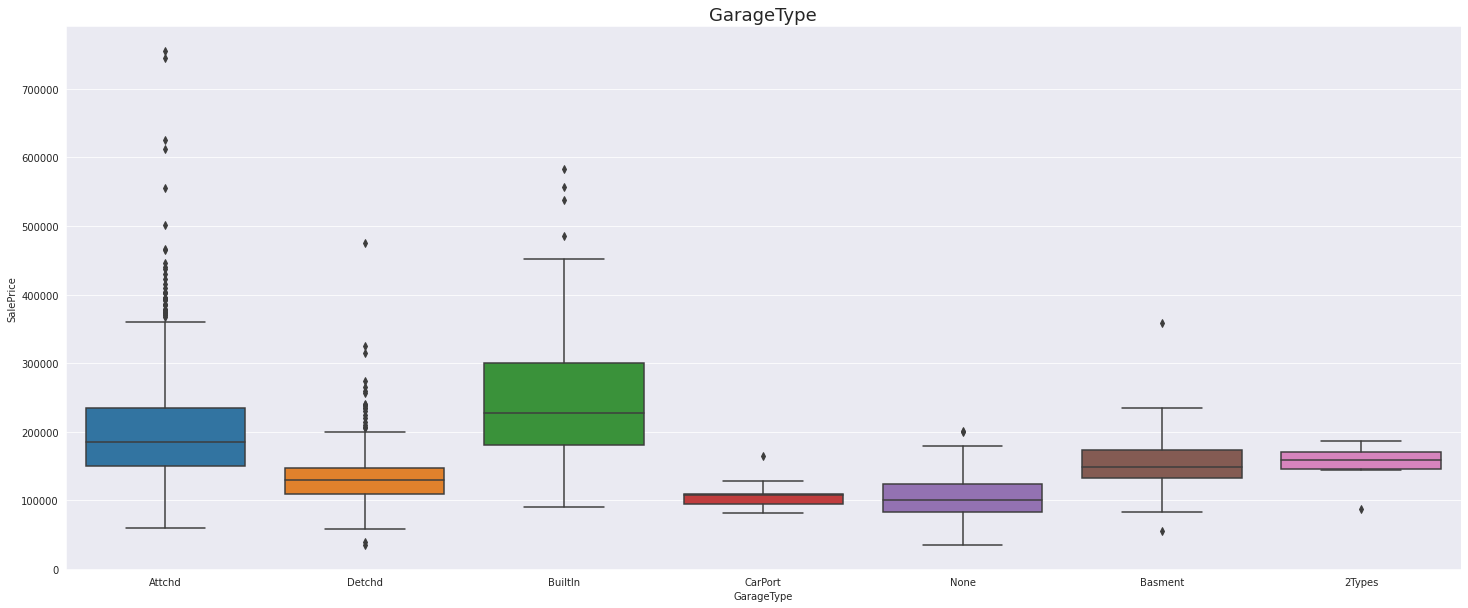

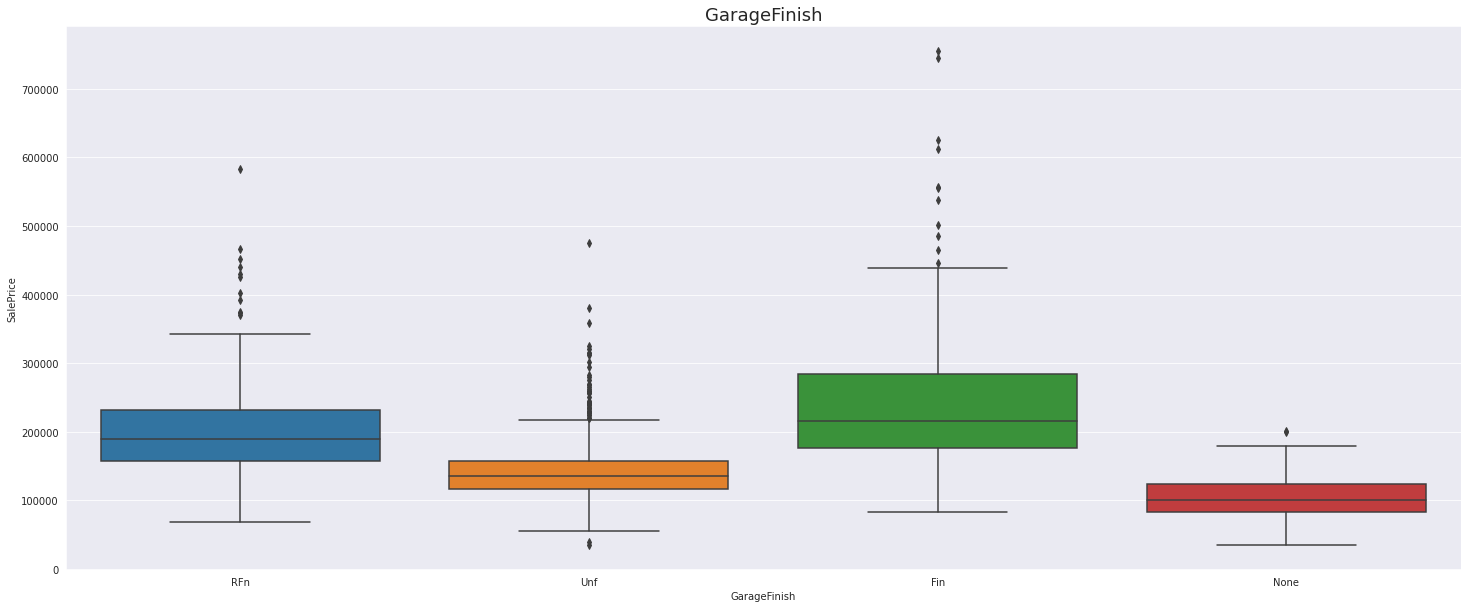

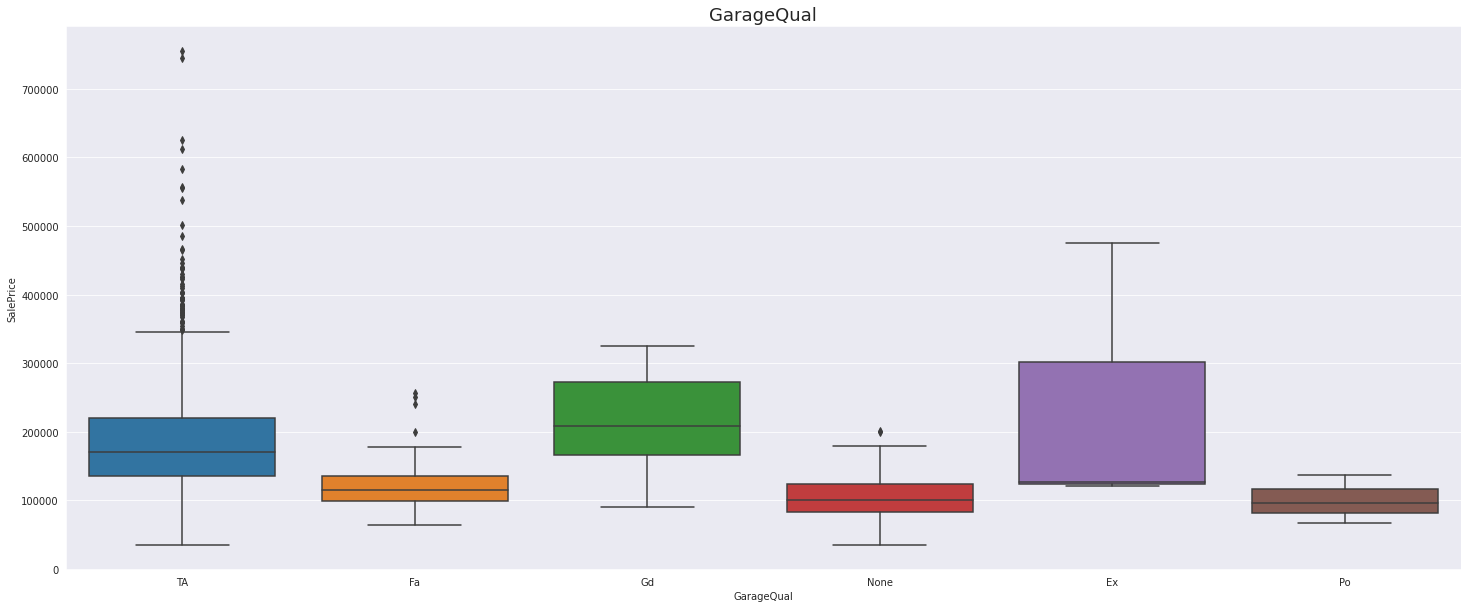

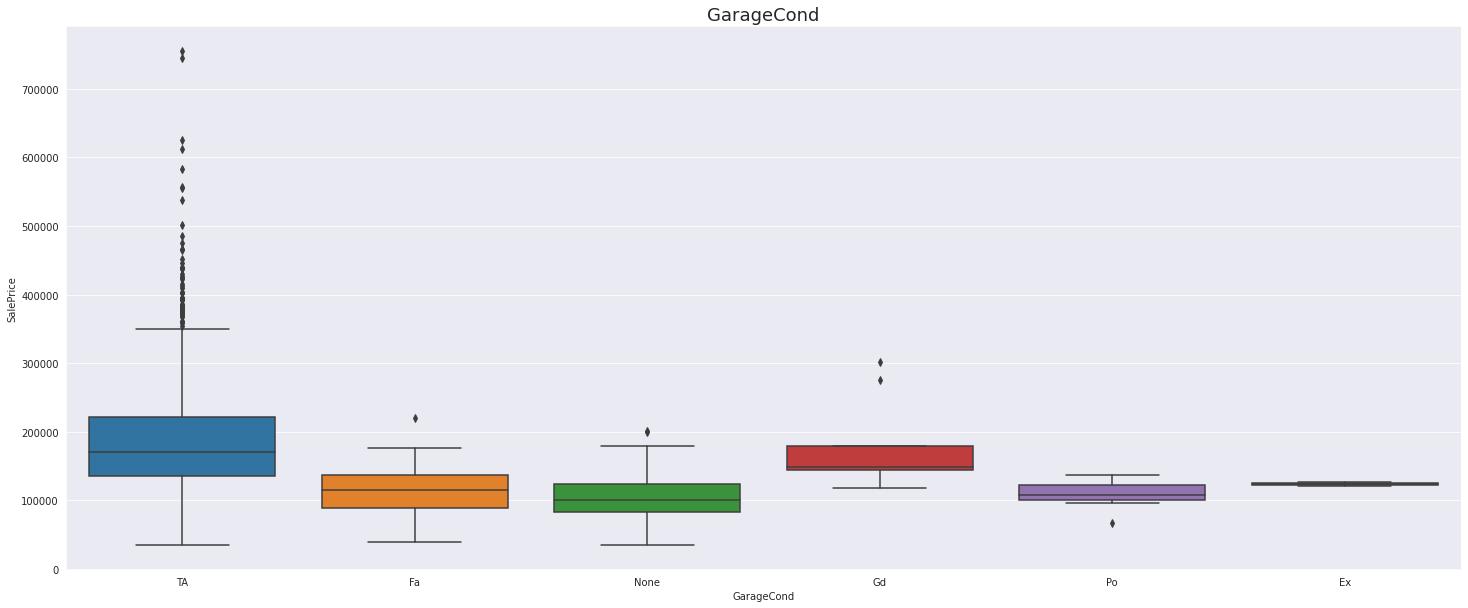

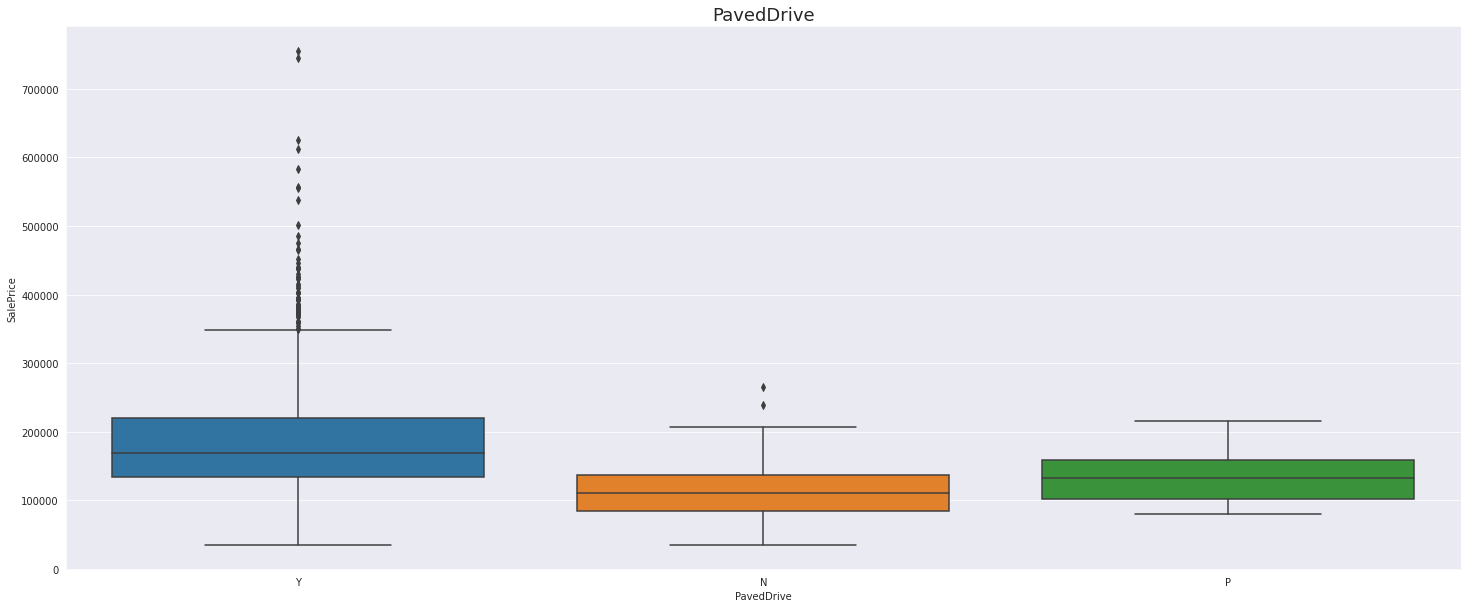

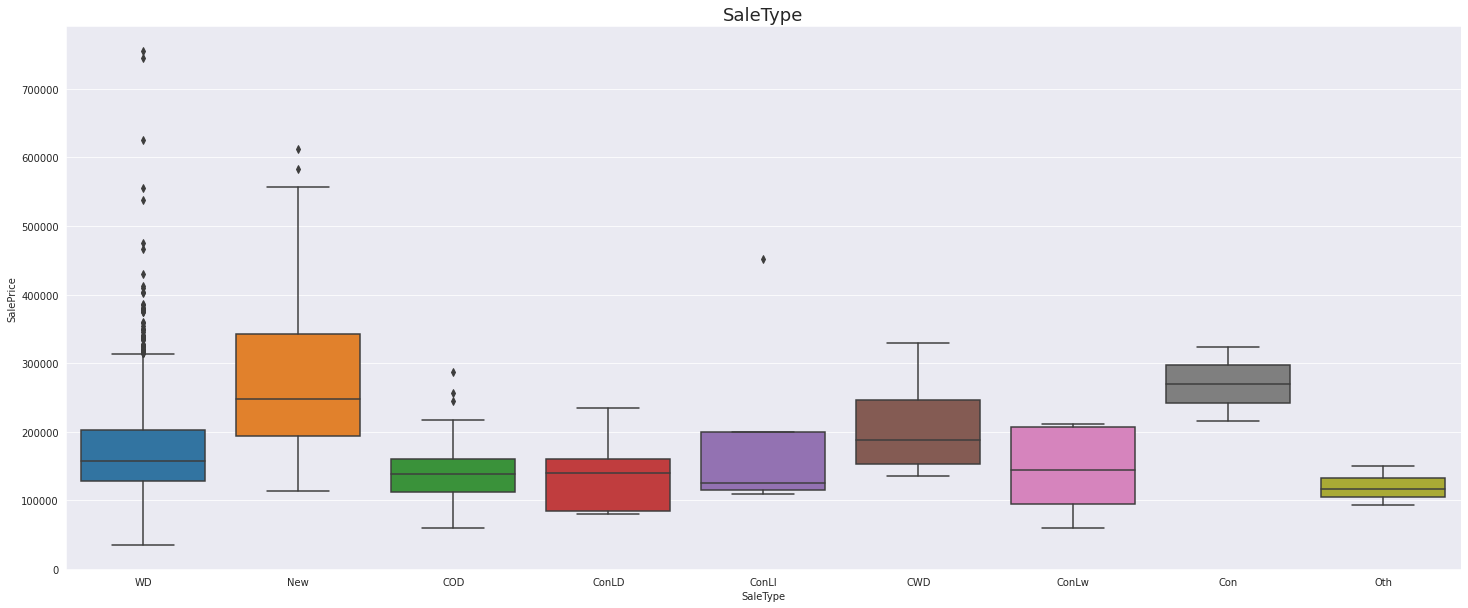

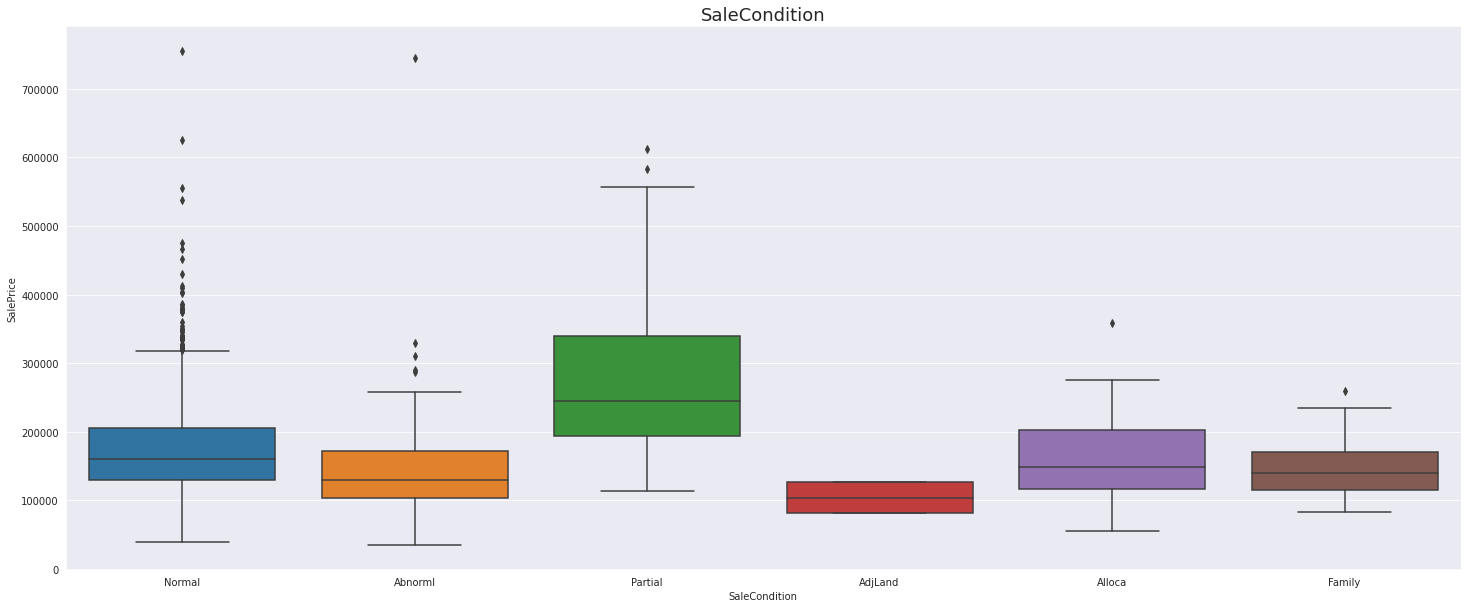

In [785]:
# Build boxplot of all categorical variables (before creating dummies) againt the target variable 'SalePrice' 


def draw_box_plots(columns):
  for col in columns:
      plt.figure(figsize=(25, 10))
      plt.title(col, fontdict={'fontsize': 18})
      sns.boxplot(x = col, y = 'SalePrice', data = housing)
      plt.show()

draw_box_plots(cat_columns)

Inference
 - The categorical variables such as SaleCondition,SaleType, GarageQuality, GarageCondition,Electrical,CentralAir heavily influence the sale price. These could be predictors.

Plot Correlation matrix

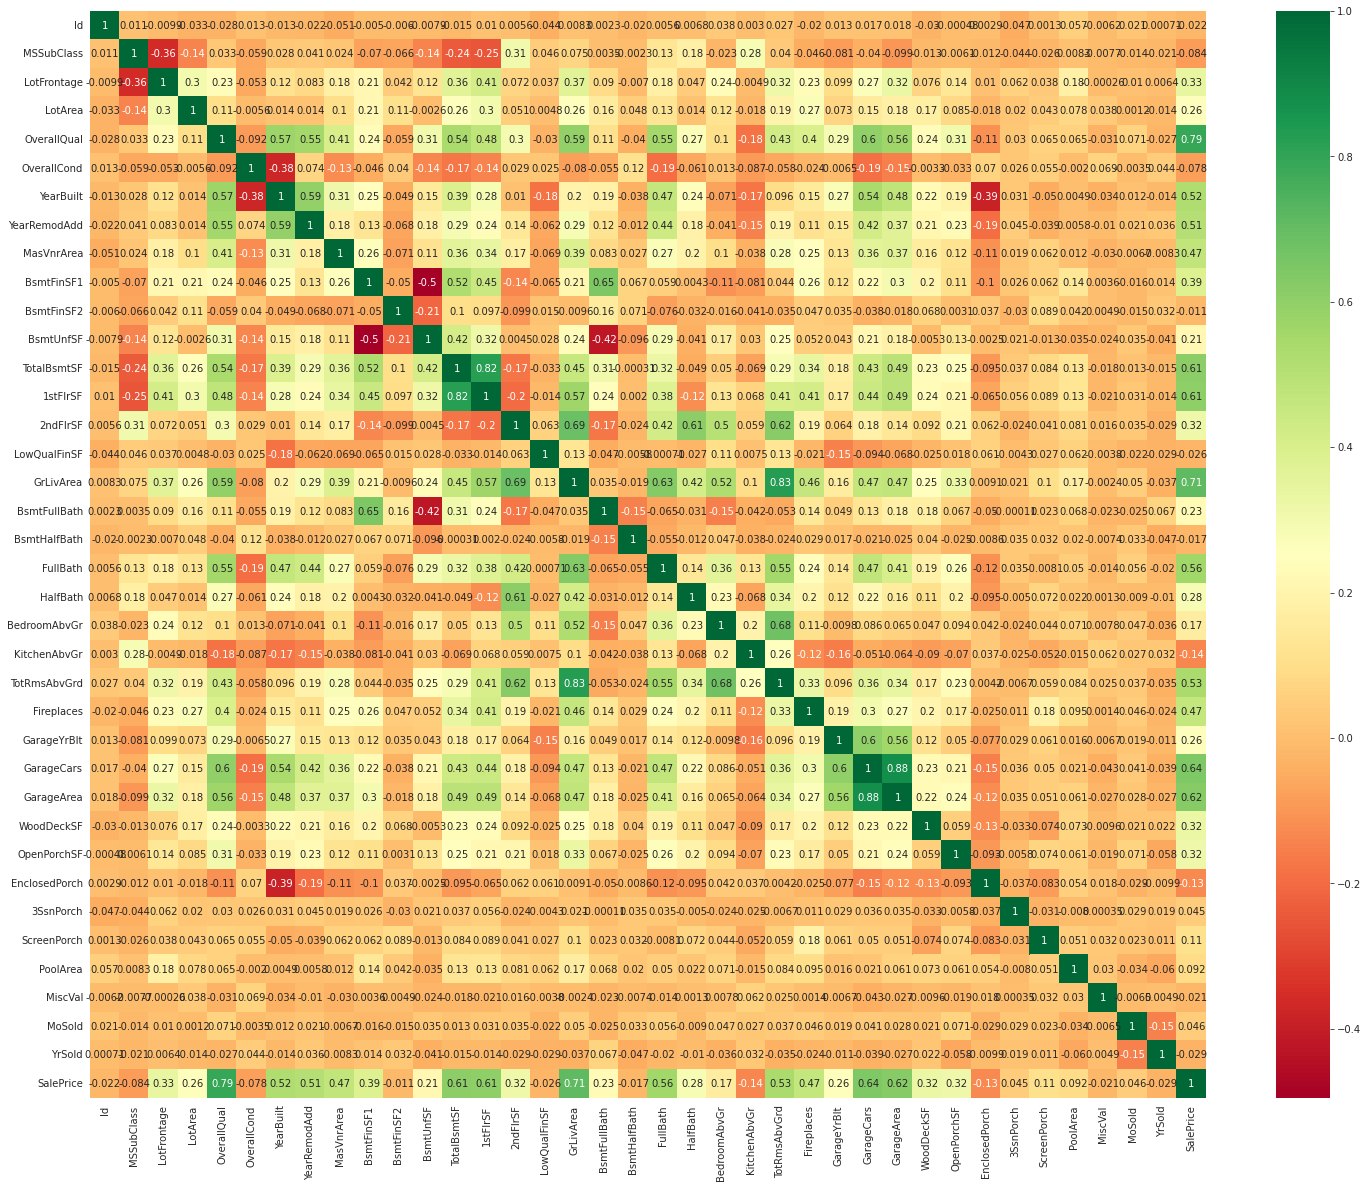

In [786]:
plt.figure(figsize = (25,20))
sns.heatmap(housing.corr(), annot = True, cmap='RdYlGn')
plt.show()

Inference 
- You can see high cor-relation between certain variables.
- SalePrice is most cor-related with OverallQual, YearBuilt, YearRemodAdd, MasVnrArea, TotalBsmtSF, 1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd, FirePlaces, GarageCars, GarageArea.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

# Step 3: Data preparation and processing. 


Outlier Treatment

(1460, 77)
(1063, 77)


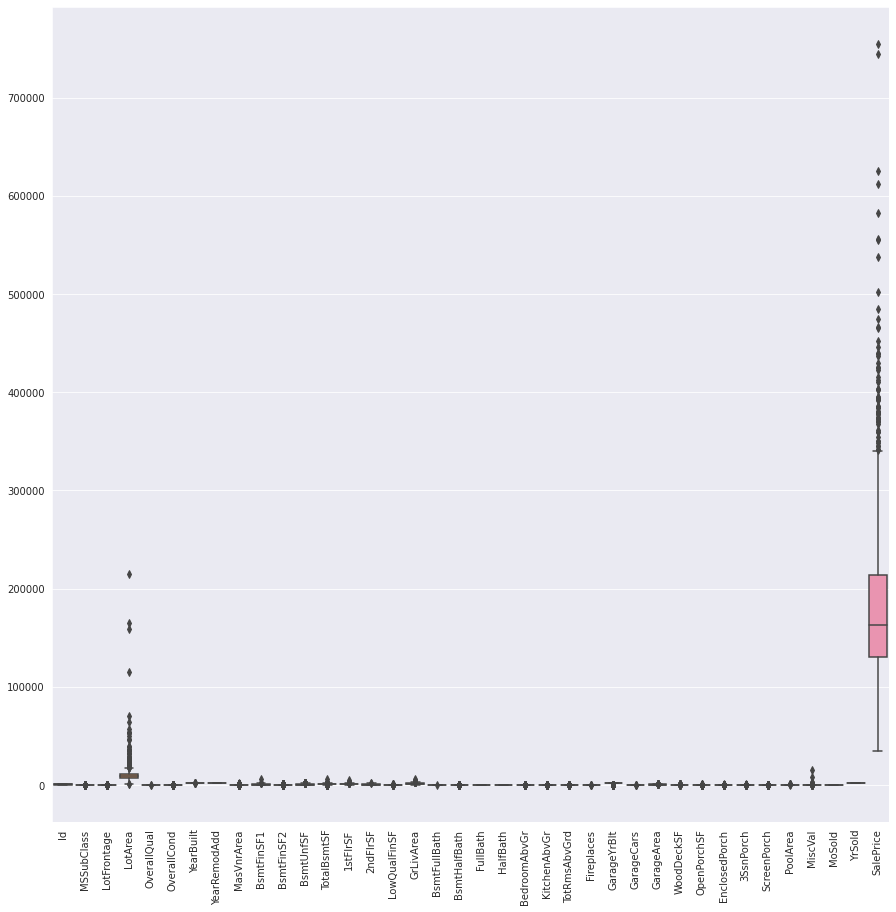

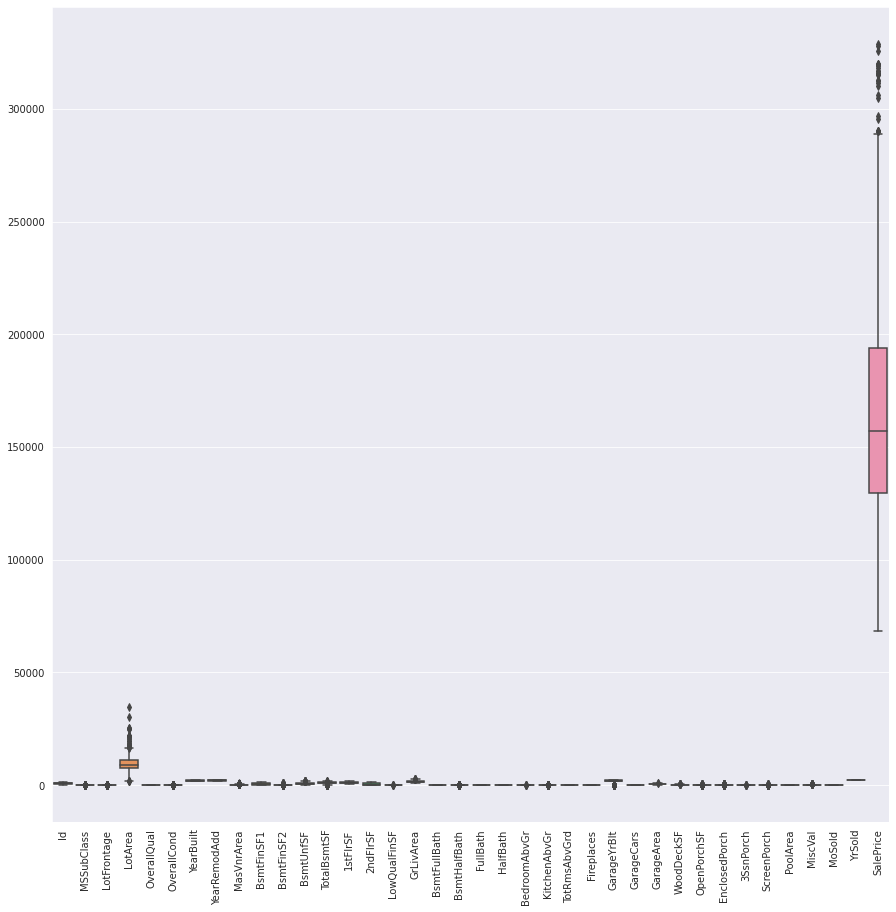

In [787]:
print(housing.shape)
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing);

# keeping values which are only greater than quantile(0.01) and less than quantile(0.99).
for col in numerical_columns:
  housing = housing[(housing[col] >= housing[col].quantile(0.01))&(housing[col] <= housing[col].quantile(0.99))]

# check boxplots again to see if outliers are treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing);
print(housing.shape)

# some outliers have been removed. Much lower quantile values reduce the number of rows.

Create dummy variables for categorical data


In [788]:
## One hot encoding the categorical columns
print(housing.head(5))
for col in cat_columns:
  # Let's drop the first column from status df using 'drop_first = True'
  encoded = pd.get_dummies(housing[col], drop_first = True, prefix=col)
  # Add the results to the original housing dataframe
  housing = pd.concat([housing, encoded], axis = 1)
  # Drop col as we have created the dummies for it
  housing.drop([col], axis = 1, inplace = True)
print(housing.head(5))

    Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
15  16          45       RM        51.00     6120   Pave      Reg         Lvl   
17  18          90       RL        72.00    10791   Pave      Reg         Lvl   
18  19          20       RL        66.00    13695   Pave      Reg         Lvl   
19  20          20       RL        70.00     7560   Pave      Reg         Lvl   
21  22          45       RM        57.00     7449   Pave      Reg         Bnk   

   Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
15    AllPub    Corner  ...             0         0           0        0   
17    AllPub    Inside  ...             0         0           0        0   
18    AllPub    Inside  ...             0         0           0        0   
19    AllPub    Inside  ...             0         0           0        0   
21    AllPub    Inside  ...           205         0           0        0   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  Sale

#Step 4: Model Building

In [789]:
X = housing.drop(["Id", "SalePrice"], axis=1).copy()
X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
15          45        51.00     6120            7            8       1929   
17          90        72.00    10791            4            5       1967   
18          20        66.00    13695            5            5       2004   
19          20        70.00     7560            5            6       1958   
21          45        57.00     7449            7            7       1930   

    YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
15          2001        0.00           0           0  ...               0   
17          1967        0.00           0           0  ...               0   
18          2004        0.00         646           0  ...               0   
19          1965        0.00         504           0  ...               0   
21          1950        0.00           0           0  ...               0   

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
15               0             0             0            1   
17               0             0             0            1   
18               0             0             0            1   
19               0             0             0            0   
21               0             0             0            1   

    SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
15                      0                     0                     0   
17                      0                     0                     0   
18                      0                     0                     0   
19                      0                     0                     0   
21                      0                     0                     0   

    SaleCondition_Normal  SaleCondition_Partial  
15                     1                      0  
17                     1                      0  
18                     1                      0  
19                     0                      0  
21                     1                      0  

[5 rows x 232 columns]

In [790]:
y = housing["SalePrice"].copy()
y.head()


15    132000
17     90000
18    159000
19    139000
21    139400
Name: SalePrice, dtype: int64

In [791]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

(850, 232)
(850,)


##Scaling

In [792]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [793]:
## Create a scaling instance

scaler = StandardScaler()
## Scale the numerical columns 
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

X_train.describe()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
count      850.00       850.00   850.00       850.00       850.00     850.00   
mean        -0.00         0.00     0.00        -0.00         0.00       0.00   
std          1.00         1.00     1.00         1.00         1.00       1.00   
min         -0.87        -2.76    -2.16        -2.51        -2.49      -2.49   
25%         -0.87        -0.47    -0.56        -0.80        -0.57      -0.61   
50%         -0.14         0.06    -0.07         0.06        -0.57       0.02   
75%          0.35         0.41     0.47         0.91         0.38       0.99   
max          3.29         4.05     7.14         2.62         3.26       1.30   

       YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
count        850.00      850.00      850.00      850.00  ...          850.00   
mean           0.00        0.00        0.00       -0.00  ...            0.00   
std            1.00        1.00        1.00        1.00  ...            0.05   
min           -1.66       -0.57       -1.04       -0.31  ...            0.00   
25%           -0.88       -0.57       -1.04       -0.31  ...            0.00   
50%            0.38       -0.57       -0.12       -0.31  ...            0.00   
75%            0.92        0.29        0.73       -0.31  ...            0.00   
max            1.21        4.66        2.80        5.80  ...            1.00   

       SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
count          850.00        850.00        850.00       850.00   
mean             0.00          0.06          0.00         0.89   
std              0.05          0.24          0.03         0.32   
min              0.00          0.00          0.00         0.00   
25%              0.00          0.00          0.00         1.00   
50%              0.00          0.00          0.00         1.00   
75%              0.00          0.00          0.00         1.00   
max              1.00          1.00          1.00         1.00   

       SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
count                 850.00                850.00                850.00   
mean                    0.00                  0.00                  0.01   
std                     0.05                  0.06                  0.11   
min                     0.00                  0.00                  0.00   
25%                     0.00                  0.00                  0.00   
50%                     0.00                  0.00                  0.00   
75%                     0.00                  0.00                  0.00   
max                     1.00                  1.00                  1.00   

       SaleCondition_Normal  SaleCondition_Partial  
count                850.00                 850.00  
mean                   0.86                   0.06  
std                    0.35                   0.24  
min                    0.00                   0.00  
25%                    1.00                   0.00  
50%                    1.00                   0.00  
75%                    1.00                   0.00  
max                    1.00                   1.00  

[8 rows x 232 columns]

### MODEL 1 : Ridge Regression

In [794]:
## we will run a cross validation on a list of alphas to find the optimum value of alpha
run_cross_validation()

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 4.0}


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

 Optimum value of alpha is 4.0.
 We will build a Ridge Model using the alpha


In [795]:
alpha = 4
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[ -2531.20153798   1073.84166292   3825.87383946   9482.94496738
   4852.73757707   9540.124427     2858.36115086    591.34333255
   5217.91206992    663.94290182     19.91256712   6041.00975712
   3249.04172202   9466.28335797   -503.96831585  12233.67409161
    830.05212881    113.57608897    630.24738142     36.60697171
  -1078.14906739  -1805.51828926    621.99824288   2656.50261709
   -111.27671692   2072.92262837   2228.66170855   2432.18974374
   1192.9445088    1177.4582376    1254.81381226    835.99344281
      0.            168.86280458    289.98721137    124.46413023
   4097.64350406   2030.68629435   4212.89513025  -3655.93677608
  -2364.90971305  -1262.69212435  -3425.11954426   -637.03804181
   1196.20497772  -4769.46247524    721.86676555      0.
   3542.0385919   -6508.24243623  -2444.72648893  -1509.18451387
   5480.26788164  -1345.6077018    2789.62419353   4435.7099381
   7154.72893652  -2640.15565439  -6213.92725225  16133.03650535
 -10023.83412943  -7379.01235398  

In [796]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [797]:
train_metrics = calculate_metrics(y_train,y_train_pred)
test_metrics = calculate_metrics(y_test,y_test_pred)

R2 Score is: 0.9424975166661651
RSS is  126670970288.02405
MSE is:  149024670.92708713
RMSE is:  12207.566134454777
R2 Score is: 0.8878355321592368
RSS is  64140879964.03949
MSE is:  301130891.8499507
RMSE is:  17353.123403294023


High RMSE Value indicates that there might be non-linear relationship between variables. Let us do residual analysis to understand further.

#### Residual Analysis

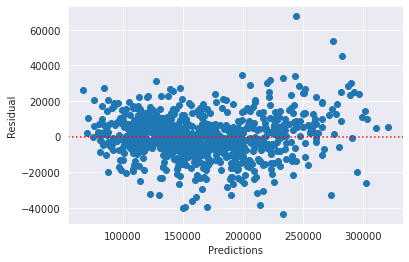

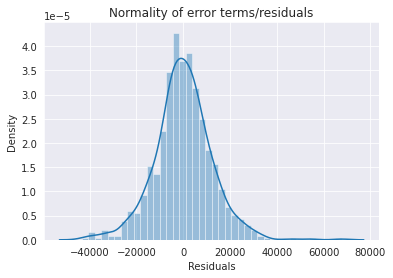

In [798]:
do_residual_analysis(y_train, y_train_pred)
# inference
# residuals doesnt seem to show a pattern
# residual terms are normally distributed

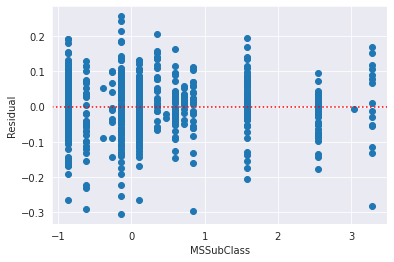

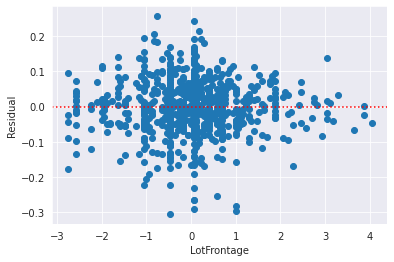

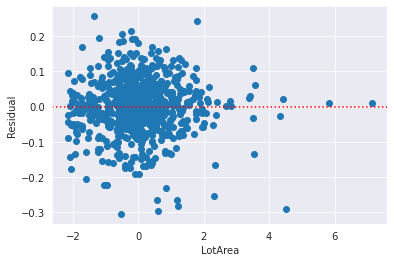

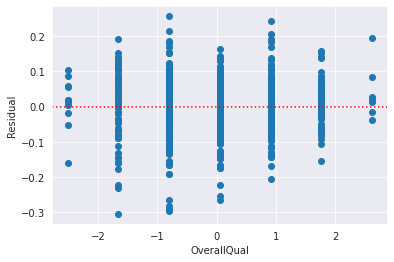

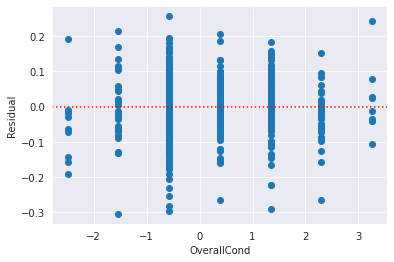

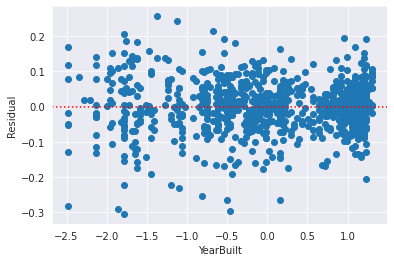

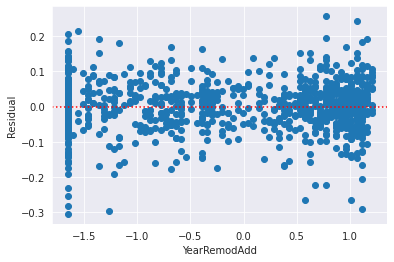

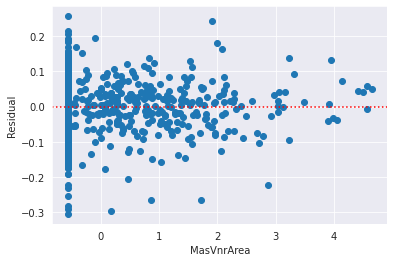

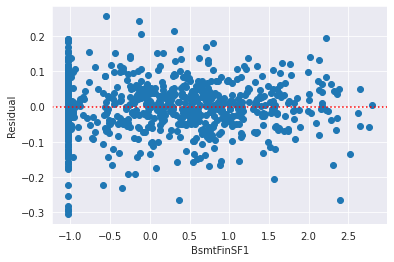

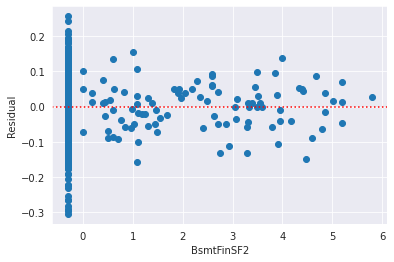

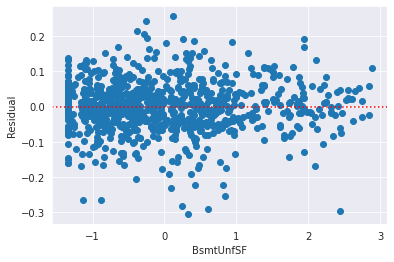

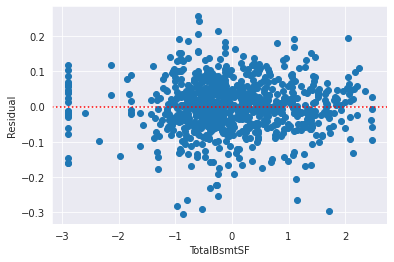

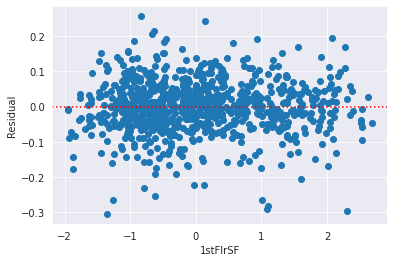

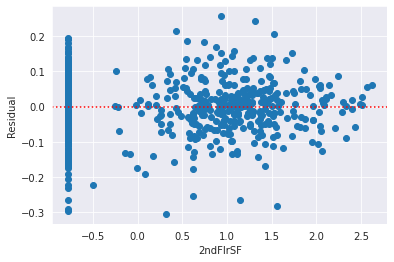

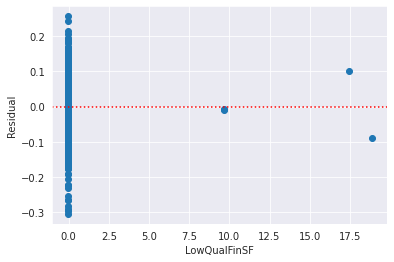

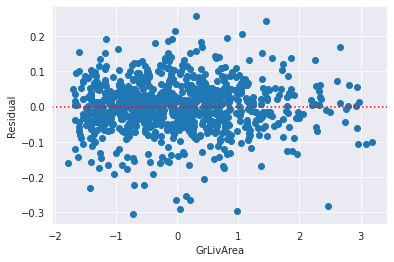

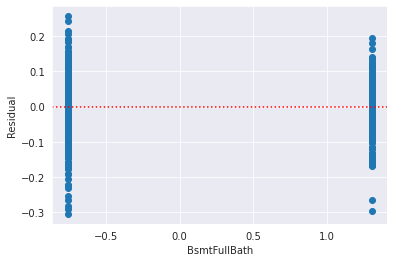

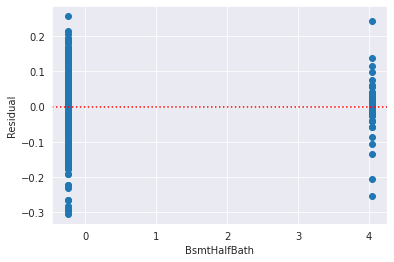

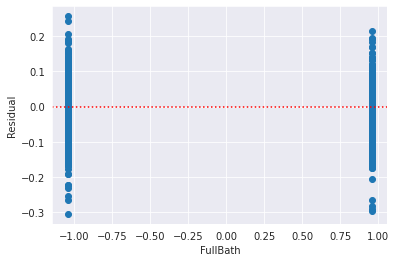

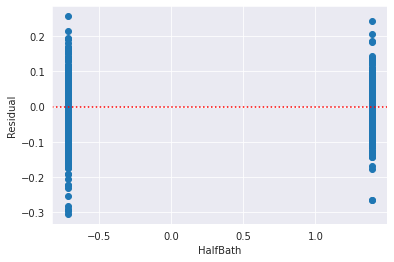

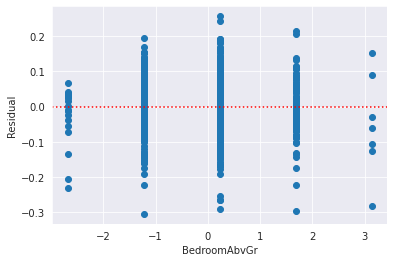

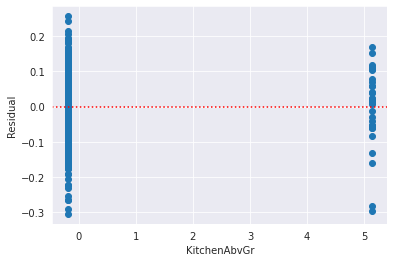

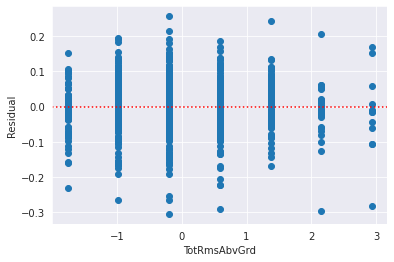

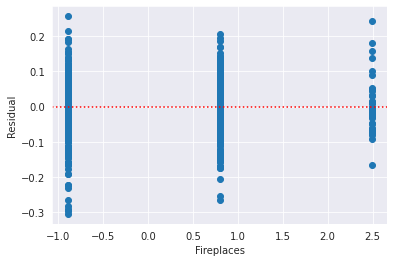

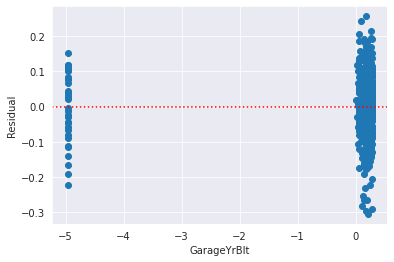

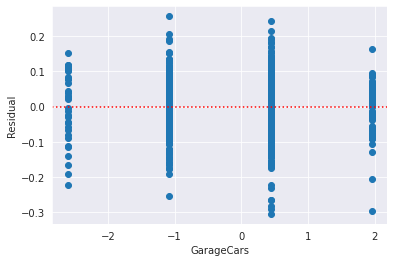

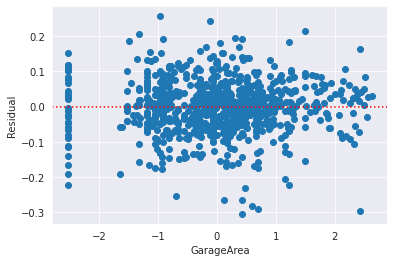

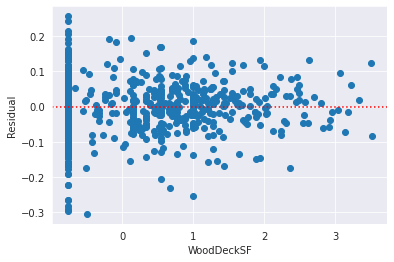

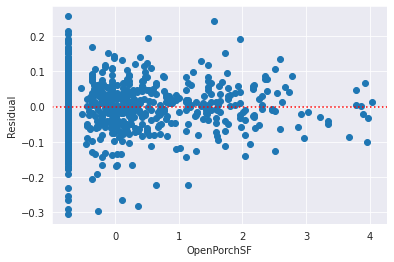

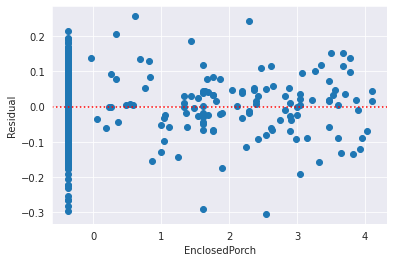

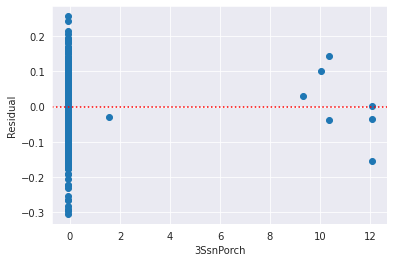

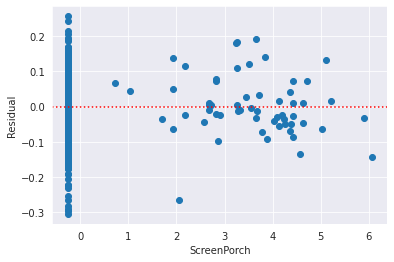

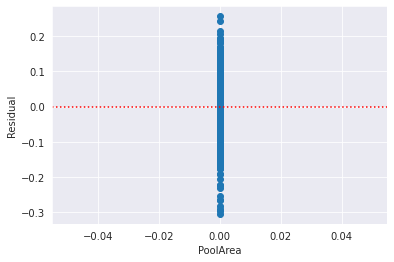

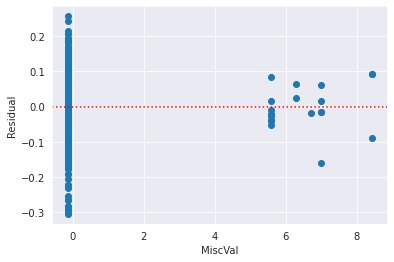

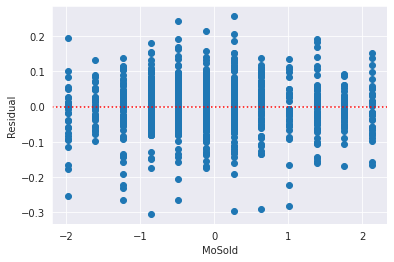

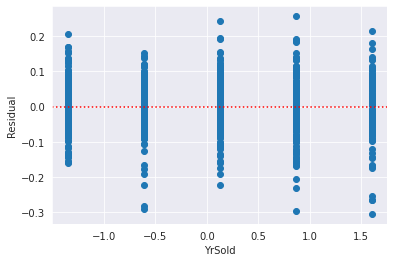

In [799]:
# plot all the variables vs residuals
for col in numerical_columns:
  plt.scatter( X_train[col] , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel(str(col))
  plt.ylabel("Residual")
  plt.show()

# there is no visible pattern.

Let us Analyse the target variable.

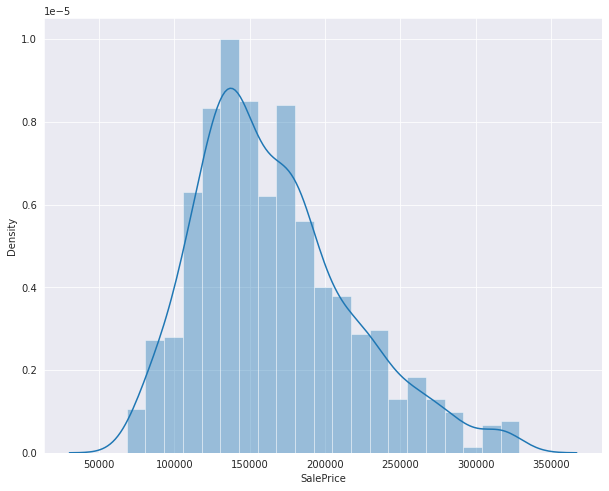

In [800]:
plt.figure(figsize=[10,8])
sns.set_style('darkgrid')
sns.distplot(housing['SalePrice']);
# saleprices are in higher ranges

In [801]:
# let us do a log transformation of saleprice for better model understanding
y_train = np.log(y_train)
y_test = np.log(y_test)

In [802]:
# run cross validation again
ridgeCV = run_cross_validation()

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 10.0}


In [803]:
# create new model with new alpha 10
alpha = 10
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.01578880e-02  6.71034348e-03  1.95391311e-02  5.47702213e-02
  4.03043805e-02  6.30655248e-02  1.65649243e-02 -1.39049298e-03
  2.69005054e-02  6.87720694e-03  1.75827267e-03  3.44594884e-02
  2.23041904e-02  4.20479293e-02 -5.49994575e-03  6.03765695e-02
  9.31895355e-03  3.05717852e-03  1.51361895e-02  7.66121751e-03
 -1.56503454e-03 -1.00978637e-02  7.82168039e-03  1.80664813e-02
  7.25218775e-03  1.17619631e-02  1.08796028e-02  1.15249147e-02
  4.53860601e-03  9.57529350e-03  5.93114426e-03  8.73518836e-03
  0.00000000e+00  6.90803536e-05  2.36006294e-03 -1.56351633e-03
  3.37476592e-02  9.14979121e-03  2.28851612e-02 -2.69900720e-02
 -9.14370875e-03  4.75480891e-03 -1.63081812e-02 -3.41330537e-03
  3.01179510e-03 -1.85846749e-02  7.92032477e-03  0.00000000e+00
  1.79263624e-02 -2.32689945e-02 -4.42610438e-03 -4.21129494e-03
  2.51046561e-02  1.19412309e-03  4.38314842e-03 -3.65005174e-03
  4.82451239e-02  2.15817781e-03 -2.04747607e-02  7.71176762e-02
 -4.92259529e-02 -2.71996

In [804]:
# predictions again
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [805]:
# calculate metrics again
ridge_train_metrics = calculate_metrics(y_train,y_train_pred)
ridge_test_metrics = calculate_metrics(y_test,y_test_pred)

# better scores for both train and test model.

R2 Score is: 0.9404569201075448
RSS is  4.647204480168848
MSE is:  0.005467299388433939
RMSE is:  0.07394118871396334
R2 Score is: 0.8767029515663985
RSS is  2.409993055511517
MSE is:  0.011314521387378014
RMSE is:  0.10636973905852178


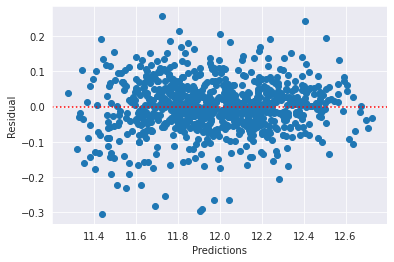

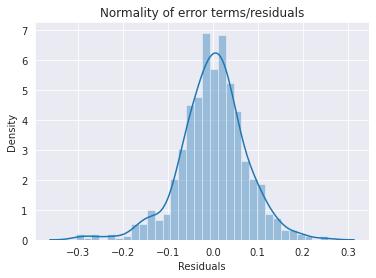

In [806]:
do_residual_analysis(y_train,y_train_pred)

# no visible pattern
# error terms are normally distributed


In [807]:
## Create a dataframe of ridge cross validation results
ridgeCV_results= pd.DataFrame(ridgeCV.cv_results_)
ridgeCV_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0            0.01          0.00             0.01            0.00        0.00   
1            0.01          0.00             0.01            0.00        0.00   
2            0.02          0.00             0.01            0.00        0.01   
3            0.02          0.01             0.01            0.00        0.05   
4            0.02          0.00             0.01            0.00        0.10   
5            0.01          0.00             0.01            0.00        0.20   
6            0.01          0.00             0.00            0.00        0.30   
7            0.01          0.00             0.01            0.00        0.40   
8            0.02          0.00             0.01            0.00        0.50   
9            0.01          0.00             0.01            0.00        0.60   
10           0.01          0.00             0.01            0.00        0.70   
11           0.01          0.00             0.01            0.00        0.80   
12           0.02          0.01             0.01            0.00        0.90   
13           0.02          0.01             0.01            0.00        1.00   
14           0.02          0.00             0.01            0.00        2.00   
15           0.01          0.00             0.01            0.00        3.00   
16           0.01          0.00             0.01            0.00        4.00   
17           0.02          0.00             0.01            0.00        5.00   
18           0.01          0.00             0.01            0.00        6.00   
19           0.01          0.00             0.01            0.00        7.00   
20           0.02          0.00             0.01            0.00        8.00   
21           0.01          0.00             0.01            0.00        9.00   
22           0.01          0.00             0.01            0.00       10.00   
23           0.02          0.00             0.01            0.00          20   
24           0.02          0.01             0.00            0.00          50   
25           0.01          0.00             0.01            0.00         100   
26           0.01          0.00             0.01            0.00         500   
27           0.01          0.00             0.00            0.00        1000   

               params  split0_test_score  split1_test_score  \
0   {'alpha': 0.0001}              -0.08              -0.08   
1    {'alpha': 0.001}              -0.08              -0.08   
2     {'alpha': 0.01}              -0.07              -0.08   
3     {'alpha': 0.05}              -0.07              -0.08   
4      {'alpha': 0.1}              -0.07              -0.08   
5      {'alpha': 0.2}              -0.07              -0.08   
6      {'alpha': 0.3}              -0.07              -0.08   
7      {'alpha': 0.4}              -0.07              -0.08   
8      {'alpha': 0.5}              -0.07              -0.08   
9      {'alpha': 0.6}              -0.07              -0.08   
10     {'alpha': 0.7}              -0.07              -0.08   
11     {'alpha': 0.8}              -0.07              -0.08   
12     {'alpha': 0.9}              -0.07              -0.08   
13     {'alpha': 1.0}              -0.07              -0.08   
14     {'alpha': 2.0}              -0.06              -0.07   
15     {'alpha': 3.0}              -0.06              -0.07   
16     {'alpha': 4.0}              -0.06              -0.07   
17     {'alpha': 5.0}              -0.06              -0.07   
18     {'alpha': 6.0}              -0.06              -0.07   
19     {'alpha': 7.0}              -0.06              -0.07   
20     {'alpha': 8.0}              -0.06              -0.07   
21     {'alpha': 9.0}              -0.06              -0.07   
22    {'alpha': 10.0}              -0.06              -0.07   
23      {'alpha': 20}              -0.06              -0.07   
24      {'alpha': 50}              -0.06              -0.08   
25     {'alpha': 100}              -0.07     

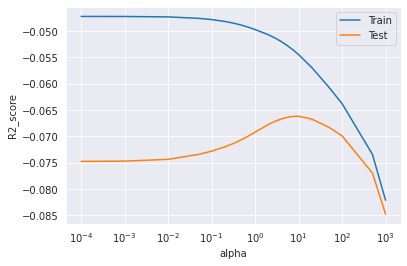

In [808]:
## Plotting R2 score vs alpha values
plt.plot(ridgeCV_results['param_alpha'], ridgeCV_results['mean_train_score'], label='Train')
plt.plot(ridgeCV_results['param_alpha'], ridgeCV_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()
# inference - the best value of alpha is at 10 from the plot.

### MODEL2 : Lasso

In [809]:
## we will run a cross validation on a list of alphas to find the optimum value of alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso = Lasso()

# cross validation

lassoCV = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lassoCV.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [810]:
## View the optimal value of alpha
lassoCV.best_params_

{'alpha': 0.001}

In [811]:
# view the results
lassoCV.cv_results_

{'mean_fit_time': array([0.17047706, 0.02690964, 0.01645031, 0.01315732, 0.01165299,
        0.01132278, 0.01123848, 0.0109746 , 0.01219368, 0.01406379,
        0.01171284, 0.01144571, 0.01001282, 0.01248264, 0.01105647,
        0.01314278, 0.0101748 , 0.00957727, 0.01021075, 0.01201277,
        0.0099659 , 0.01031818, 0.01026874, 0.01042714, 0.00993471,
        0.00984697, 0.01005664, 0.00758715]),
 'std_fit_time': array([0.01174868, 0.00068388, 0.00390639, 0.00246981, 0.00057623,
        0.00158666, 0.00233306, 0.00168014, 0.00380354, 0.00762357,
        0.00154472, 0.0035176 , 0.0004117 , 0.00538043, 0.00223075,
        0.0048579 , 0.00148091, 0.00024588, 0.00038355, 0.0050982 ,
        0.0018133 , 0.00154397, 0.00031008, 0.00029496, 0.00057955,
        0.0001191 , 0.00055936, 0.00231486]),
 'mean_score_time': array([0.00553212, 0.00848742, 0.0057282 , 0.00553904, 0.00536833,
        0.00525422, 0.00508876, 0.00484495, 0.00507874, 0.0050703 ,
        0.00605588, 0.00596347, 0.005005

In [812]:
# Create a lasso regreesion instance with optimum value alpha=0.001
lasso = Lasso(alpha=0.001)
# Fit the model on training data
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [813]:
## Make predictions
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

In [814]:
# check metrics for train
print("Training Metrics")
lasso_train_metrics = calculate_metrics(y_train,y_train_pred)
# check metrics for test
print("Testing Metrics")
lasso_test_metrics = calculate_metrics(y_test,y_test_pred)

# the metrics look good for both train and test sets.

Training Metrics
R2 Score is: 0.9273677755243649
RSS is  5.668782998753999
MSE is:  0.006669156469122352
RMSE is:  0.0816649035334173
Testing Metrics
R2 Score is: 0.8646188197466432
RSS is  2.6461923330893526
MSE is:  0.012423438183518088
RMSE is:  0.11146047812349491


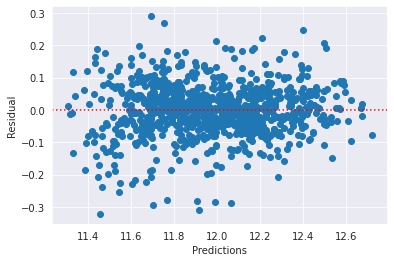

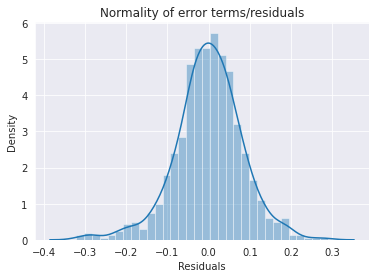

In [815]:
do_residual_analysis(y_train,y_train_pred)
# no visible patterns,
# error terms are normally distributed

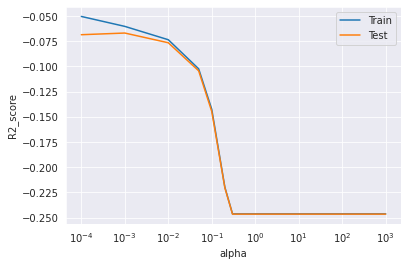

In [816]:
## Create a dataframe of ridge cross validation results
lassoCV_results= pd.DataFrame(lassoCV.cv_results_)
## Plotting R2 score vs alpha values
plt.plot(lassoCV_results['param_alpha'], lassoCV_results['mean_train_score'], label='Train')
plt.plot(lassoCV_results['param_alpha'], lassoCV_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

# you can see the best value of alpha is at 0.001

### Comparing Ridge and Lasso Models

In [817]:
ridge_metrics = ridge_train_metrics + ridge_test_metrics
lasso_metrics = lasso_train_metrics + lasso_test_metrics
print("############### Metrics ##########")
print_metrics(ridge_metrics,lasso_metrics,'Ridge Regression','Lasso Regression')

############### Metrics ##########
             Metric  Ridge Regression  Lasso Regression
0  R2 Score (Train)              0.94              0.93
1       RSS (Train)              4.65              5.67
2       MSE (Train)              0.01              0.01
3      RMSE (Train)              0.07              0.08
4   R2 Score (Test)              0.88              0.86
5        RSS (Test)              2.41              2.65
6        MSE (Test)              0.01              0.01
7       RMSE (Test)              0.11              0.11


In [818]:
## Let us check the changes in coefficients after regularization
## First create empty datafame with all the independent variables as indices
coef = pd.DataFrame(index=X.columns)
coef.rows = X.columns
## adding coef to dataframes
coef['Ridge'] = ridge.coef_
coef['Lasso'] = lasso.coef_
print(coef.to_string())
coef.shape

                       Ridge  Lasso
MSSubClass             -0.01  -0.01
LotFrontage             0.01   0.01
LotArea                 0.02   0.02
OverallQual             0.05   0.06
OverallCond             0.04   0.04
YearBuilt               0.06   0.07
YearRemodAdd            0.02   0.01
MasVnrArea             -0.00   0.00
BsmtFinSF1              0.03   0.03
BsmtFinSF2              0.01   0.00
BsmtUnfSF               0.00  -0.00
TotalBsmtSF             0.03   0.04
1stFlrSF                0.02   0.00
2ndFlrSF                0.04   0.00
LowQualFinSF           -0.01  -0.00
GrLivArea               0.06   0.10
BsmtFullBath            0.01   0.01
BsmtHalfBath            0.00   0.00
FullBath                0.02   0.01
HalfBath                0.01   0.00
BedroomAbvGr           -0.00  -0.00
KitchenAbvGr           -0.01  -0.01
TotRmsAbvGrd            0.01   0.00
Fireplaces              0.02   0.02
GarageYrBlt             0.01   0.01
GarageCars              0.01   0.02
GarageArea              0.01

(232, 2)

In [819]:
## View the number of features removed by lasso
coef[coef['Lasso']==0].shape

# has removed 175 features out of 232 features

(175, 2)

In [820]:
## View the features selected by lasso
coef.loc[coef['Lasso']!=0, 'Lasso']
# 57 features selected by Lasso

MSSubClass              -0.01
LotFrontage              0.01
LotArea                  0.02
OverallQual              0.06
OverallCond              0.04
YearBuilt                0.07
YearRemodAdd             0.01
MasVnrArea               0.00
BsmtFinSF1               0.03
BsmtFinSF2               0.00
TotalBsmtSF              0.04
LowQualFinSF            -0.00
GrLivArea                0.10
BsmtFullBath             0.01
BsmtHalfBath             0.00
FullBath                 0.01
HalfBath                 0.00
BedroomAbvGr            -0.00
KitchenAbvGr            -0.01
TotRmsAbvGrd             0.00
Fireplaces               0.02
GarageYrBlt              0.01
GarageCars               0.02
GarageArea               0.01
WoodDeckSF               0.01
OpenPorchSF              0.00
EnclosedPorch            0.01
3SsnPorch                0.00
ScreenPorch              0.01
MoSold                   0.00
MSZoning_RM             -0.05
LotShape_Reg            -0.00
LotConfig_CulDSac        0.00
Neighborho

#### Inference for both Ridge and Lasso

In [821]:
## View the top 10 coefficients 
coef['Ridge'].sort_values(ascending=False)[:10]

Neighborhood_Crawfor   0.08
YearBuilt              0.06
GrLivArea              0.06
Condition1_Norm        0.06
OverallQual            0.05
Neighborhood_Somerst   0.05
Neighborhood_BrkSide   0.05
Functional_Typ         0.04
Exterior1st_BrkFace    0.04
2ndFlrSF               0.04
Name: Ridge, dtype: float64

In [822]:
## View the top 10 coefficients of Lasso in descending order
coef['Lasso'].sort_values(ascending=False)[:10]

GrLivArea              0.10
Neighborhood_Crawfor   0.08
YearBuilt              0.07
OverallQual            0.06
Neighborhood_Somerst   0.06
Condition1_Norm        0.05
Neighborhood_BrkSide   0.05
Exterior1st_BrkFace    0.04
OverallCond            0.04
TotalBsmtSF            0.04
Name: Lasso, dtype: float64

Inference:
- Neighborhood_Crawfor: if Crawford is a nearby location, then the price of house will increase by 0.08 times
- YearBuilt : Depending upon the value of year built the sale price will increase from 0.06 to 0.07 times
- GrLivArea - an increase of 1 square foot of house area above ground, the price will increase by 0.06 to 0.10 times
- Condition1_Norm - proximity to normal conditions will increase sale price by 0.05 to 0.06 times

# Code for subjective questions

## Question 1

In [823]:
# Question 1
# doubling value of alpha in ridge 10 -> 100

# create new model with new alpha 100
alpha = 100
ridge2 = Ridge(alpha=alpha)
ridge2.fit(X_train, y_train)
print(ridge2.coef_)


[-8.12070735e-03  7.99604459e-03  1.68824082e-02  5.64054023e-02
  3.37787147e-02  4.20312142e-02  1.98519611e-02  2.19595039e-03
  2.66278968e-02  3.01970717e-03  3.00494120e-03  3.42198476e-02
  2.29947571e-02  2.79485935e-02 -4.42571670e-03  4.64520679e-02
  1.07256420e-02  3.44184830e-03  1.72122280e-02  1.14667588e-02
 -1.20660265e-03 -1.23362934e-02  1.23546211e-02  1.65959229e-02
  7.28632068e-03  1.30941585e-02  1.59359336e-02  9.41612854e-03
  6.43054442e-03  6.24455035e-03  5.11554885e-03  9.10993653e-03
  0.00000000e+00 -1.85672883e-04  2.83931888e-03 -2.25051688e-03
  1.60562645e-02  9.39608024e-04  1.00281273e-02 -2.19943349e-02
 -1.16118212e-04  2.64843564e-03 -3.80999853e-03 -6.36715871e-03
  3.48192615e-03 -2.47606876e-03  1.64776874e-03  0.00000000e+00
  7.16392590e-03 -5.74367779e-03 -2.04456574e-04 -1.84243318e-03
  5.63448168e-03  4.98980594e-04  2.16101353e-04 -2.96330290e-03
  1.34289050e-02  2.81384947e-03 -4.27634490e-03  2.10165865e-02
 -1.62386346e-02 -7.72601

In [824]:
# predictions again
y_train_pred = ridge2.predict(X_train)
y_test_pred = ridge2.predict(X_test)

In [825]:
# calculate metrics again
new_ridge_train_metrics = calculate_metrics(y_train,y_train_pred)
new_ridge_test_metrics = calculate_metrics(y_test,y_test_pred)

new_ridge_metrics = new_ridge_train_metrics + new_ridge_test_metrics

print_metrics(ridge_metrics,new_ridge_metrics, 'Ridge - Original', 'Ridge - Doubled')
# Train R2 score has dropped for the new model
# Train RMSE has increased
# Test R2 score has dropped for the new model
# Test RMSE remains same

R2 Score is: 0.9201182474815179
RSS is  6.2345924809084
MSE is:  0.007334814683421648
RMSE is:  0.08564353264211867
R2 Score is: 0.8559375784367308
RSS is  2.815877913854697
MSE is:  0.013220084102604212
RMSE is:  0.11497862454649652
             Metric  Ridge - Original  Ridge - Doubled
0  R2 Score (Train)              0.94             0.92
1       RSS (Train)              4.65             6.23
2       MSE (Train)              0.01             0.01
3      RMSE (Train)              0.07             0.09
4   R2 Score (Test)              0.88             0.86
5        RSS (Test)              2.41             2.82
6        MSE (Test)              0.01             0.01
7       RMSE (Test)              0.11             0.11


In [826]:
# Create a lasso regreesion instance with optimum value alpha=0.000001
alpha = 0.001 * 0.001
lasso2 = Lasso(alpha=alpha)
# Fit the model on training data
lasso2.fit(X_train, y_train)

Lasso(alpha=1e-06)

In [827]:
## Make predictions
y_train_pred = lasso2.predict(X_train)
y_test_pred = lasso2.predict(X_test)

In [828]:
# check metrics for train
print("Training Metrics")
new_lasso_train_metrics = calculate_metrics(y_train,y_train_pred)
# check metrics for test
print("Testing Metrics")
new_lasso_test_metrics = calculate_metrics(y_test,y_test_pred)

new_lasso_metrics = new_lasso_train_metrics + new_lasso_test_metrics

print_metrics(lasso_metrics,new_lasso_metrics, 'Lasso - Original', 'Lasso - Doubled')
# R2 score for training has improved 
# RMSE for training has decrease
# the test R2 score has improved
# RMSE for testing remains same

Training Metrics
R2 Score is: 0.9517063384598571
RSS is  3.769212487470745
MSE is:  0.004434367632318524
RMSE is:  0.06659104768899889
Testing Metrics
R2 Score is: 0.8710566311504154
RSS is  2.5203573599663818
MSE is:  0.011832663661814
RMSE is:  0.10877804770179506
             Metric  Lasso - Original  Lasso - Doubled
0  R2 Score (Train)              0.93             0.95
1       RSS (Train)              5.67             3.77
2       MSE (Train)              0.01             0.00
3      RMSE (Train)              0.08             0.07
4   R2 Score (Test)              0.86             0.87
5        RSS (Test)              2.65             2.52
6        MSE (Test)              0.01             0.01
7       RMSE (Test)              0.11             0.11


In [829]:
coef2 = pd.DataFrame(index=X.columns)
coef2.rows = X.columns
## adding coef to dataframes
coef2['Ridge'] = ridge2.coef_
coef2['Lasso'] = lasso2.coef_



In [830]:
# printing new variables for Ridge
coef2['Ridge'].sort_values(ascending=False)[:10]

OverallQual            0.06
GrLivArea              0.05
YearBuilt              0.04
TotalBsmtSF            0.03
OverallCond            0.03
2ndFlrSF               0.03
Condition1_Norm        0.03
BsmtFinSF1             0.03
1stFlrSF               0.02
Neighborhood_Crawfor   0.02
Name: Ridge, dtype: float64

In [831]:
# printing new variables for Lasso
coef2['Lasso'].sort_values(ascending=False)[:10]

Heating_GasW           0.36
GarageType_None        0.32
Heating_GasA           0.30
Exterior2nd_Stucco     0.26
MSZoning_FV            0.24
MSZoning_RL            0.21
Heating_Grav           0.20
Neighborhood_Crawfor   0.18
MSZoning_RH            0.18
Condition1_PosA        0.18
Name: Lasso, dtype: float64

## Question 3

In [832]:
# drop the five important Lasso predictors.
# GrLivArea              0.10
# Neighborhood_Crawfor   0.08
# YearBuilt              0.07
# OverallQual            0.06
# Neighborhood_Somerst   0.06

cols_to_drop=['GrLivArea','Neighborhood_Crawfor','YearBuilt','OverallQual','Neighborhood_Somerst']

# drop them from train and test data

## drop them from train and test data
X_train_dropped = X_train.drop(cols_to_drop, axis=1)
X_test_dropped = X_test.drop(cols_to_drop, axis=1)

# build lasso model again
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso2 = Lasso()

# cross validation

lassoCV2 = GridSearchCV(estimator = lasso2, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lassoCV2.fit(X_train_dropped, y_train) 

## View the optimal value of alpha
print(lassoCV.best_params_)

# Create a lasso instance with optimum value alpha=0.001
lasso3 = Lasso(alpha=0.001)
# Fit the model on training data
lasso3.fit(X_train_dropped, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 0.001}


Lasso(alpha=0.001)

In [833]:
## Make predictions
y_train_pred = lasso3.predict(X_train_dropped)
y_test_pred = lasso3.predict(X_test_dropped)

In [834]:
# check metrics for train
print("Training Metrics")
lasso3_train_metrics = calculate_metrics(y_train,y_train_pred)
# check metrics for test
print("Testing Metrics")
lasso3_test_metrics = calculate_metrics(y_test,y_test_pred)

lasso3_metrics = lasso3_train_metrics + lasso3_test_metrics

print_metrics(lasso_metrics,lasso3_metrics, 'Lasso - Original', 'Lasso - Dropped')

Training Metrics
R2 Score is: 0.9088090975248024
RSS is  7.117246392003931
MSE is:  0.00837323104941639
RMSE is:  0.09150536076873524
Testing Metrics
R2 Score is: 0.8490602260406245
RSS is  2.9503042584062262
MSE is:  0.013851193701437682
RMSE is:  0.11769109440156329
             Metric  Lasso - Original  Lasso - Dropped
0  R2 Score (Train)              0.93             0.91
1       RSS (Train)              5.67             7.12
2       MSE (Train)              0.01             0.01
3      RMSE (Train)              0.08             0.09
4   R2 Score (Test)              0.86             0.85
5        RSS (Test)              2.65             2.95
6        MSE (Test)              0.01             0.01
7       RMSE (Test)              0.11             0.12


In [835]:
## First create empty datafame with all the independent variables as indices
dropped_betas = pd.DataFrame(index=X_train_dropped.columns)
dropped_betas.rows = X_train_dropped.columns
dropped_betas['Lasso'] = lasso3.coef_
dropped_betas['Lasso'].sort_values(ascending=False)[:5]


2ndFlrSF           0.10
1stFlrSF           0.08
MSZoning_FV        0.07
Functional_Typ     0.07
Foundation_PConc   0.06
Name: Lasso, dtype: float64